**TFM UCM: PROYECTO - Estimador Pricing en Tarifas de Transporte**

**1.- Definición del Problema y Objetivos**

Objetivo principal: Estimar el coste de las cargas para el próximo año.

Objetivos secundarios: Estimación de los Volúmenes de Carga. Estimación de la Evolución de las Tarifas.

**2.- Preparación y Análisis de los Datos**

**Importación de las librerías**

In [1]:
!pip install prophet

In [2]:
# Manipulación de datos.
import pandas as pd
import numpy as np

# Manejo de fechas.
from datetime import datetime

# Visualización de datos.
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Preprocesamiento.
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Selección de variables.
from sklearn.feature_selection import SelectKBest

# Modelos de selección y evaluación.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# Modelos.
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# Métricas.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Series temporales.
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Otros.
import pickle
import re

**2.1 Cargar datos**

*Cargar los datasets*

In [3]:
# Cargar los datasets
historico_df = pd.read_csv('/content/sample_data/Historico 3.0.csv')
tarifas_df = pd.read_csv('/content/sample_data/Tarifas 5.0.1.csv')

# Mostrar las primeras filas de cada dataframe para verificar la carga correcta
historico_df.head()

id_orden         fecha_real_carga  id_tipo_transporte incoterms  \
0  OCZ0671450  2022-02-25 09:46:00.000                   1       DAP   
1  OCZ0691381  2022-06-20 08:58:00.000                   1       DAP   
2  OCZ0737222  2023-02-22 16:35:00.000                   3       DAP   
3  OCZ0816341  2024-04-26 05:12:00.000                   3       DAP   
4  OCZ0818124  2024-05-30 08:22:00.000                   3       DAP   

   region_origen provincia_origen id_pais_origen  region_destino_final  \
0             30           Murcia             ES                    19   
1             30           Murcia             ES                     7   
2             30           Murcia             ES                    41   
3             30           Murcia             ES                    46   
4             30           Murcia             ES                    28   

  provincia_destino_final id_pais_destino  numero_pales  incidencia  
0             Guadalajara              ES            33       False  
1                Baleares              ES            33       False  
2                 Sevilla              ES            33       False  
3                Valencia              ES            33       False  
4                  Madrid              ES            33       False

In [4]:
tarifas_df.head()

id_pais_origen  region_origen provincia_origen id_pais_destino  \
0             ES              6          Badajoz              ES   
1             ES              6          Badajoz              ES   
2             ES              6          Badajoz              ES   
3             ES              6          Badajoz              ES   
4             ES              6          Badajoz              ES   

   region_destino provincia_destino incoterms  id_tipo_transporte  \
0              30            Murcia       DAP                   1   
1              30            Murcia       DAP                   1   
2              30            Murcia       DAP                   1   
3              30            Murcia       DAP                   1   
4              30            Murcia       DAP                   1   

   numero_pales       fecha  precio  
0           0.0  2023-10-04   650.0  
1           0.0  2023-10-05   650.0  
2           0.0  2023-10-06   650.0  
3           0.0  2023-10-07   650.0  
4           0.0  2023-10-08   650.0

**2.2 Revisión y limpieza de datos**

In [5]:
historico_df.describe()

id_tipo_transporte  region_origen  region_destino_final  numero_pales
count        24435.000000        24435.0          24435.000000  24435.000000
mean             2.085738           30.0             27.948066     10.627583
std              1.002562            0.0             14.560202     10.906759
min              1.000000           30.0              1.000000      1.000000
25%              1.000000           30.0             15.000000      2.000000
50%              3.000000           30.0             28.000000      5.000000
75%              3.000000           30.0             41.000000     20.000000
max             11.000000           30.0             50.000000     33.000000

In [6]:
tarifas_df.describe()

region_origen  region_destino  id_tipo_transporte  numero_pales  \
count   1.048575e+06    1.048575e+06        1.048575e+06  1.048575e+06   
mean    2.996088e+01    1.270594e+01        1.796717e+00  1.511750e+01   
std     5.552520e-01    7.771411e+00        9.826984e-01  9.231528e+00   
min     6.000000e+00    1.000000e+00        1.000000e+00  0.000000e+00   
25%     3.000000e+01    6.000000e+00        1.000000e+00  7.000000e+00   
50%     3.000000e+01    1.200000e+01        1.000000e+00  1.500000e+01   
75%     3.000000e+01    1.900000e+01        3.000000e+00  2.300000e+01   
max     3.000000e+01    3.000000e+01        1.100000e+01  3.200000e+01   

             precio  
count  1.048575e+06  
mean   6.238553e+01  
std    1.320607e+02  
min    7.810000e+00  
25%    2.700000e+01  
50%    3.500000e+01  
75%    5.500000e+01  
max    2.900000e+03

In [7]:
historico_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24435 entries, 0 to 24434
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id_orden                 24435 non-null  object
 1   fecha_real_carga         24435 non-null  object
 2   id_tipo_transporte       24435 non-null  int64 
 3   incoterms                24435 non-null  object
 4   region_origen            24435 non-null  int64 
 5   provincia_origen         24435 non-null  object
 6   id_pais_origen           24435 non-null  object
 7   region_destino_final     24435 non-null  int64 
 8   provincia_destino_final  24435 non-null  object
 9   id_pais_destino          24435 non-null  object
 10  numero_pales             24435 non-null  int64 
 11  incidencia               24435 non-null  bool  
dtypes: bool(1), int64(4), object(7)
memory usage: 2.1+ MB


Podemos observar que del datasets historico 3.0, no hay valores nulos ni perdidos, todas las variables cuentan con la misma cantidad de valores.

In [8]:
tarifas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id_pais_origen      1048575 non-null  object 
 1   region_origen       1048575 non-null  int64  
 2   provincia_origen    1048575 non-null  object 
 3   id_pais_destino     1048575 non-null  object 
 4   region_destino      1048575 non-null  int64  
 5   provincia_destino   1048575 non-null  object 
 6   incoterms           1048575 non-null  object 
 7   id_tipo_transporte  1048575 non-null  int64  
 8   numero_pales        1048575 non-null  float64
 9   fecha               1048575 non-null  object 
 10  precio              1048575 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 88.0+ MB


*Verificación de valores nulos y duplicados más a profundidad.*

In [9]:
# Verificar valores nulos en cada columna
print(historico_df.isnull().sum())

# Verificar filas duplicadas
print("Filas duplicadas en historico_df:", historico_df.duplicated().sum())

id_orden                   0
fecha_real_carga           0
id_tipo_transporte         0
incoterms                  0
region_origen              0
provincia_origen           0
id_pais_origen             0
region_destino_final       0
provincia_destino_final    0
id_pais_destino            0
numero_pales               0
incidencia                 0
dtype: int64
Filas duplicadas en historico_df: 0


Podemos comprobar que no existen ni valores nulos ni duplicados para el dataframe historico.

In [10]:
# Verificar valores nulos en cada columna
print(tarifas_df.isnull().sum())

# Verificar filas duplicadas
print("Filas duplicadas en tarifas_df:", tarifas_df.duplicated().sum())

id_pais_origen        0
region_origen         0
provincia_origen      0
id_pais_destino       0
region_destino        0
provincia_destino     0
incoterms             0
id_tipo_transporte    0
numero_pales          0
fecha                 0
precio                0
dtype: int64
Filas duplicadas en tarifas_df: 0


In [11]:
historico_df.nunique()

id_orden                   24435
fecha_real_carga           23795
id_tipo_transporte             4
incoterms                      1
region_origen                  1
provincia_origen               1
id_pais_origen                 1
region_destino_final          30
provincia_destino_final       30
id_pais_destino                1
numero_pales                  33
incidencia                     2
dtype: int64

Al analizar los valores unicos de cada variable, vemos que hay 5 variables que poseen únicamente un solo valor posible, por lo que tenemos que tomar una decision si dejar dichas variables o quitarlas de dataframe, ya que no podrian agregar nada importante y no ser util para nuestro modelo.

In [12]:
tarifas_df.nunique()

id_pais_origen           1
region_origen            6
provincia_origen         6
id_pais_destino          1
region_destino          27
provincia_destino       27
incoterms                1
id_tipo_transporte       3
numero_pales            33
fecha                 1366
precio                1043
dtype: int64

Lo mismo sucede con el dataframe de tarifas, existen 3 variables que cuentan con un único valor posible, luego tomaremos una decision relativamente a esto.

El dataframe **historico_df** hay 5 variables con un unico valor posible, **icoterms**: Indica el responsable del transporte (DAP. EL encargado de transporte es AMC), **region_origen**: Identificador único del almacén de origen (30), **provincia_origen**: descripción del almacén de origen (Murcia), **id_pais_origen**: Identificador del país del almacén de origen (ES), **id_pais_destino**: Identificador del país de la región de envío (ES).

El dataframe **tarifas_df** hay 3 variables con un unico valor posible, **id_pais_origen**: Identificador del país del almacén de origen (ES), **id_pais_destino**: Identificador del país de la región de envío (ES), **incoterms**: Indica el responsable del transporte (DAP).

El hecho de que algunas columnas tengan un único valor único significa que esas columnas no aportan variabilidad al análisis, lo que podría hacerlas poco útiles para el modelado predictivo. En general, las columnas con un solo valor único no proporcionan información valiosa.

*Eliminar columnas con un solo valor único*

In [13]:
# Eliminar columnas con un solo valor único en historico_df
cols_to_drop_historico = ['incoterms', 'region_origen', 'provincia_origen', 'id_pais_origen', 'id_pais_destino']
historico_df_cleaned = historico_df.drop(columns=cols_to_drop_historico)

In [14]:
# Eliminar columnas con un solo valor único en tarifas_df
cols_to_drop_tarifas = ['id_pais_origen', 'id_pais_destino', 'incoterms']
tarifas_df_cleaned = tarifas_df.drop(columns=cols_to_drop_tarifas)

In [15]:
historico_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24435 entries, 0 to 24434
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id_orden                 24435 non-null  object
 1   fecha_real_carga         24435 non-null  object
 2   id_tipo_transporte       24435 non-null  int64 
 3   region_destino_final     24435 non-null  int64 
 4   provincia_destino_final  24435 non-null  object
 5   numero_pales             24435 non-null  int64 
 6   incidencia               24435 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 1.1+ MB


In [16]:
tarifas_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   region_origen       1048575 non-null  int64  
 1   provincia_origen    1048575 non-null  object 
 2   region_destino      1048575 non-null  int64  
 3   provincia_destino   1048575 non-null  object 
 4   id_tipo_transporte  1048575 non-null  int64  
 5   numero_pales        1048575 non-null  float64
 6   fecha               1048575 non-null  object 
 7   precio              1048575 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 64.0+ MB


Vamos a proceder a dividir los dataframes para tener uno con la variable fecha_real_carga de historico y fecha de tarifas en formato datime para series temporales, y otro donde descomponga esa fecha en componentes numéricos (año, mes, día, hora, etc.) para probar los otros modelos de machine learning.

Antes de transformar las variables, crearemos dos copias del dataframe:

historico_df_temporal: Para series temporales (ARIMA, Prophet).
historico_df_ml: Para los modelos tradicionales (Random Forest, XGBoost, etc.).

Igualmente para tarifas_df_temporal y tarifas_df_ml.

In [17]:
# Crear copias del dataframe para diferentes enfoques
historico_df_temporal = historico_df_cleaned.copy()  # Para ARIMA, Prophet
historico_df_ml = historico_df_cleaned.copy()  # Para Random Forest, XGBoost, etc.

tarifas_df_temporal = tarifas_df_cleaned.copy()  # Para ARIMA, Prophet
tarifas_df_ml = tarifas_df_cleaned.copy()  # Para Random Forest, XGBoost, etc.

Transforma la columna **fecha_real_carga** y **fecha** en un tipo datetime en los dataframes para series temporales

In [18]:
# Convertir 'fecha_real_carga' a datetime en el dataframe de series temporales
historico_df_temporal['fecha_real_carga'] = pd.to_datetime(historico_df_temporal['fecha_real_carga'])

# Convertir 'fecha' a datetime en el dataframe de tarifas para series temporales
tarifas_df_temporal['fecha'] = pd.to_datetime(tarifas_df_temporal['fecha'])

Descomponer **fecha_real_carga** y **fecha** en Componentes Numéricos para los Modelos ML

In [19]:
# Descomponer la variable 'fecha_real_carga' en componentes numéricos
historico_df_ml['ano_carga'] = pd.to_datetime(historico_df_ml['fecha_real_carga']).dt.year
historico_df_ml['mes_carga'] = pd.to_datetime(historico_df_ml['fecha_real_carga']).dt.month
historico_df_ml['dia_carga'] = pd.to_datetime(historico_df_ml['fecha_real_carga']).dt.day
historico_df_ml['hora_carga'] = pd.to_datetime(historico_df_ml['fecha_real_carga']).dt.hour

# Eliminar la columna original de fecha para el dataframe ML
historico_df_ml = historico_df_ml.drop(columns=['fecha_real_carga'])

# Hacer lo mismo para el dataset de tarifas
tarifas_df_ml['ano'] = pd.to_datetime(tarifas_df_ml['fecha']).dt.year
tarifas_df_ml['mes'] = pd.to_datetime(tarifas_df_ml['fecha']).dt.month
tarifas_df_ml['dia'] = pd.to_datetime(tarifas_df_ml['fecha']).dt.day

# Eliminar la columna original de fecha para el dataframe ML de tarifas
tarifas_df_ml = tarifas_df_ml.drop(columns=['fecha'])

Verificar los tipos de datos y las columnas

In [20]:
# Verificar los cambios en historico_df_temporal
print(historico_df_temporal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24435 entries, 0 to 24434
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id_orden                 24435 non-null  object        
 1   fecha_real_carga         24435 non-null  datetime64[ns]
 2   id_tipo_transporte       24435 non-null  int64         
 3   region_destino_final     24435 non-null  int64         
 4   provincia_destino_final  24435 non-null  object        
 5   numero_pales             24435 non-null  int64         
 6   incidencia               24435 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(3), object(2)
memory usage: 1.1+ MB
None


In [21]:
# Verificar los cambios en historico_df_ml
print(historico_df_ml.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24435 entries, 0 to 24434
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id_orden                 24435 non-null  object
 1   id_tipo_transporte       24435 non-null  int64 
 2   region_destino_final     24435 non-null  int64 
 3   provincia_destino_final  24435 non-null  object
 4   numero_pales             24435 non-null  int64 
 5   incidencia               24435 non-null  bool  
 6   ano_carga                24435 non-null  int32 
 7   mes_carga                24435 non-null  int32 
 8   dia_carga                24435 non-null  int32 
 9   hora_carga               24435 non-null  int32 
dtypes: bool(1), int32(4), int64(3), object(2)
memory usage: 1.3+ MB
None


In [22]:
# Verificar los cambios en tarifas_df_temporal
print(tarifas_df_temporal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   region_origen       1048575 non-null  int64         
 1   provincia_origen    1048575 non-null  object        
 2   region_destino      1048575 non-null  int64         
 3   provincia_destino   1048575 non-null  object        
 4   id_tipo_transporte  1048575 non-null  int64         
 5   numero_pales        1048575 non-null  float64       
 6   fecha               1048575 non-null  datetime64[ns]
 7   precio              1048575 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 64.0+ MB
None


In [23]:
# Verificar los cambios en tarifas_df_ml
print(tarifas_df_ml.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   region_origen       1048575 non-null  int64  
 1   provincia_origen    1048575 non-null  object 
 2   region_destino      1048575 non-null  int64  
 3   provincia_destino   1048575 non-null  object 
 4   id_tipo_transporte  1048575 non-null  int64  
 5   numero_pales        1048575 non-null  float64
 6   precio              1048575 non-null  float64
 7   ano                 1048575 non-null  int32  
 8   mes                 1048575 non-null  int32  
 9   dia                 1048575 non-null  int32  
dtypes: float64(2), int32(3), int64(3), object(2)
memory usage: 68.0+ MB
None


Para historico_df_ml (Modelos ML como Random Forest, XGBoost, etc.)

Es necesario convertir la variable **incidencia** a numérica para poder ser utilizada en modelos de machine learning, ya que estos modelos no aceptan variables en formato booleano.

In [24]:
historico_df_ml['incidencia'].sort_values().unique()

array([False,  True])

In [25]:
historico_df_ml.incidencia.replace(('False', 'True'), (0,1), inplace = True)

In [26]:
# Convertir la variable booleana 'incidencia' a numérica
historico_df_ml['incidencia'] = historico_df_ml['incidencia'].astype(int)

In [27]:
# Convertir todas las columnas de tipo int32 a int64
historico_df_ml = historico_df_ml.astype({'ano_carga': 'int64', 'mes_carga': 'int64', 'dia_carga': 'int64', 'hora_carga': 'int64'})

Vamos a proceder a aplicar **LabelEncoder** para la variable **provincia_destino_final** para ambos dataframes **historico_df_temporal** e **historico_df_ml**

Para **historico_df_temporal**

In [28]:
# Aplicar LabelEncoder a la columna 'provincia_destino_final'
le_provincia_destino_temporal = LabelEncoder()
historico_df_temporal['provincia_destino_final'] = le_provincia_destino_temporal.fit_transform(historico_df_temporal['provincia_destino_final'])

# Verificar el resultado
print(historico_df_temporal.head())

     id_orden    fecha_real_carga  id_tipo_transporte  region_destino_final  \
0  OCZ0671450 2022-02-25 09:46:00                   1                    19   
1  OCZ0691381 2022-06-20 08:58:00                   1                     7   
2  OCZ0737222 2023-02-22 16:35:00                   3                    41   
3  OCZ0816341 2024-04-26 05:12:00                   3                    46   
4  OCZ0818124 2024-05-30 08:22:00                   3                    28   

   provincia_destino_final  numero_pales  incidencia  
0                       10            33       False  
1                        4            33       False  
2                       22            33       False  
3                       25            33       False  
4                       16            33       False  


Para **historico_df_ml**

In [29]:
# Aplicar LabelEncoder a la columna 'provincia_destino_final'
le_provincia_destino_ml = LabelEncoder()
historico_df_ml['provincia_destino_final'] = le_provincia_destino_ml.fit_transform(historico_df_ml['provincia_destino_final'])

# Verificar el resultado
print(historico_df_ml.head())

     id_orden  id_tipo_transporte  region_destino_final  \
0  OCZ0671450                   1                    19   
1  OCZ0691381                   1                     7   
2  OCZ0737222                   3                    41   
3  OCZ0816341                   3                    46   
4  OCZ0818124                   3                    28   

   provincia_destino_final  numero_pales  incidencia  ano_carga  mes_carga  \
0                       10            33           0       2022          2   
1                        4            33           0       2022          6   
2                       22            33           0       2023          2   
3                       25            33           0       2024          4   
4                       16            33           0       2024          5   

   dia_carga  hora_carga  
0         25           9  
1         20           8  
2         22          16  
3         26           5  
4         30           8  


La columna **id_orden** es un identificador único que no aporta información útil para el proceso de predicción, ya que su propósito es simplemente identificar cada registro individualmente. En la mayoría de los casos, se elimina este tipo de columnas porque no contienen información que ayude a los modelos a hacer predicciones más precisas.

Por lo tanto, la mejor opción es eliminar la columna **id_orden** tanto de **historico_df_temporal** como de **historico_df_ml**. Esto asegurará que el modelo no intente utilizar un identificador que no tiene correlación con la variable objetivo.

In [30]:
# Eliminar la columna 'id_orden' de historico_df_temporal y historico_df_ml
historico_df_temporal = historico_df_temporal.drop(columns=['id_orden'])
historico_df_ml = historico_df_ml.drop(columns=['id_orden'])

Vamos a proceder a cambiar la variable **incidencia** del **historico_df_temporal**, ya que tal vez sea necesario para el modelo agregarla.

In [31]:
historico_df_temporal['incidencia'].sort_values().unique()

array([False,  True])

In [32]:
historico_df_temporal.incidencia.replace(('False', 'True'), (0,1), inplace = True)

In [33]:
# Convertir la variable booleana 'incidencia' a numérica
historico_df_temporal['incidencia'] = historico_df_temporal['incidencia'].astype(int)

In [34]:
# Verificar los cambios
historico_df_temporal.head()

fecha_real_carga  id_tipo_transporte  region_destino_final  \
0 2022-02-25 09:46:00                   1                    19   
1 2022-06-20 08:58:00                   1                     7   
2 2023-02-22 16:35:00                   3                    41   
3 2024-04-26 05:12:00                   3                    46   
4 2024-05-30 08:22:00                   3                    28   

   provincia_destino_final  numero_pales  incidencia  
0                       10            33           0  
1                        4            33           0  
2                       22            33           0  
3                       25            33           0  
4                       16            33           0

In [35]:
historico_df_ml.head()

id_tipo_transporte  region_destino_final  provincia_destino_final  \
0                   1                    19                       10   
1                   1                     7                        4   
2                   3                    41                       22   
3                   3                    46                       25   
4                   3                    28                       16   

   numero_pales  incidencia  ano_carga  mes_carga  dia_carga  hora_carga  
0            33           0       2022          2         25           9  
1            33           0       2022          6         20           8  
2            33           0       2023          2         22          16  
3            33           0       2024          4         26           5  
4            33           0       2024          5         30           8

Ahora vamos a proceder a verificar los dataframes de tarifas, para asegurar que todo esta correcto, **tarifas_df_temporal** y **tarifas_df_ml**.

In [36]:
tarifas_df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   region_origen       1048575 non-null  int64         
 1   provincia_origen    1048575 non-null  object        
 2   region_destino      1048575 non-null  int64         
 3   provincia_destino   1048575 non-null  object        
 4   id_tipo_transporte  1048575 non-null  int64         
 5   numero_pales        1048575 non-null  float64       
 6   fecha               1048575 non-null  datetime64[ns]
 7   precio              1048575 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 64.0+ MB


In [37]:
tarifas_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   region_origen       1048575 non-null  int64  
 1   provincia_origen    1048575 non-null  object 
 2   region_destino      1048575 non-null  int64  
 3   provincia_destino   1048575 non-null  object 
 4   id_tipo_transporte  1048575 non-null  int64  
 5   numero_pales        1048575 non-null  float64
 6   precio              1048575 non-null  float64
 7   ano                 1048575 non-null  int32  
 8   mes                 1048575 non-null  int32  
 9   dia                 1048575 non-null  int32  
dtypes: float64(2), int32(3), int64(3), object(2)
memory usage: 68.0+ MB


In [38]:
# Convertir todas las columnas de tipo int32 a int64
tarifas_df_ml = tarifas_df_ml.astype({'ano': 'int64', 'mes': 'int64', 'dia': 'int64'})

In [39]:
# Verificar los valores únicos de las variables categóricas
print(tarifas_df_temporal['provincia_origen'].unique())
print(tarifas_df_temporal['provincia_destino'].unique())

['Badajoz' 'Huelva' 'Huesca' 'Lérida' 'Madrid' 'Murcia']
['Murcia' 'Huelva' 'Alicante' 'Álava' 'Albacete' 'Almería' 'Ávila'
 'Badajoz' 'Baleares' 'Barcelona' 'Burgos' 'Cáceres' 'Cádiz' 'Castellón'
 'Ciudad Real' 'Córdoba' 'La Coruña' 'Cuenca' 'Gerona' 'Granada'
 'Guadalajara' 'Guipúzcoa' 'Huesca' 'Jaén' 'León' 'Lérida' 'La Rioja']


Las variables **provincia_origen** y **provincia_destino** contienen valores categóricos en formato de texto. Estos deben ser transformados utilizando Label Encoding para que los modelos de machine learning puedan procesarlos correctamente.

In [40]:
# Crear instancias de LabelEncoder
le_provincia_origen = LabelEncoder()
le_provincia_destino = LabelEncoder()

# Aplicar LabelEncoder en las columnas categóricas de ambos dataframes
tarifas_df_temporal['provincia_origen'] = le_provincia_origen.fit_transform(tarifas_df_temporal['provincia_origen'])
tarifas_df_temporal['provincia_destino'] = le_provincia_destino.fit_transform(tarifas_df_temporal['provincia_destino'])

tarifas_df_ml['provincia_origen'] = le_provincia_origen.fit_transform(tarifas_df_ml['provincia_origen'])
tarifas_df_ml['provincia_destino'] = le_provincia_destino.fit_transform(tarifas_df_ml['provincia_destino'])

In [41]:
tarifas_df_temporal.head()

region_origen  provincia_origen  region_destino  provincia_destino  \
0              6                 0              30                 24   
1              6                 0              30                 24   
2              6                 0              30                 24   
3              6                 0              30                 24   
4              6                 0              30                 24   

   id_tipo_transporte  numero_pales      fecha  precio  
0                   1           0.0 2023-10-04   650.0  
1                   1           0.0 2023-10-05   650.0  
2                   1           0.0 2023-10-06   650.0  
3                   1           0.0 2023-10-07   650.0  
4                   1           0.0 2023-10-08   650.0

In [42]:
tarifas_df_ml.head()

region_origen  provincia_origen  region_destino  provincia_destino  \
0              6                 0              30                 24   
1              6                 0              30                 24   
2              6                 0              30                 24   
3              6                 0              30                 24   
4              6                 0              30                 24   

   id_tipo_transporte  numero_pales  precio   ano  mes  dia  
0                   1           0.0   650.0  2023   10    4  
1                   1           0.0   650.0  2023   10    5  
2                   1           0.0   650.0  2023   10    6  
3                   1           0.0   650.0  2023   10    7  
4                   1           0.0   650.0  2023   10    8

Verificar nuevamente como estan el resto de las variables para ver si podemos proceder con el siguiente paso.

In [43]:
tarifas_df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   region_origen       1048575 non-null  int64         
 1   provincia_origen    1048575 non-null  int64         
 2   region_destino      1048575 non-null  int64         
 3   provincia_destino   1048575 non-null  int64         
 4   id_tipo_transporte  1048575 non-null  int64         
 5   numero_pales        1048575 non-null  float64       
 6   fecha               1048575 non-null  datetime64[ns]
 7   precio              1048575 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 64.0 MB


In [44]:
tarifas_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   region_origen       1048575 non-null  int64  
 1   provincia_origen    1048575 non-null  int64  
 2   region_destino      1048575 non-null  int64  
 3   provincia_destino   1048575 non-null  int64  
 4   id_tipo_transporte  1048575 non-null  int64  
 5   numero_pales        1048575 non-null  float64
 6   precio              1048575 non-null  float64
 7   ano                 1048575 non-null  int64  
 8   mes                 1048575 non-null  int64  
 9   dia                 1048575 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 80.0 MB


**2.3 Exploración inicial (EDA) - Separado por Dataset**

Vamos a proceder paso a paso con cada conjunto de datos para realizar el EDA.

**2.3.1 EDA para historico_df_cleaned**

a. Distribución de variables numéricas.

Vamos a graficar la distribución de las variables numéricas en este dataset.

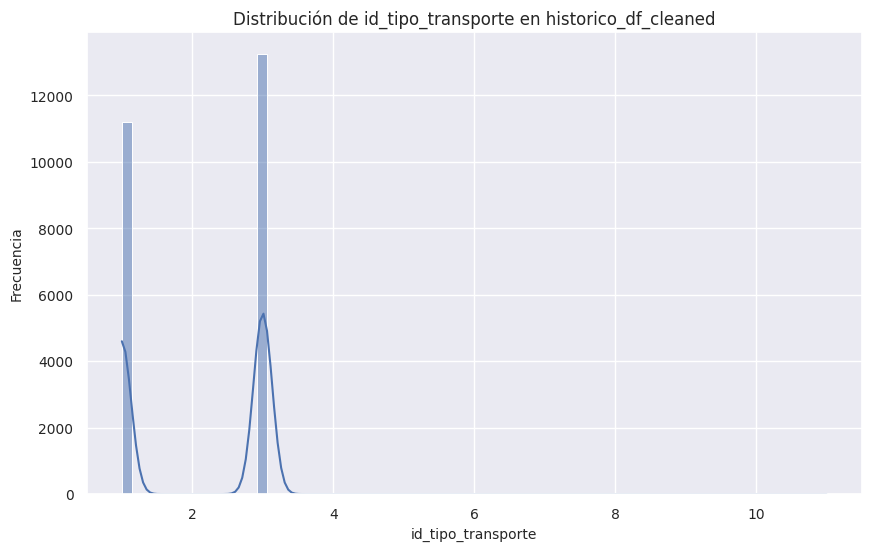

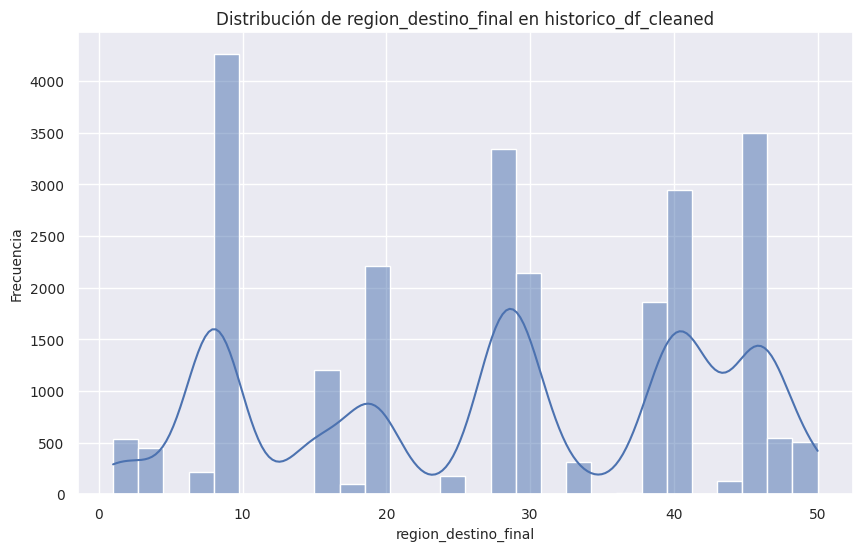

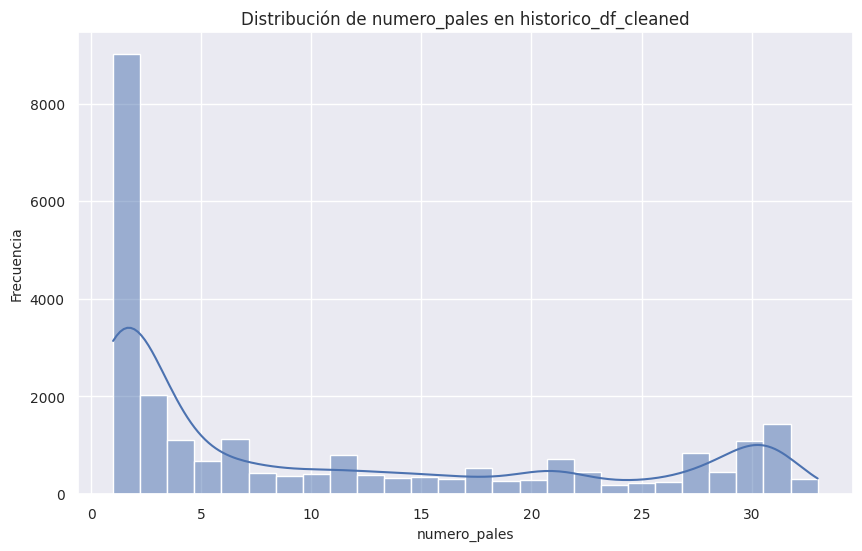

In [45]:
# Identificar las columnas numéricas en historico_df_cleaned
num_cols_historico = historico_df_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Graficar la distribución de cada variable numérica
for col in num_cols_historico:
    plt.figure(figsize=(10, 6))
    sns.histplot(historico_df_cleaned[col], kde=True)
    plt.title(f'Distribución de {col} en historico_df_cleaned')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

**Distribución de id_tipo_transporte:**

La gráfica muestra que hay dos categorías predominantes de transporte, las cuales son las más frecuentemente utilizadas. Es evidente que hay una fuerte concentración en estas dos categorías, mientras que las demás tienen una representación mínima.

La mayoría de los registros se concentran en solo dos tipos de transporte, lo que podría influir en los patrones de comportamiento del volumen de carga.

**Distribución de region_destino_final:**

Observamos una distribución con varios picos, lo que indica que algunas regiones son destinos mucho más frecuentes que otras. Las regiones con mayor frecuencia alcanzan valores por encima de los 4000 envíos.

Hay una fuerte variación en la cantidad de envíos a diferentes regiones, con algunas siendo destinos muy frecuentes. Esto podría ser un factor importante para los modelos predictivos, ya que estas regiones dominantes pueden influir en las estimaciones de volumen.

**Distribución de numero_pales:**

La distribución está sesgada hacia la izquierda, con una gran cantidad de registros concentrados en un número bajo de pales (menor a 5). Sin embargo, también hay algunos casos extremos con números significativamente mayores de pales.

La mayoría de las órdenes tienen un número pequeño de pales, lo cual podría indicar un comportamiento estandarizado en la operación logística. Los casos extremos con un número elevado de pales son menos comunes y podrían ser atípicos.

Estas distribuciones iniciales nos dan una idea de cómo se comportan las variables en el dataset y qué aspectos deberíamos considerar al momento de entrenar modelos predictivos. La concentración en ciertos valores sugiere que podríamos necesitar equilibrar o normalizar los datos si queremos evitar que los modelos estén sesgados hacia las categorías más frecuentes.

b. Frecuencias de variables categóricas.

Vamos a mostrar las frecuencias de las variables categóricas.

In [46]:
# Identificar las columnas categóricas en historico_df_cleaned
cat_cols_historico = historico_df_cleaned.select_dtypes(include=['object']).columns

# Mostrar las frecuencias de las variables categóricas
for col in cat_cols_historico:
    print(f"Frecuencia de {col} en historico_df_cleaned:")
    print(historico_df_cleaned[col].value_counts())
    print("\n")

Frecuencia de id_orden en historico_df_cleaned:
id_orden
OCZ0671450    1
OCZ0654697    1
OCZ0792051    1
OCZ0729255    1
OCZ0624582    1
             ..
OCZ0813625    1
OCZ0722558    1
OCZ0797160    1
OCZ0799816    1
OCZ0738287    1
Name: count, Length: 24435, dtype: int64


Frecuencia de fecha_real_carga en historico_df_cleaned:
fecha_real_carga
2023-07-26 06:00:00.000    7
2021-09-16 00:00:00.000    5
2024-07-15 06:00:00.000    5
2023-03-13 00:00:00.000    5
2024-02-12 07:00:00.000    4
                          ..
2021-03-23 16:34:00.000    1
2024-03-06 11:11:00.000    1
2022-12-21 15:28:00.000    1
2024-03-07 07:38:00.000    1
2023-02-27 15:18:00.000    1
Name: count, Length: 23795, dtype: int64


Frecuencia de provincia_destino_final en historico_df_cleaned:
provincia_destino_final
Barcelona      3859
Madrid         3344
Sevilla        2936
Valencia       2925
Guadalajara    1998
Cantabria      1857
Murcia         1753
La Coruña      1206
Toledo          573
Álava           528
Za

**Frecuencia de id_orden:**

Cada id_orden es único, lo que indica que no hay duplicados en las órdenes registradas. Cada una aparece exactamente una vez.

La columna id_orden es simplemente un identificador único para cada registro, y no aporta información directa para el modelado predictivo. Este comportamiento confirma que esta columna no tiene relevancia como predictor, ya que no tiene variación significativa más allá de la identificación individual de las filas.

**Frecuencia de fecha_real_carga:**

La mayoría de las fechas aparecen una sola vez, aunque hay algunas que se repiten varias veces, como "2023-07-26 06:00:00.000" que aparece 7 veces.

La columna fecha_real_carga contiene datos temporales importantes, pero algunas fechas tienen múltiples órdenes. Esto puede deberse a múltiples cargas o entregas registradas en un mismo día y hora. Esta columna puede ser importante para análisis de series temporales o para identificar patrones estacionales, pero al ser única en su mayoría, también podría complicar ciertos modelos que se beneficien de agrupamientos.

**Frecuencia de provincia_destino_final:**

Las provincias de Barcelona, Madrid, Sevilla, y Valencia tienen el mayor número de registros, con Barcelona siendo la provincia más frecuente con 3,859 registros.

Algunas provincias son destinos mucho más comunes que otras. Barcelona, Madrid, Sevilla y Valencia representan un porcentaje significativo del total de registros, lo que sugiere que estas áreas son puntos logísticos importantes. Provincias con un bajo número de registros, como Almería o Jaén, podrían tener menor relevancia en los modelos o incluso ser considerados outliers. Esta variabilidad podría ser útil para los modelos predictivos al identificar provincias de alta demanda.

Este análisis de frecuencias nos permite entender cómo se distribuyen las categorías en el dataset. Las variables como provincia_destino_final pueden tener un impacto significativo en los modelos, ya que algunas provincias dominan el flujo logístico. Por otro lado, variables como id_orden no parecen aportar valor predictivo y probablemente serán excluidas de los modelos.

**2.3.2 EDA para historico_df_temporal**

a. Evolución de la variable fecha_real_carga

En este caso, graficaremos la evolución de la variable temporal.

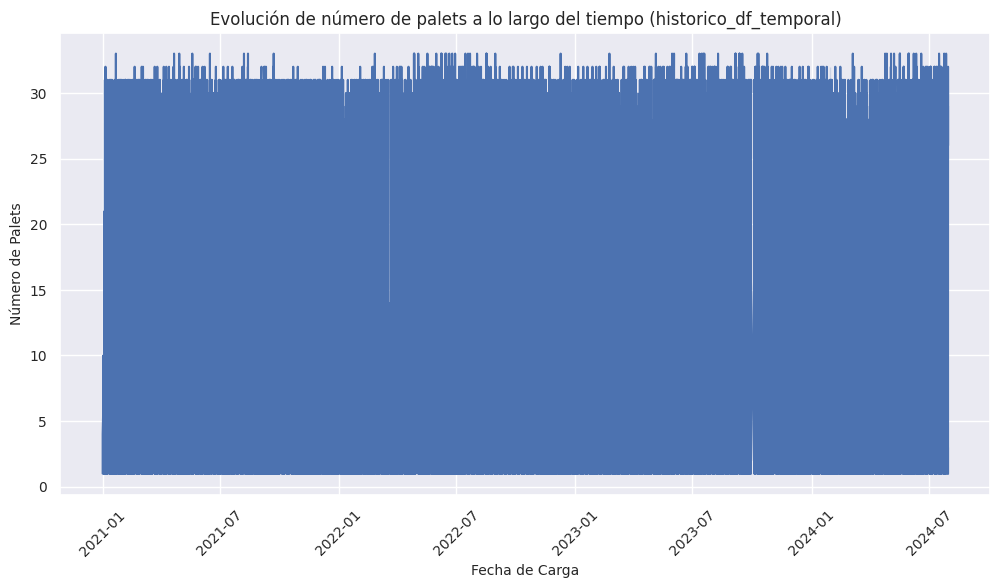

In [47]:
# Graficar la evolución de la variable fecha_real_carga
plt.figure(figsize=(12, 6))
sns.lineplot(x='fecha_real_carga', y='numero_pales', data=historico_df_temporal)
plt.title('Evolución de número de palets a lo largo del tiempo (historico_df_temporal)')
plt.xlabel('Fecha de Carga')
plt.ylabel('Número de Palets')
plt.xticks(rotation=45)
plt.show()

En esta gráfica, se observa la evolución de la variable número de palets a lo largo del tiempo (según la fecha de carga). Algunos puntos importantes a considerar:

Evolución constante: A lo largo de todo el período de tiempo representado (desde 2021 hasta 2024), el número de palets por fecha de carga parece relativamente constante, con la mayoría de los envíos registrando una carga entre 0 y 30 palets.

Aparición de picos y caídas: En ciertos momentos, hay algunos días donde el número de palets cae a 0, lo que podría representar días donde no se realizaron entregas o donde hay datos ausentes o faltantes. Estas caídas, aunque no parecen frecuentes, deben ser examinadas para verificar su impacto en el análisis.

Ausencia de patrones estacionales claros: No parece haber fluctuaciones evidentes estacionales o relacionadas con tendencias anuales, lo que sugiere que el número de palets es más constante en el tiempo. Sin embargo, un análisis más detallado podría revelar variaciones más sutiles.

Este análisis de la evolución temporal muestra que, a nivel superficial, el volumen de palets distribuidos se mantiene relativamente constante a lo largo del tiempo, sin fluctuaciones estacionales o picos significativos. Esto podría influir en los modelos de series temporales como ARIMA o Prophet, los cuales podrían tener dificultades para capturar patrones si estos no son claramente visibles en los datos.

b. Correlación con variables temporales

Podemos calcular las correlaciones entre fecha_real_carga y otras variables.

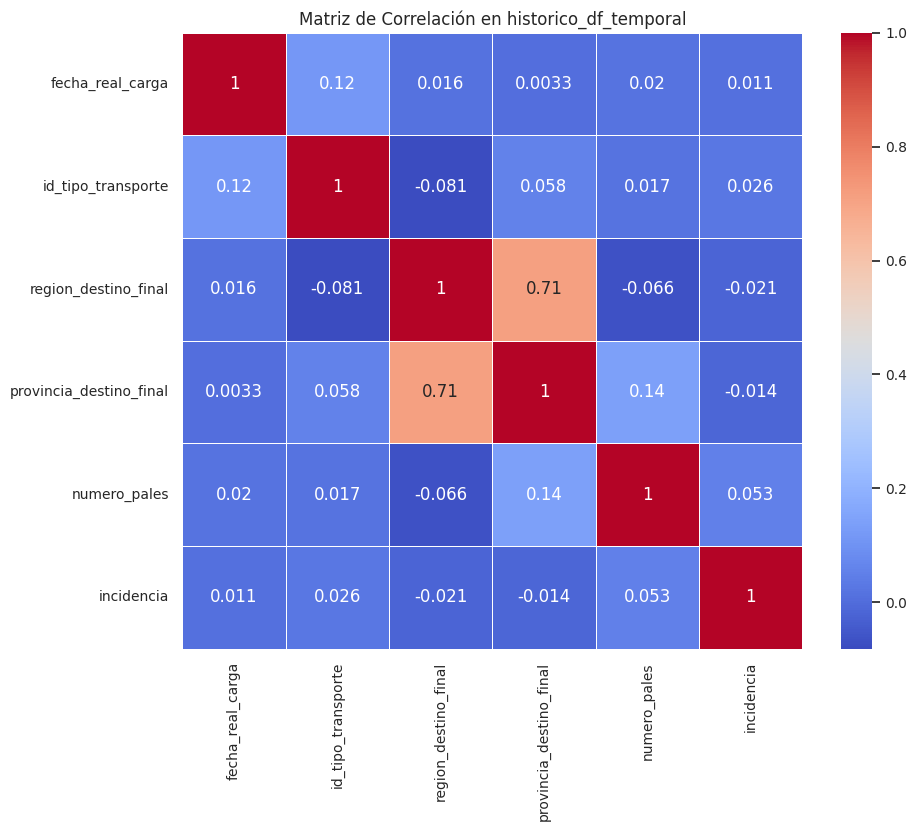

In [48]:
# Calcular correlaciones entre las variables numéricas (incluyendo fecha_real_carga)
corr_matrix_temporal = historico_df_temporal.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_temporal, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación en historico_df_temporal')
plt.show()

En esta matriz de correlación se examinan las relaciones entre la variable fecha_real_carga y otras variables en el dataset. Algunos puntos clave a destacar:

Baja correlación general:

La mayoría de las correlaciones entre fecha_real_carga y otras variables son bastante bajas. Esto indica que la fecha de carga en sí misma no parece estar fuertemente relacionada con otras variables como id_tipo_transporte o numero_pales.

La mayor correlación observada es entre region_destino_final y provincia_destino_final (0.71), lo cual es lógico, ya que las provincias pertenecen a regiones más amplias, lo que genera esta relación natural.

Correlación entre fecha_real_carga y las demás variables:

La correlación entre fecha_real_carga y numero_pales es apenas perceptible (0.02), lo que sugiere que el número de palets enviados no cambia significativamente según la fecha de carga.

De manera similar, la correlación entre fecha_real_carga y variables como id_tipo_transporte o region_destino_final también es baja, lo que indica que las decisiones sobre el tipo de transporte o el destino no están estrechamente vinculadas con la fecha de la carga.

Relación entre region_destino_final y provincia_destino_final:

Como se mencionó anteriormente, la correlación alta entre estas dos variables (0.71) es lógica, ya que las provincias están contenidas dentro de las regiones, y, por lo tanto, una región y su provincia correspondiente están naturalmente vinculadas.

En general, los niveles de correlación observados entre fecha_real_carga y otras variables son bajos, lo que sugiere que no hay una fuerte relación directa entre el momento de la carga y características como el número de palets o el tipo de transporte. La excepción notable es la relación entre region_destino_final y provincia_destino_final, que es una relación estructural esperada en los datos.

**2.3.3. EDA para historico_df_ml**

a. Distribuciones de variables numéricas descompuestas

Aquí graficaremos la distribución de las nuevas variables como ano_carga, mes_carga, dia_carga y hora_carga.

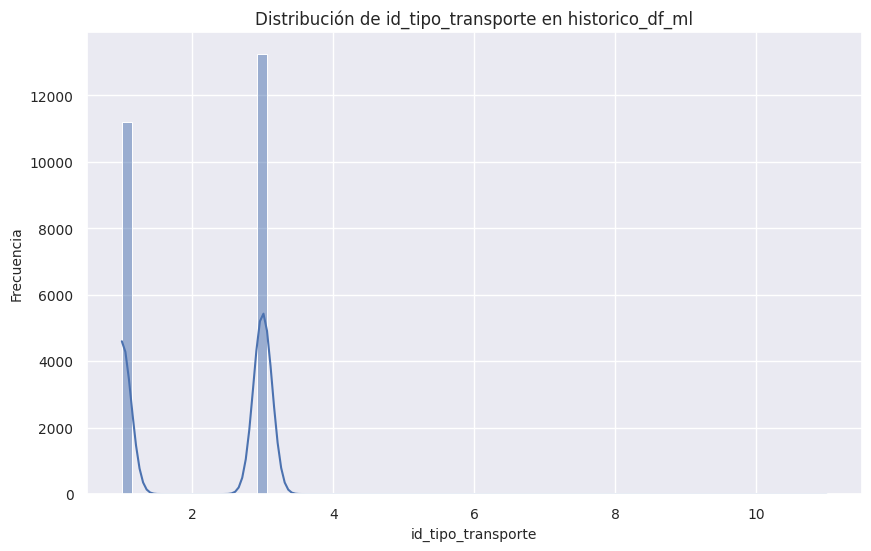

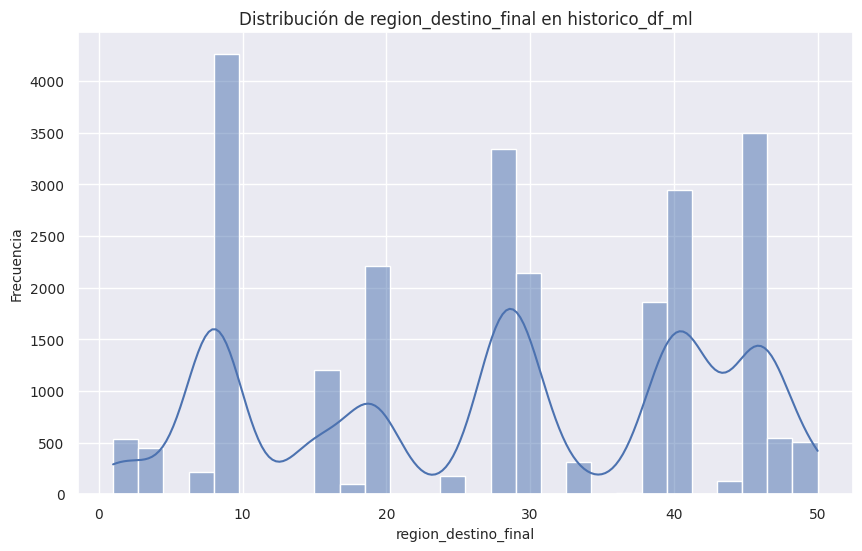

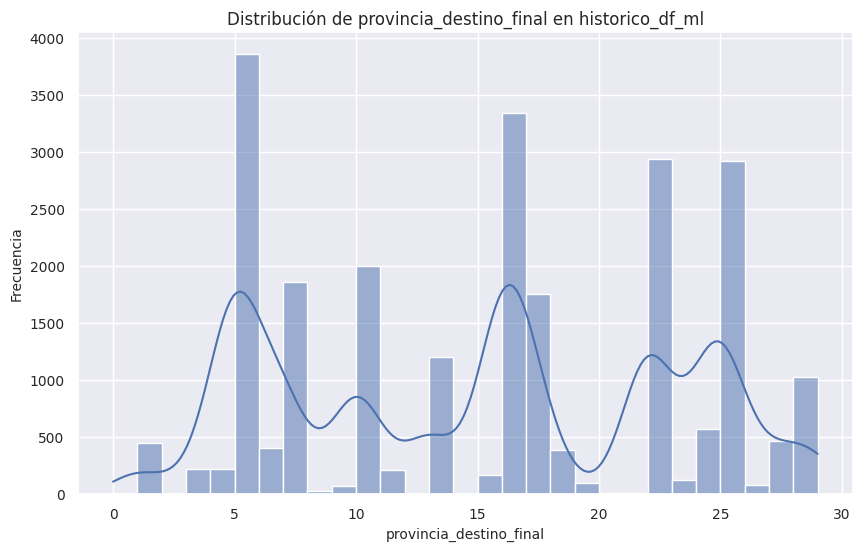

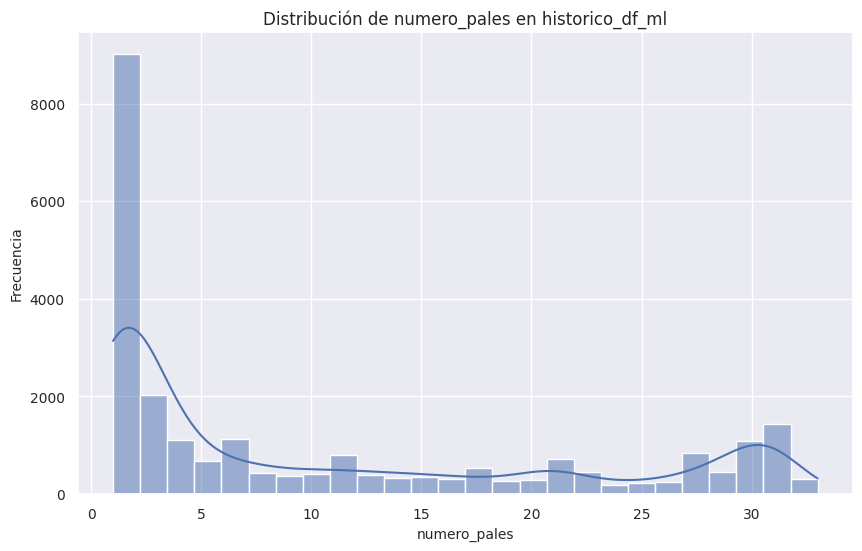

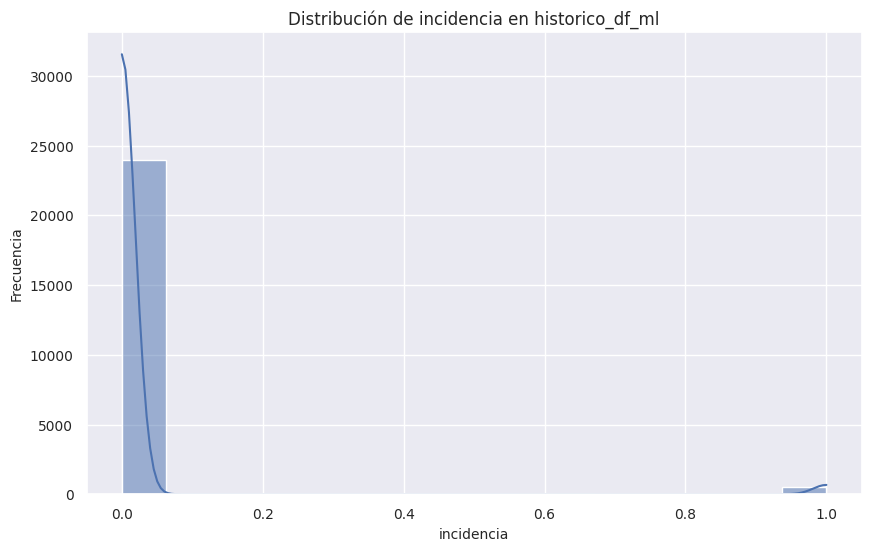

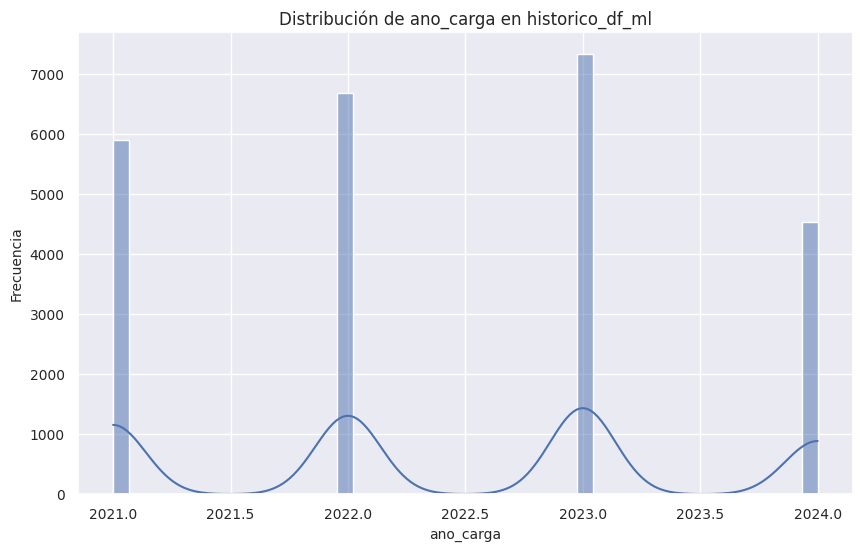

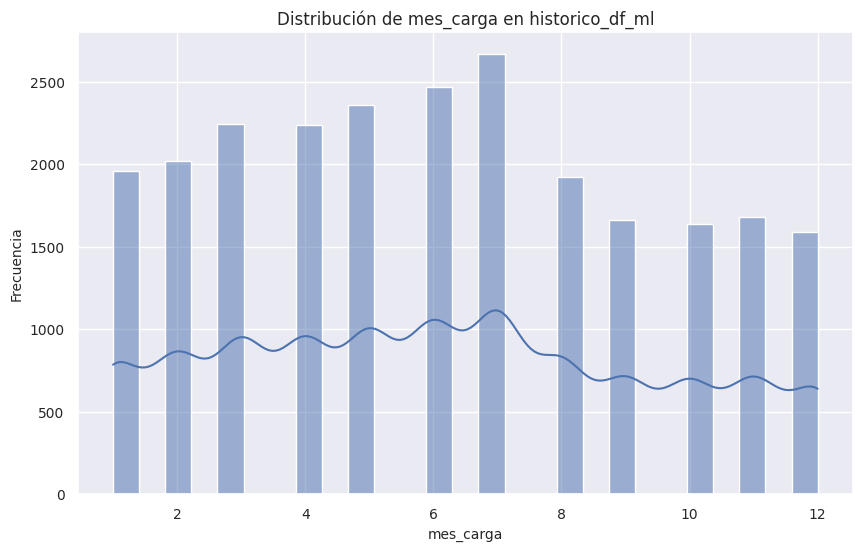

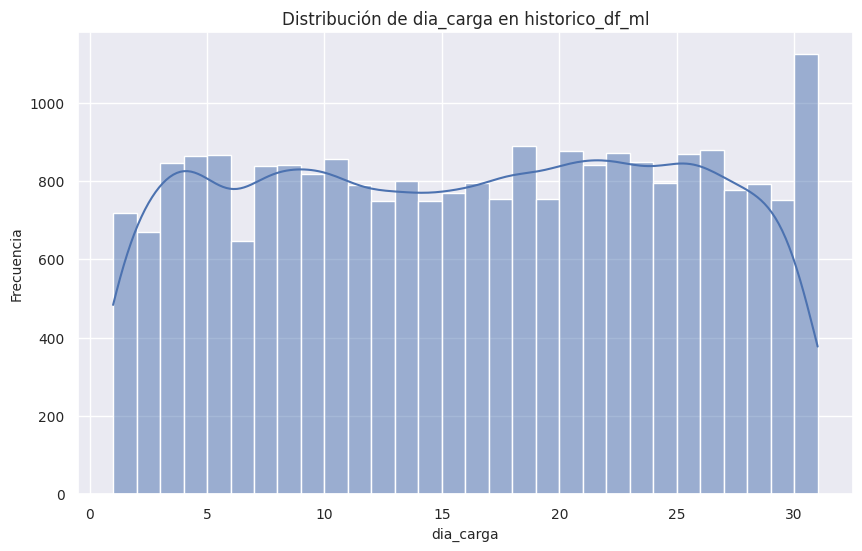

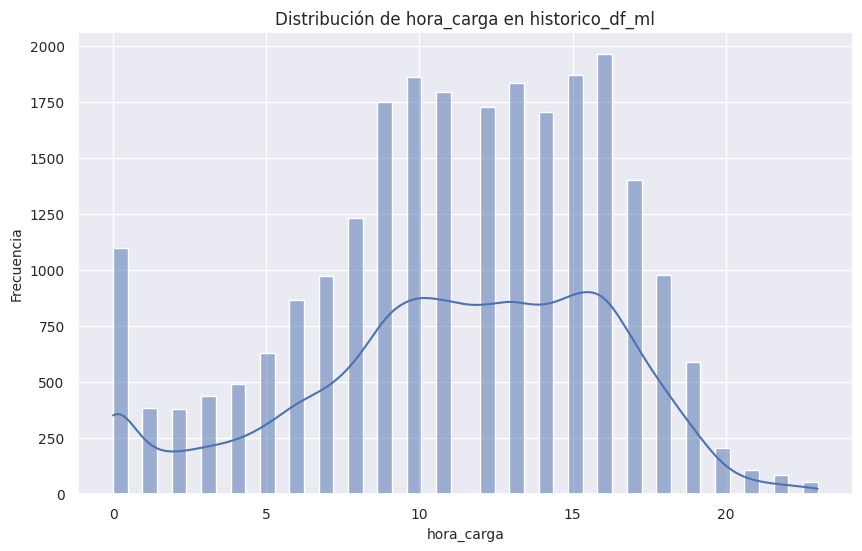

In [49]:
# Identificar las columnas numéricas
num_cols_ml = historico_df_ml.select_dtypes(include=['int64', 'float64']).columns

# Graficar la distribución de las variables numéricas en historico_df_ml
for col in num_cols_ml:
    plt.figure(figsize=(10, 6))
    sns.histplot(historico_df_ml[col], kde=True)
    plt.title(f'Distribución de {col} en historico_df_ml')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

**Distribución de id_tipo_transporte:**

Observamos que existen pocos valores únicos en esta variable. Los tipos de transporte se agrupan principalmente en dos categorías, y son distribuidos de manera asimétrica. Esto indica que la mayoría de los datos provienen de solo dos tipos de transporte.

**Distribución de region_destino_final:**

La variable region_destino_final muestra una variabilidad significativa en cuanto a la cantidad de cargas enviadas a distintas regiones. Hay algunas regiones que reciben una mayor cantidad de envíos, mientras que otras presentan un número considerablemente menor. Las regiones con mayor cantidad de cargas pueden tener implicaciones en el análisis de la distribución logística.

**Distribución de provincia_destino_final:**

La distribución es bastante similar a la anterior, lo que refleja la relación entre regiones y provincias. Algunas provincias dominan el número de cargas recibidas, posiblemente porque son centros de distribución o grandes áreas metropolitanas.

**Distribución de numero_pales:**

La mayoría de las cargas tienen un número bajo de palets, con una clara tendencia hacia cargas con menos de 5 palets. Esto podría indicar una tendencia hacia el envío de cargas más pequeñas o parciales. Hay algunas cargas excepcionales con más de 30 palets, lo que indica que también hay envíos más grandes aunque en menor frecuencia.

**Distribución de incidencia:**

La variable incidencia muestra que la mayoría de las cargas no tienen incidentes. Sin embargo, hay una pequeña fracción de datos donde sí se reportan incidencias, lo cual puede ser importante para la modelación, especialmente en análisis de riesgos o fallos en la logística.

**Distribución de ano_carga:**

Los datos están distribuidos a lo largo de los años 2021 a 2024, con picos específicos en ciertos periodos del año. Esto podría deberse a factores estacionales o ciclos comerciales.

**Distribución de mes_carga:**

Se observa que algunos meses del año tienen más actividad que otros, con un pico en junio. Este comportamiento sugiere una estacionalidad en la demanda de transporte o en la producción.

**Distribución de dia_carga:**

El número de cargas parece estar distribuido uniformemente a lo largo de los días del mes, aunque hay una ligera tendencia a un mayor número de cargas hacia el final de cada mes.

**Distribución de hora_carga:**

Las cargas se concentran entre las 8:00 y las 16:00 horas, lo que indica que la mayoría de las operaciones logísticas ocurren durante el horario laboral. Esto podría ser importante para la optimización de la logística y los recursos humanos.

Estas visualizaciones nos proporcionan una perspectiva clara de cómo están distribuidas las variables en el dataset, lo que puede ayudarnos a identificar patrones, estacionalidades, y áreas en las que podríamos aplicar transformaciones o ingeniería de características.

b. Correlación entre variables numéricas

Vamos a calcular la matriz de correlación entre las nuevas variables y otras variables numéricas.

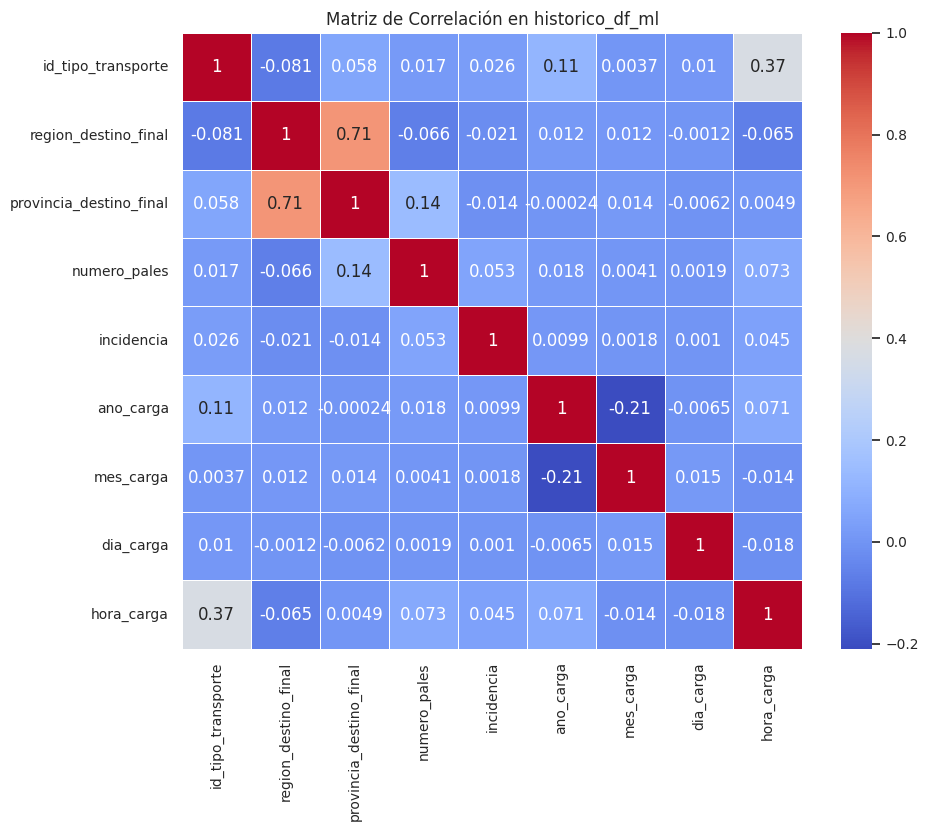

In [50]:
# Matriz de correlación en historico_df_ml
corr_matrix_ml = historico_df_ml.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_ml, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación en historico_df_ml')
plt.show()

**Correlaciones moderadas:**

La correlación entre region_destino_final y provincia_destino_final es relativamente alta (0.71), lo cual tiene sentido dado que las provincias se agrupan dentro de regiones. Esto indica que la información de una de estas variables puede redundar en la otra.
hora_carga muestra una correlación moderada con id_tipo_transporte (0.37), lo que sugiere que ciertas horas de carga pueden estar relacionadas con el tipo de transporte.

**Baja correlación:**

La mayoría de las otras variables muestran correlaciones bastante bajas entre sí, lo que indica que las variables no están fuertemente relacionadas. Esto puede ser positivo en términos de multicolinealidad, pero también sugiere que la capacidad predictiva de algunas de estas variables podría ser limitada si se usan en modelos lineales simples.
Por ejemplo, incidencia tiene correlaciones muy bajas con casi todas las variables, lo que podría indicar que su presencia no está fuertemente asociada a factores como la fecha de carga o la cantidad de palets.

**Independencia temporal:**

Las variables temporales (ano_carga, mes_carga, dia_carga, hora_carga) no tienen correlaciones fuertes entre ellas, lo cual es esperado debido a que se descompusieron de la variable original fecha_real_carga.
**La baja correlación entre la mayoría de las variables indica que puede ser necesario utilizar modelos no lineales o aplicar ingeniería de características adicional para capturar patrones más complejos en los datos.**

**2.3.4 EDA para tarifas_df_cleaned**

a. Distribución de variables numéricas

Graficaremos las distribuciones de las variables numéricas en tarifas_df_cleaned.

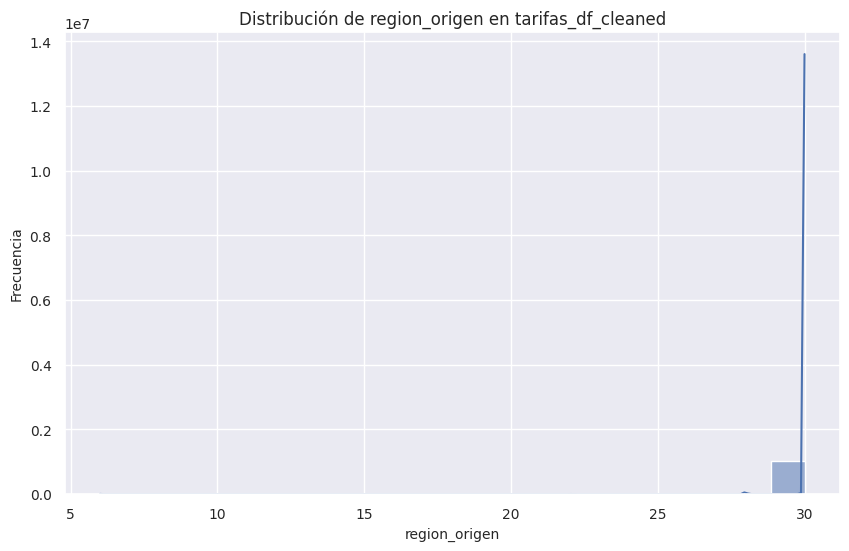

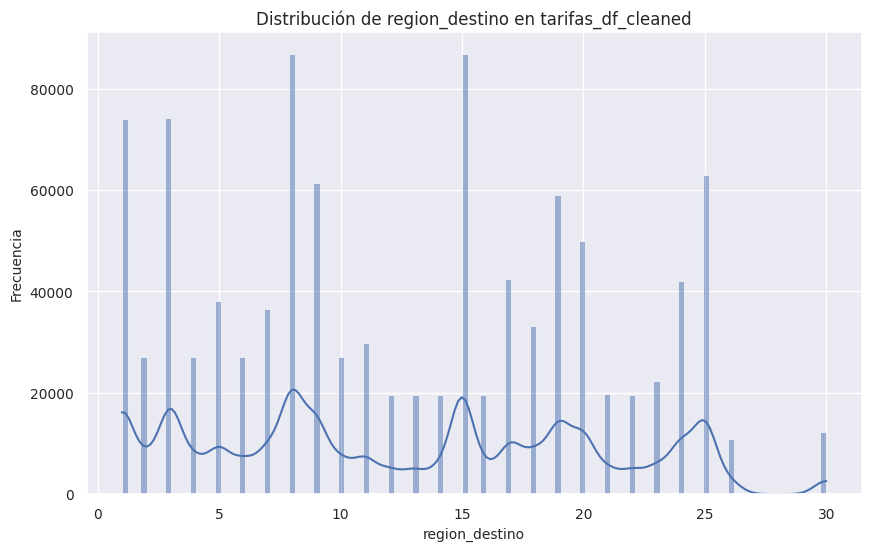

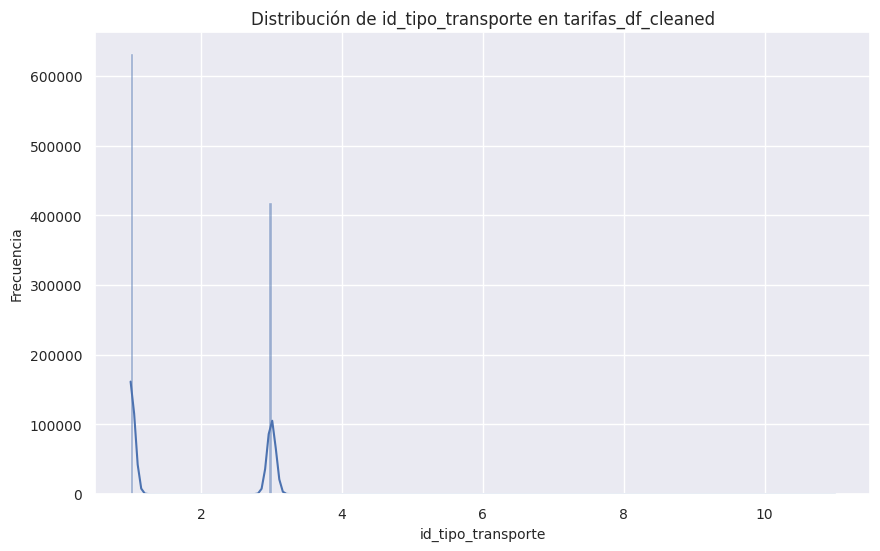

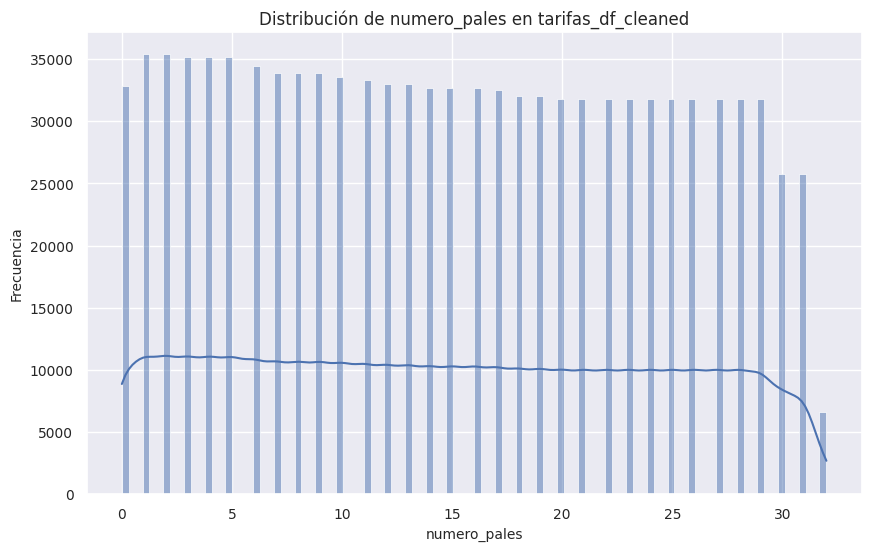

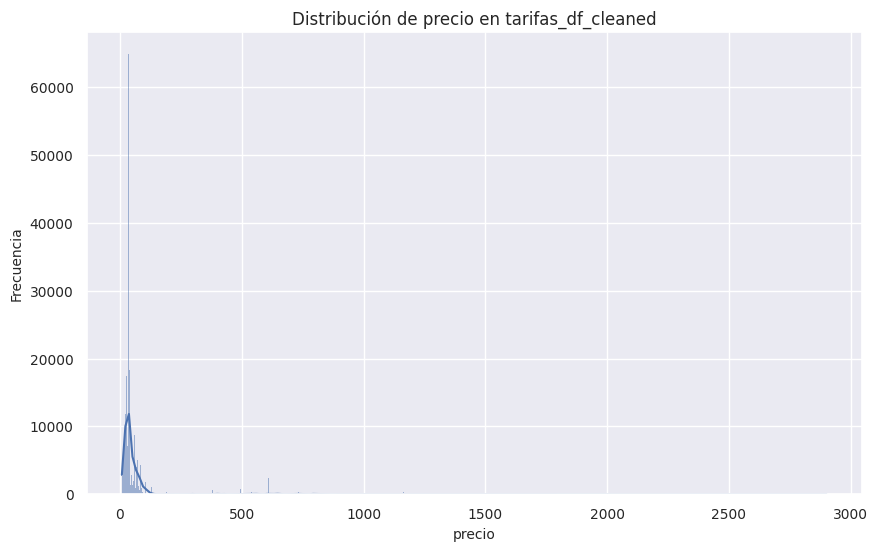

In [51]:
# Identificar las columnas numéricas en tarifas_df_cleaned
num_cols_tarifas = tarifas_df_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Graficar la distribución de cada variable numérica
for col in num_cols_tarifas:
    plt.figure(figsize=(10, 6))
    sns.histplot(tarifas_df_cleaned[col], kde=True)
    plt.title(f'Distribución de {col} en tarifas_df_cleaned')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

**Distribución de region_origen:**

Parece haber una alta concentración en una región específica (código 30), lo que indica que la mayoría de las cargas provienen de esa región. Esto sugiere que este origen es predominante en los datos.

**Distribución de region_destino:**

La distribución está más dispersa, pero algunas regiones tienen una mayor frecuencia de destino, lo que indica que ciertas regiones son más comunes para las entregas.

**Distribución de id_tipo_transporte:**

Los valores de esta variable están concentrados en dos categorías principales. Esto refleja que dos tipos de transporte son los más utilizados en el dataset.

**Distribución de numero_pales:**

La variable presenta una distribución bastante uniforme para la mayoría de los valores de palets, aunque se observa una ligera caída en los valores más altos de palets, lo que significa que los envíos con mayor número de palets son menos frecuentes.

**Distribución de precio:**

La distribución del precio está sesgada hacia la izquierda, con una alta concentración de valores en el rango bajo. Esto indica que la mayoría de los precios de las cargas son relativamente bajos, con algunos pocos valores que alcanzan precios más altos.

Estas distribuciones nos proporcionan una visión inicial de cómo están distribuidas las variables numéricas en el dataset, lo que puede influir en las decisiones futuras de modelado, como la normalización o el ajuste del rango de valores.

b. Frecuencias de variables categóricas

Visualizaremos las frecuencias de las variables categóricas.

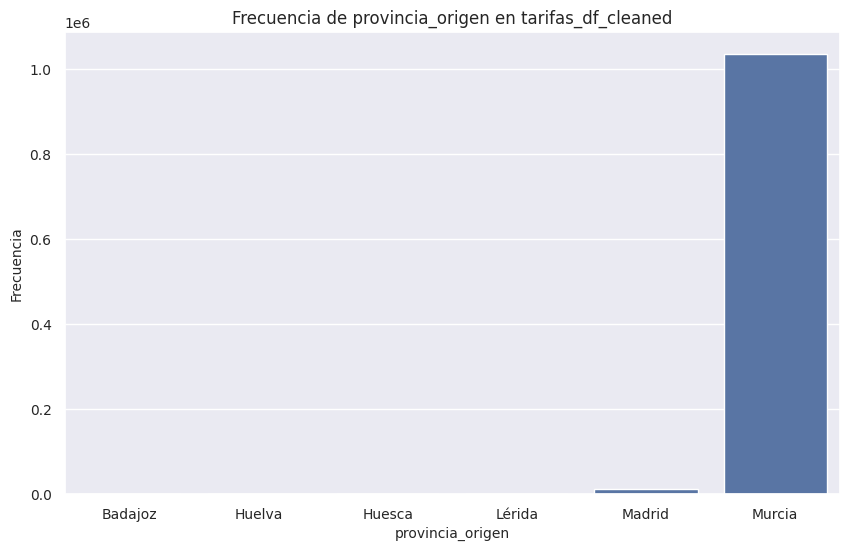

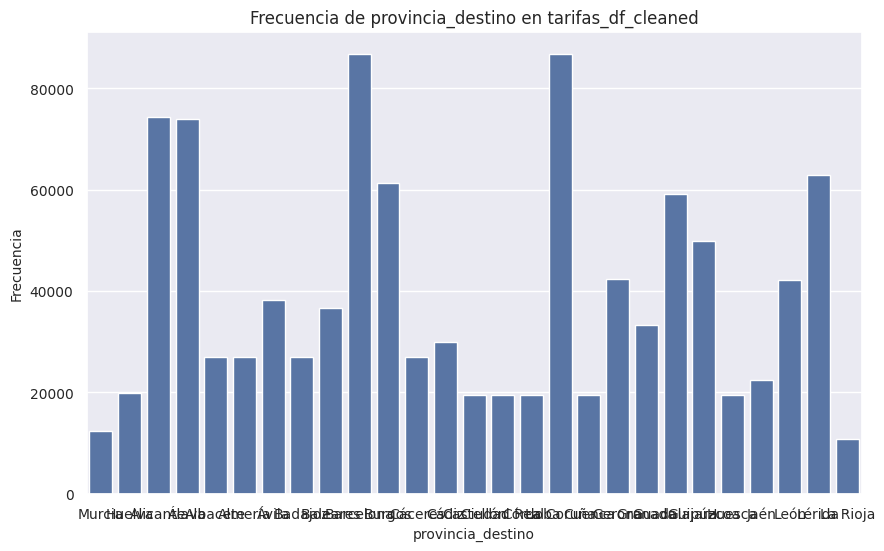

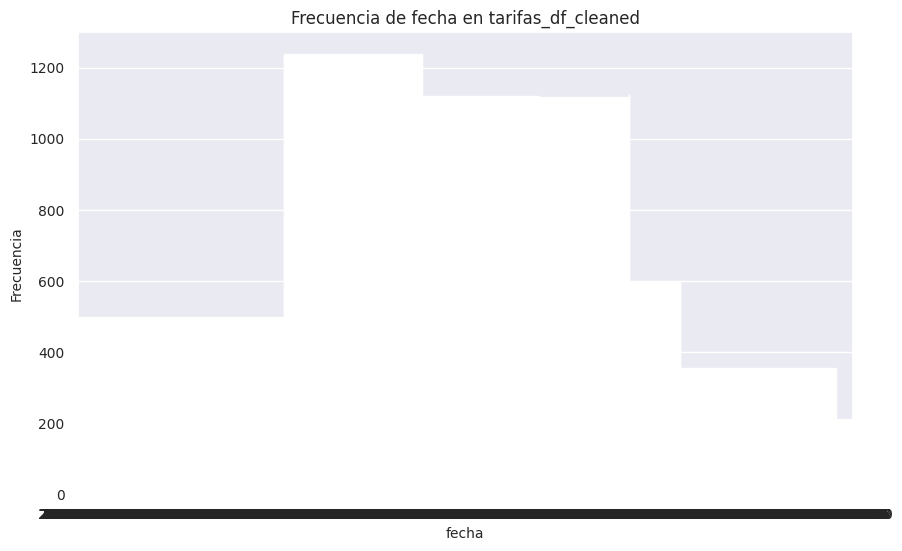

In [52]:
# Identificar las columnas categóricas en tarifas_df_cleaned
cat_cols_tarifas = tarifas_df_cleaned.select_dtypes(include=['object']).columns

# Graficar la frecuencia de cada variable categórica
for col in cat_cols_tarifas:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=tarifas_df_cleaned)
    plt.title(f'Frecuencia de {col} en tarifas_df_cleaned')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

**Frecuencia de provincia_origen en tarifas_df_cleaned:**

Observamos que la provincia de Murcia domina casi por completo el origen de las cargas. Esto podría significar que las operaciones logísticas o el comercio se concentran principalmente en esa región.

**Frecuencia de provincia_destino en tarifas_df_cleaned:**

A diferencia del gráfico de provincia_origen, la distribución de los destinos es más diversa, aunque algunos destinos como Barcelona y Madrid aparecen con mayor frecuencia. Esto sugiere que hay ciertos centros logísticos o comerciales clave en el país.

**Frecuencia de fecha en tarifas_df_cleaned:**

La frecuencia de la variable fecha muestra algunas fluctuaciones y posibles huecos en los datos. Esto podría deberse a faltantes o a períodos donde no se registraron operaciones. Estos huecos podrían tener un impacto en las predicciones, especialmente en los modelos de series temporales.

Con estas observaciones, podemos comenzar a entender mejor el comportamiento logístico a través de las tarifas y volúmenes de carga en distintas regiones.

**2.3.5 EDA para tarifas_df_temporal**

a. Evolución de precio y fecha

Vamos a graficar la evolución del precio en función del tiempo.

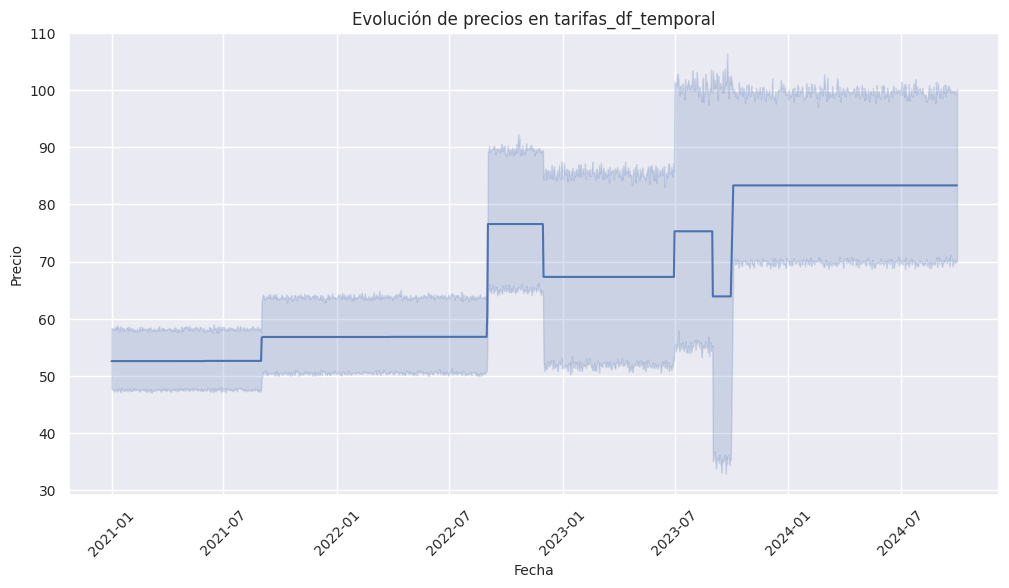

In [53]:
# Graficar la evolución de precios a lo largo del tiempo
plt.figure(figsize=(12, 6))
sns.lineplot(x='fecha', y='precio', data=tarifas_df_temporal)
plt.title('Evolución de precios en tarifas_df_temporal')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.show()

**Tendencia general:**

El gráfico muestra un comportamiento escalonado en el precio, con incrementos y caídas bruscas a lo largo del tiempo. Este patrón puede reflejar políticas de precios establecidas o factores estacionales.

**Rangos de variación:**
En varios periodos, se puede ver que los precios tienen una dispersión significativa alrededor de ciertos valores fijos, indicando que aunque el precio base se mantiene constante, hay fluctuaciones menores en ciertos intervalos.

**Cambios significativos:**
Se observan algunos cambios abruptos en el precio, lo que puede sugerir ajustes de tarifas en función de eventos o cambios en el mercado, como los incrementos en el año 2022 y la caída a mediados de 2023.

Este tipo de gráfico es útil para analizar los cambios en la tarifa a lo largo del tiempo y podría ser de gran utilidad en la modelización de series temporales para predecir futuras tendencias.

b. Correlación con las variables temporales

Vamos a revisar si hay alguna correlación significativa entre fecha y otras variables.

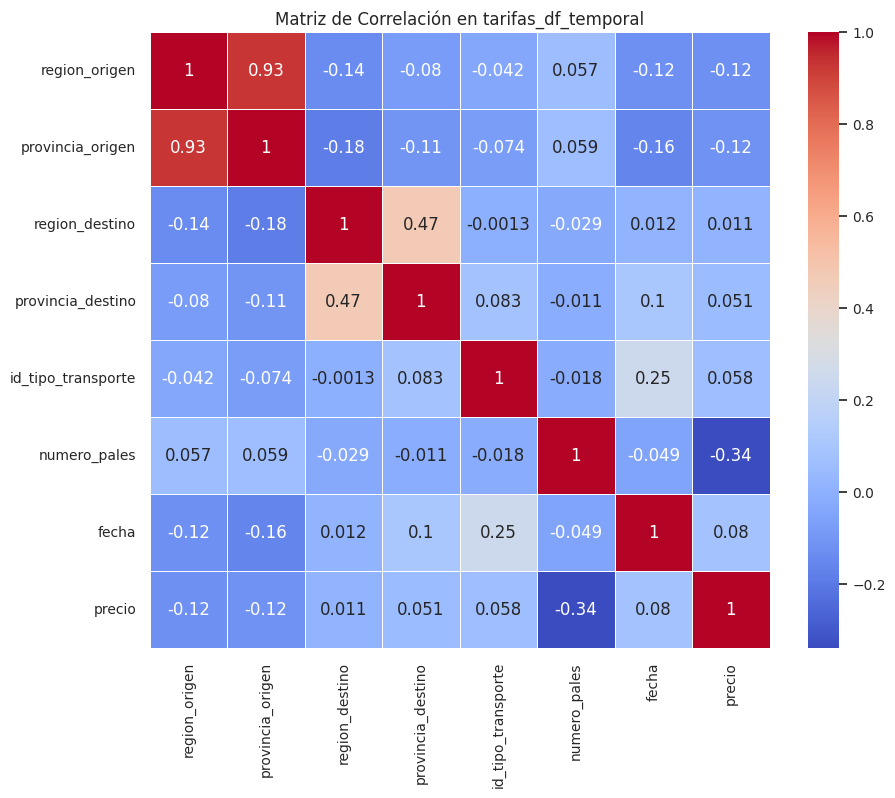

In [54]:
# Calcular la matriz de correlación
corr_matrix_tarifas_temporal = tarifas_df_temporal.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_tarifas_temporal, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación en tarifas_df_temporal')
plt.show()

**Correlación entre variables geográficas:**

Hay una alta correlación entre region_origen y provincia_origen (0.93), lo que es esperable, ya que la provincia es una subdivisión de la región.
Asimismo, hay una correlación moderada entre region_destino y provincia_destino (0.47), lo que también sigue una lógica geográfica.

**Precio:**

El precio no presenta correlaciones fuertes con la mayoría de las variables. Sin embargo, tiene una correlación negativa con numero_pales (-0.34), lo que podría indicar que a medida que aumenta el número de palets, el precio unitario por carga tiende a disminuir, sugiriendo un posible descuento por volumen.
La correlación entre el precio y la variable temporal fecha es baja (0.08), lo que indica que la variación de precios no está directamente ligada al paso del tiempo de forma lineal, al menos en esta escala temporal.

**Número de palets:**

numero_pales tiene una correlación negativa significativa con el precio (-0.34), lo que refuerza la idea de descuentos por volumen.
También muestra una correlación moderada con el tipo de transporte (0.25), lo cual podría sugerir que ciertos tipos de transporte son más propensos a llevar más palets.

**Fecha:**

La correlación entre fecha y otras variables es generalmente baja, excepto con el tipo de transporte (0.25). Esto podría indicar que en diferentes momentos del tiempo, los tipos de transporte utilizados han variado.
Esta matriz nos proporciona una visión clara de las relaciones entre las variables, aunque en general no hay correlaciones extremadamente altas (excepto las geográficas). Esta información será valiosa para ajustar los modelos predictivos y realizar ingeniería de características en los siguientes pasos.

**2.3.6 EDA para tarifas_df_ml**

a. Distribución de variables numéricas descompuestas

Aquí analizaremos la distribución de las variables numéricas ano, mes, dia y precio.

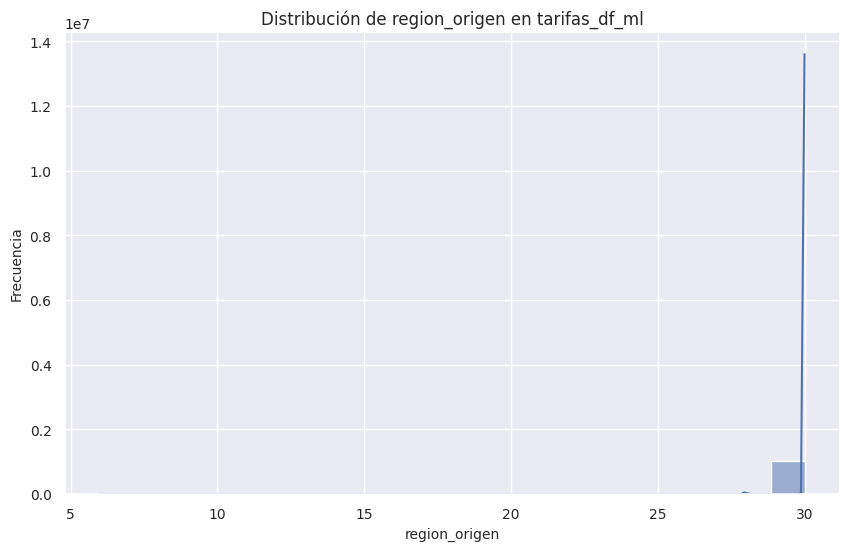

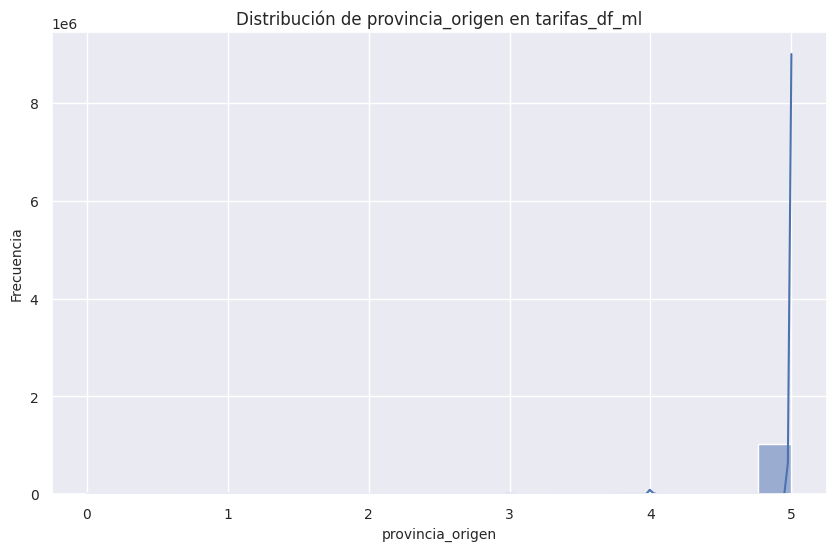

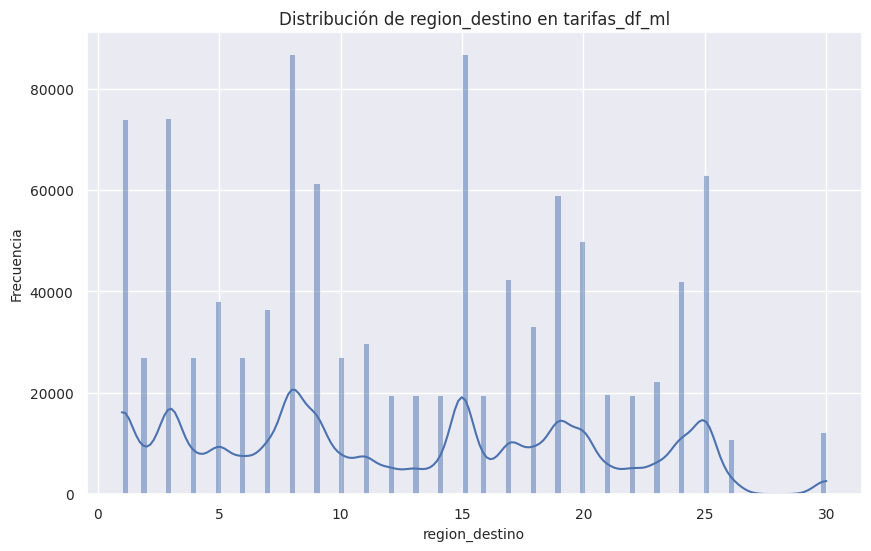

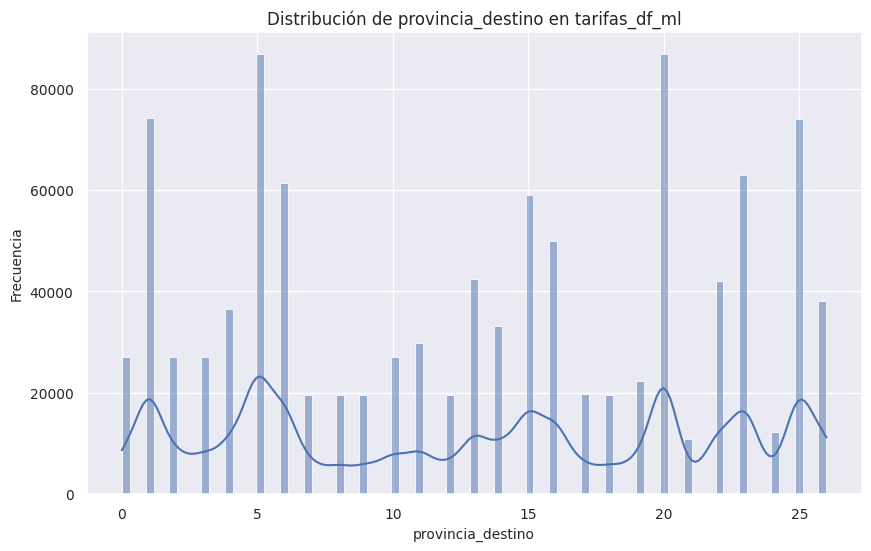

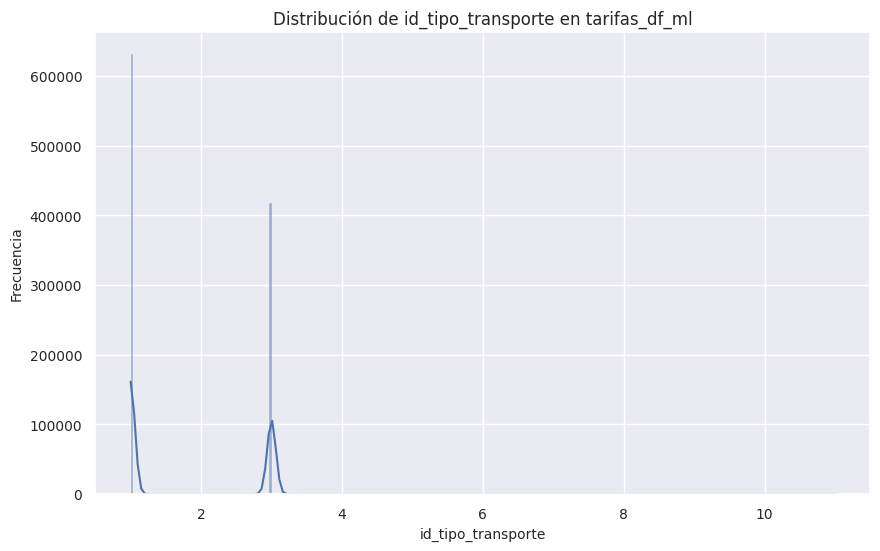

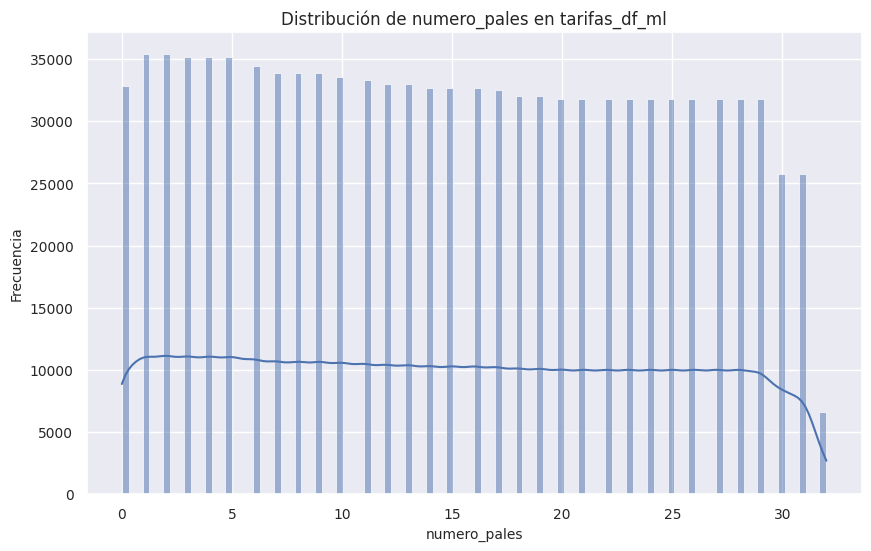

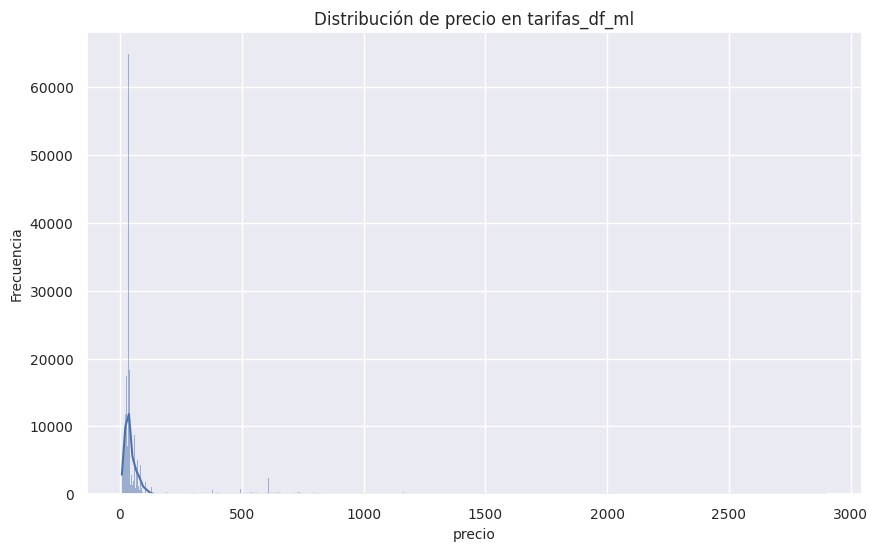

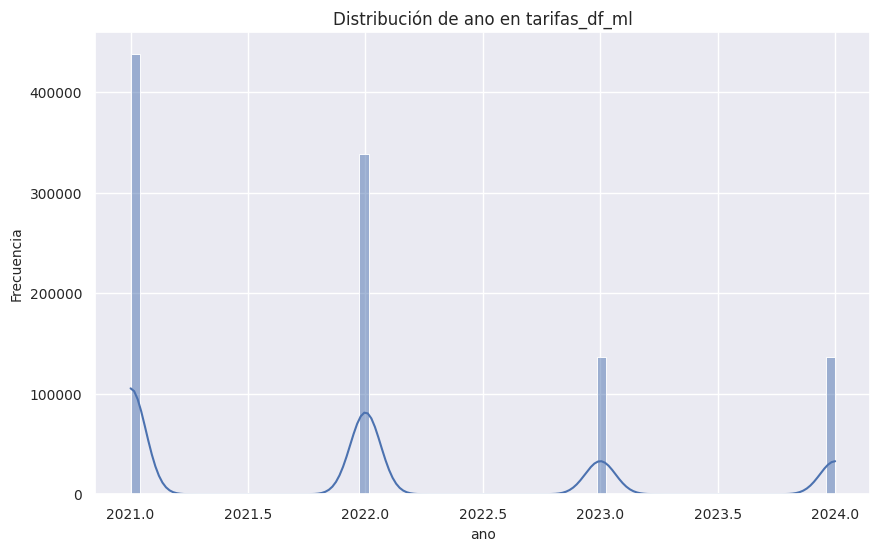

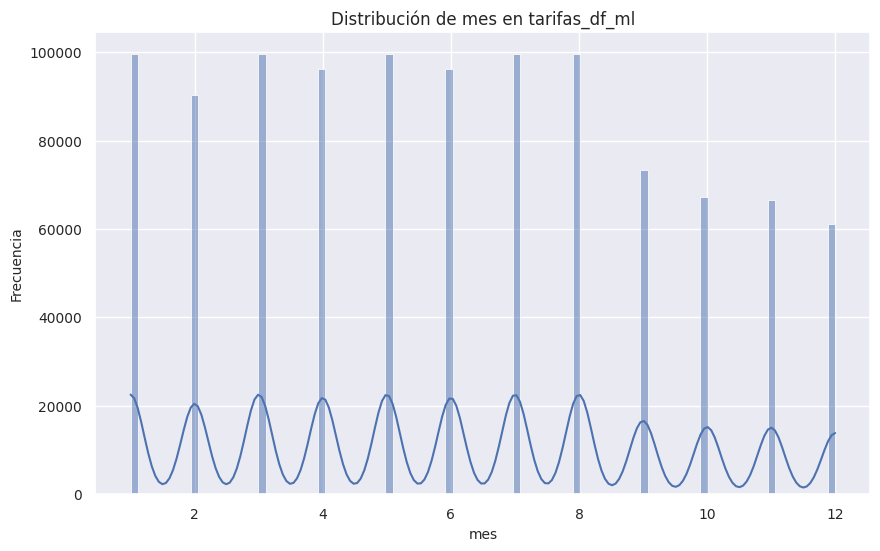

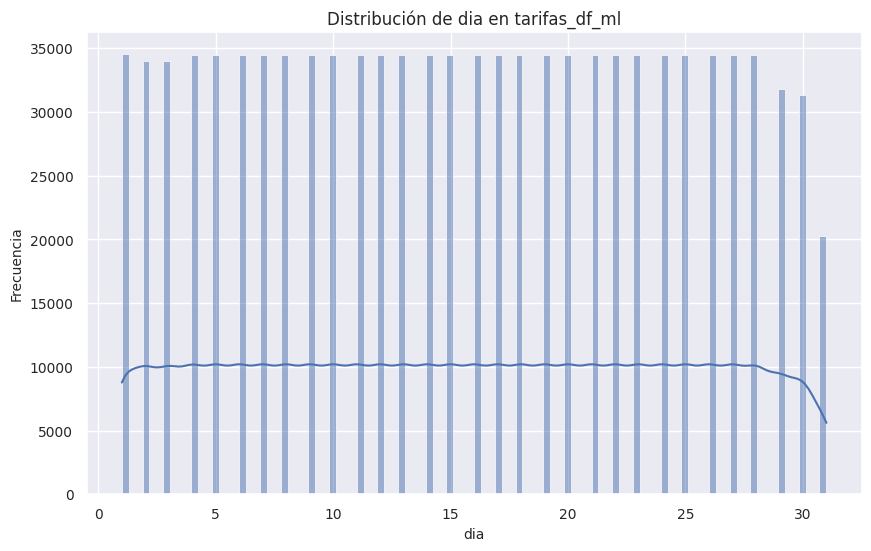

In [55]:
# Graficar la distribución de variables numéricas en tarifas_df_ml
num_cols_tarifas_ml = tarifas_df_ml.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols_tarifas_ml:
    plt.figure(figsize=(10, 6))
    sns.histplot(tarifas_df_ml[col], kde=True)
    plt.title(f'Distribución de {col} en tarifas_df_ml')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

**Distribución de "region_origen" y "provincia_origen":**

La mayoría de los registros provienen de la región 30, y dentro de esta región, provincia 5 tiene una alta concentración.
Esto puede indicar un sesgo significativo en la distribución de los datos hacia una provincia/región específica.

**Distribución de "region_destino" y "provincia_destino":**

Las regiones de destino están más diversificadas en comparación con las de origen. Sin embargo, la región 15 tiene la mayor cantidad de registros, y su provincia correspondiente también presenta un alto volumen.

**Distribución de "id_tipo_transporte":**

Los valores 1 y 3 de id_tipo_transporte son los más frecuentes, lo que sugiere que ciertos modos de transporte dominan el conjunto de datos.

**Distribución de "numero_pales":**

La variable numero_pales tiene una distribución relativamente uniforme en los valores centrales (de 5 a 30 palés), pero la mayoría de los registros se concentran en el rango más bajo.

**Distribución de "precio":**

La distribución de precio muestra una alta concentración de valores bajos (menores de 100), con un largo cola hacia precios más altos, indicando que existen outliers o valores extremos.

**Distribución de las variables temporales (ano, mes, dia):**

El gráfico de ano refleja una cantidad mayor de registros para el año 2021, con picos menores en los años siguientes.
En cuanto a mes, la distribución parece ser cíclica, con picos regulares en ciertos meses.

Día muestra una distribución plana, lo que indica que la cantidad de registros está bien distribuida a lo largo de los días del mes.

b. Correlaciones entre variables numéricas

Finalmente, calcularemos la correlación entre las variables.

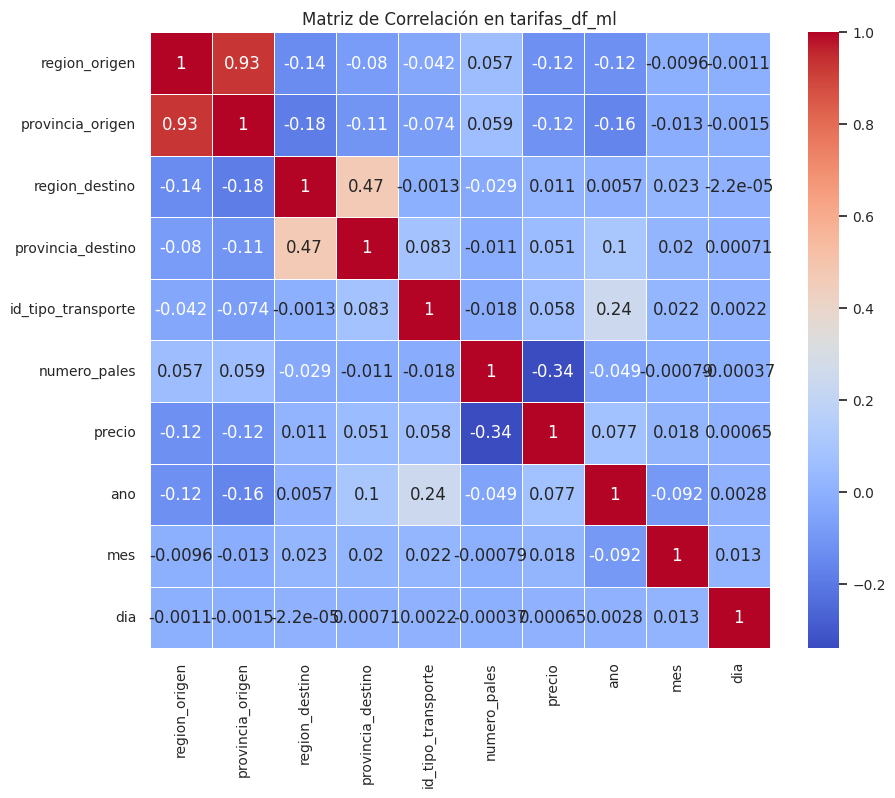

In [56]:
# Matriz de correlación para tarifas_df_ml
corr_matrix_tarifas_ml = tarifas_df_ml.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_tarifas_ml, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación en tarifas_df_ml')
plt.show()

**Correlación alta entre "region_origen" y "provincia_origen":**

Existe una alta correlación positiva (0.93) entre estas dos variables, lo cual es lógico, ya que las provincias están contenidas dentro de las regiones. Esto podría implicar redundancia, por lo que podríamos considerar eliminar una de ellas si se busca simplificar el modelo.

**Correlación entre "region_destino" y "provincia_destino":**

La correlación entre estas variables es moderada (0.47), lo que también refleja una relación esperada entre estas dos características.

**"numero_pales" y "precio":**

Hay una correlación negativa (-0.34) entre estas dos variables, lo que indica que a mayor cantidad de palés, el precio tiende a disminuir. Esto podría reflejar descuentos por volumen en las tarifas.

**Correlación entre "id_tipo_transporte" y "ano":**

Hay una correlación positiva (0.24) entre estas variables, lo que sugiere que ciertos tipos de transporte pueden haberse vuelto más populares en años específicos.

**Otras correlaciones:**

En general, la mayoría de las demás variables muestran correlaciones débiles entre sí, lo que sugiere que probablemente no están muy relacionadas o que su efecto conjunto podría ser importante para el modelo.

**3.- Análisis Exploratorio de Datos (EDA)**

**3.1 Análisis de Correlación**

Análisis de Correlación para **historico_df_cleaned**

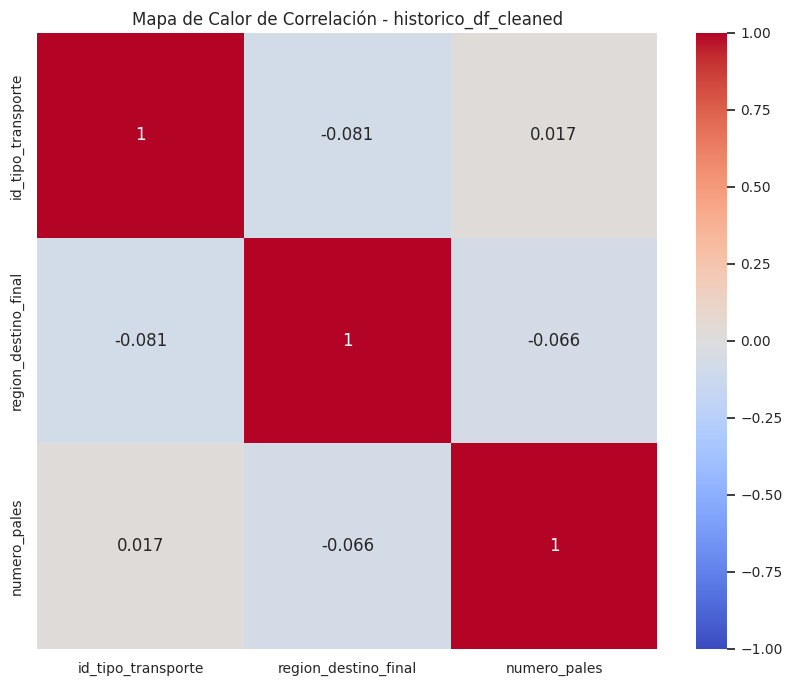

Matriz de correlación de historico_df_cleaned:
                      id_tipo_transporte  region_destino_final  numero_pales
id_tipo_transporte              1.000000             -0.081279      0.017382
region_destino_final           -0.081279              1.000000     -0.066381
numero_pales                    0.017382             -0.066381      1.000000


In [57]:
# Seleccionar solo columnas numéricas en historico_df_cleaned
num_cols_historico_cleaned = historico_df_cleaned.select_dtypes(include=['int64', 'float64']).columns
corr_historico_cleaned = historico_df_cleaned[num_cols_historico_cleaned].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_historico_cleaned, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Calor de Correlación - historico_df_cleaned")
plt.show()

# Mostrar la matriz de correlación
print("Matriz de correlación de historico_df_cleaned:")
print(corr_historico_cleaned)

**id_tipo_transporte** no tiene una correlación significativa con ninguna otra variable. Las correlaciones con las demás variables son bajas, con valores cercanos a 0 (-0.08 con region_destino_final y 0.01 con numero_pales). Esto indica que el tipo de transporte no parece estar relacionado con la cantidad de palés transportados o la región de destino.

**region_destino_final** tiene una correlación negativa baja con numero_pales (-0.066), lo que sugiere una débil relación inversa entre la región de destino y el número de palés. Sin embargo, el valor es tan bajo que no parece ser significativo.

**numero_pales** tampoco presenta una correlación notable con las demás variables.

En resumen, no hay una relación clara o fuerte entre las variables en este dataset, lo que sugiere que los factores como el tipo de transporte, la región de destino y el número de palés son relativamente independientes entre sí en este conjunto de datos.

Análisis de Correlación para **historico_df_ml**

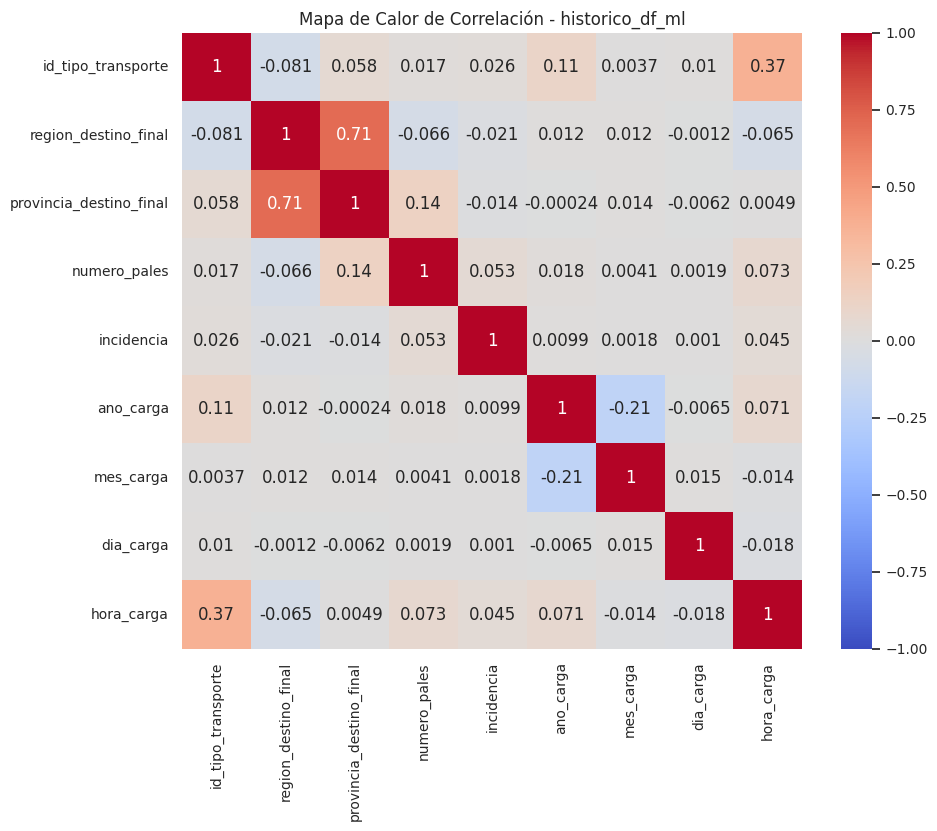

Matriz de correlación de historico_df_ml:
                         id_tipo_transporte  region_destino_final  \
id_tipo_transporte                 1.000000             -0.081279   
region_destino_final              -0.081279              1.000000   
provincia_destino_final            0.057860              0.708573   
numero_pales                       0.017382             -0.066381   
incidencia                         0.026449             -0.021091   
ano_carga                          0.112973              0.012323   
mes_carga                          0.003745              0.011577   
dia_carga                          0.010325             -0.001246   
hora_carga                         0.368297             -0.064717   

                         provincia_destino_final  numero_pales  incidencia  \
id_tipo_transporte                      0.057860      0.017382    0.026449   
region_destino_final                    0.708573     -0.066381   -0.021091   
provincia_destino_final          

In [58]:
# Seleccionar solo columnas numéricas en historico_df_ml
num_cols_historico_ml = historico_df_ml.select_dtypes(include=['int64', 'float64']).columns
corr_historico_ml = historico_df_ml[num_cols_historico_ml].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_historico_ml, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Calor de Correlación - historico_df_ml")
plt.show()

# Mostrar la matriz de correlación
print("Matriz de correlación de historico_df_ml:")
print(corr_historico_ml)

**id_tipo_transporte** tiene una correlación moderada positiva (0.37) con hora_carga. Esto sugiere que ciertos tipos de transporte pueden estar más asociados a determinadas horas del día.

**region_destino_final** está fuertemente correlacionada con provincia_destino_final (0.71), lo que indica que estas variables están estrechamente relacionadas, lo cual tiene sentido ya que la región y la provincia del destino final son conceptos geográficamente vinculados.

**numero_pales** muestra una correlación baja con provincia_destino_final (0.14) y casi nula con las demás variables, lo que indica que la cantidad de palés transportados no depende significativamente del destino o del tipo de transporte.

**ano_carga** y **mes_carga** presentan una correlación negativa (-0.21), lo que podría reflejar estacionalidad o variaciones en las cargas a lo largo del año, aunque el valor es bajo para considerarlo significativo.

**hora_carga** tiene una correlación baja con la mayoría de las variables, excepto con id_tipo_transporte (0.37) como se mencionó anteriormente.

En resumen, las correlaciones más destacables en este análisis son la relación entre la región y la provincia de destino final, así como la asociación entre el tipo de transporte y la hora de carga. No se observan correlaciones altas con otras variables.

Análisis de Correlación para **tarifas_df_cleaned**

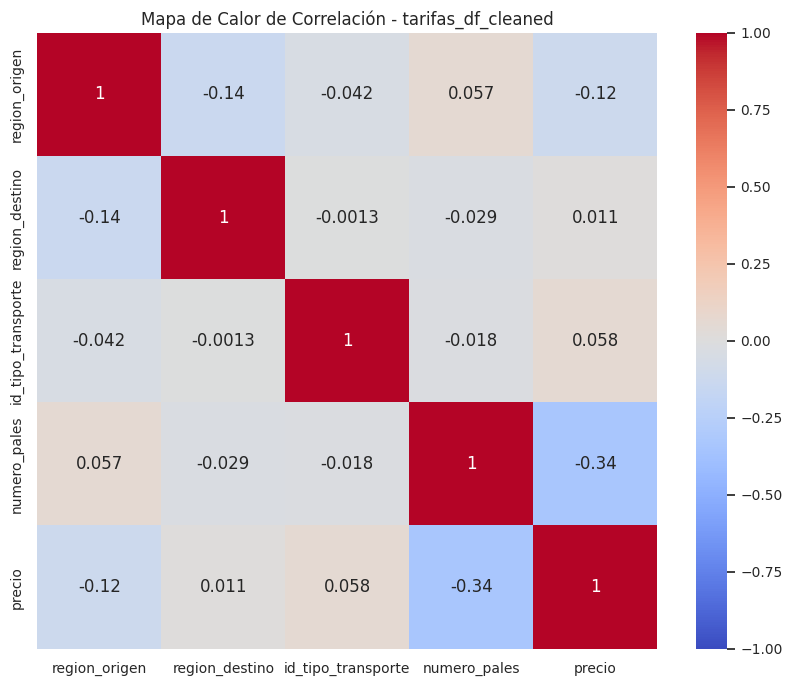

Matriz de correlación de tarifas_df_cleaned:
                    region_origen  region_destino  id_tipo_transporte  \
region_origen            1.000000       -0.139452           -0.041855   
region_destino          -0.139452        1.000000           -0.001275   
id_tipo_transporte      -0.041855       -0.001275            1.000000   
numero_pales             0.056615       -0.029295           -0.017728   
precio                  -0.122184        0.011448            0.058268   

                    numero_pales    precio  
region_origen           0.056615 -0.122184  
region_destino         -0.029295  0.011448  
id_tipo_transporte     -0.017728  0.058268  
numero_pales            1.000000 -0.340400  
precio                 -0.340400  1.000000  


In [59]:
# Seleccionar solo columnas numéricas en tarifas_df_cleaned
num_cols_tarifas_cleaned = tarifas_df_cleaned.select_dtypes(include=['int64', 'float64']).columns
corr_tarifas_cleaned = tarifas_df_cleaned[num_cols_tarifas_cleaned].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_tarifas_cleaned, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Calor de Correlación - tarifas_df_cleaned")
plt.show()

# Mostrar la matriz de correlación
print("Matriz de correlación de tarifas_df_cleaned:")
print(corr_tarifas_cleaned)

**Precio y número de palés:** Existe una correlación negativa moderada (-0.34) entre precio y numero_pales. Esto sugiere que, en general, a mayor número de palés transportados, menor es el precio por palé, lo cual tiene sentido ya que las tarifas por volumen pueden ser más bajas.

**Región de origen y precio:** Hay una correlación negativa (-0.12) entre region_origen y precio, lo que indica que la ubicación geográfica del origen podría influir en las tarifas de transporte, aunque la relación no es muy fuerte.

**Id_tipo_transporte y precio:** Existe una correlación muy débil positiva (0.058) entre id_tipo_transporte y precio. Esto significa que el tipo de transporte tiene poca influencia sobre las variaciones en los precios.

**Región de destino y las demás variables:** Las correlaciones de region_destino con otras variables son prácticamente inexistentes, lo que sugiere que el destino final del envío no tiene un impacto significativo en el precio ni en la cantidad de palés transportados.

Análisis de Correlación para **tarifas_df_ml**

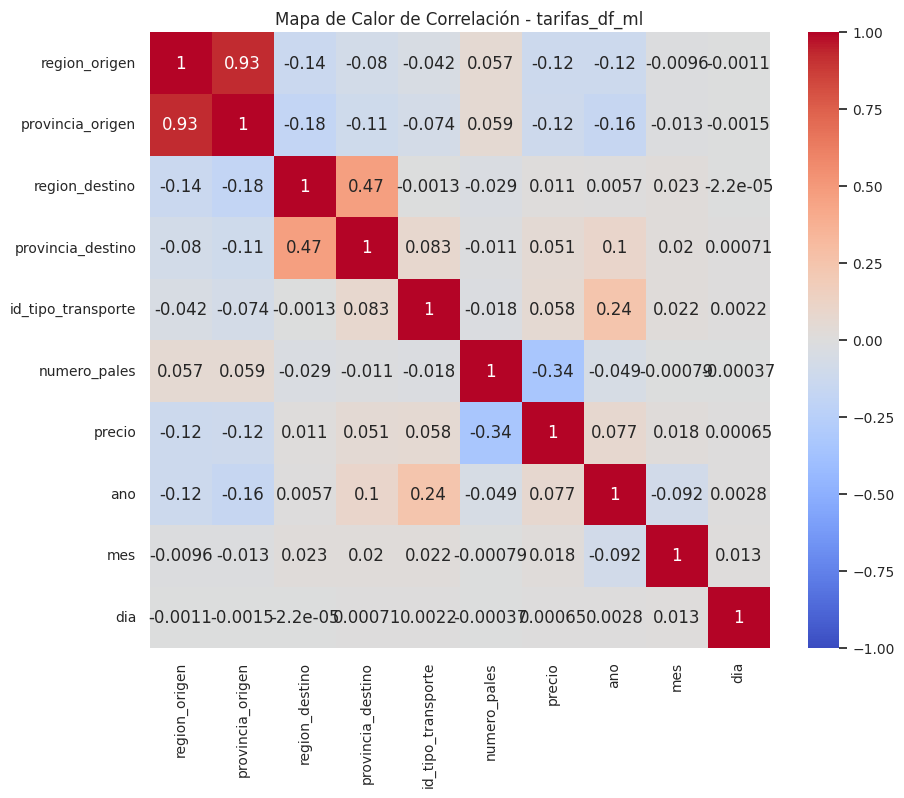

Matriz de correlación de tarifas_df_ml:
                    region_origen  provincia_origen  region_destino  \
region_origen            1.000000          0.928080       -0.139452   
provincia_origen         0.928080          1.000000       -0.184231   
region_destino          -0.139452         -0.184231        1.000000   
provincia_destino       -0.080170         -0.105945        0.469070   
id_tipo_transporte      -0.041855         -0.073680       -0.001275   
numero_pales             0.056615          0.059117       -0.029295   
precio                  -0.122184         -0.115610        0.011448   
ano                     -0.121473         -0.160514        0.005679   
mes                     -0.009604         -0.012691        0.022959   
dia                     -0.001112         -0.001469       -0.000022   

                    provincia_destino  id_tipo_transporte  numero_pales  \
region_origen               -0.080170           -0.041855      0.056615   
provincia_origen            

In [60]:
# Seleccionar solo columnas numéricas en tarifas_df_ml
num_cols_tarifas_ml = tarifas_df_ml.select_dtypes(include=['int64', 'float64']).columns
corr_tarifas_ml = tarifas_df_ml[num_cols_tarifas_ml].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_tarifas_ml, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Calor de Correlación - tarifas_df_ml")
plt.show()

# Mostrar la matriz de correlación
print("Matriz de correlación de tarifas_df_ml:")
print(corr_tarifas_ml)

**Región y Provincia de Origen:** La correlación entre region_origen y provincia_origen es extremadamente alta (0.93), lo que indica que estas dos variables están muy relacionadas. Esto es de esperarse ya que la provincia es una subdivisión de la región.

**Precio y número de palés:** Hay una correlación negativa moderada (-0.34) entre precio y numero_pales, lo que sugiere que el precio por palé disminuye a medida que el número de palés aumenta, como ya hemos observado antes.

**Tipo de Transporte y Año:** La correlación entre id_tipo_transporte y ano (0.24) sugiere que puede haber una evolución del tipo de transporte utilizado a lo largo de los años, aunque no es una relación extremadamente fuerte.

**Precio y Año:** Existe una correlación positiva baja (0.076) entre precio y ano, lo que indica que el precio ha aumentado ligeramente con el tiempo, aunque la relación es débil.

**Provincia de Destino y Región de Destino:** La correlación entre provincia_destino y region_destino (0.47) indica que también hay una fuerte relación entre la provincia y la región en el destino, lo cual es lógico ya que la provincia pertenece a una región más amplia.

En general, los patrones observados refuerzan las relaciones esperadas entre las variables de ubicación y las que están más directamente relacionadas con el número de palés y el precio. Las correlaciones entre el precio y el número de palés siguen siendo consistentes, sugiriendo que el volumen es un factor clave en las tarifas.

Para los dataframes de **series temporales**

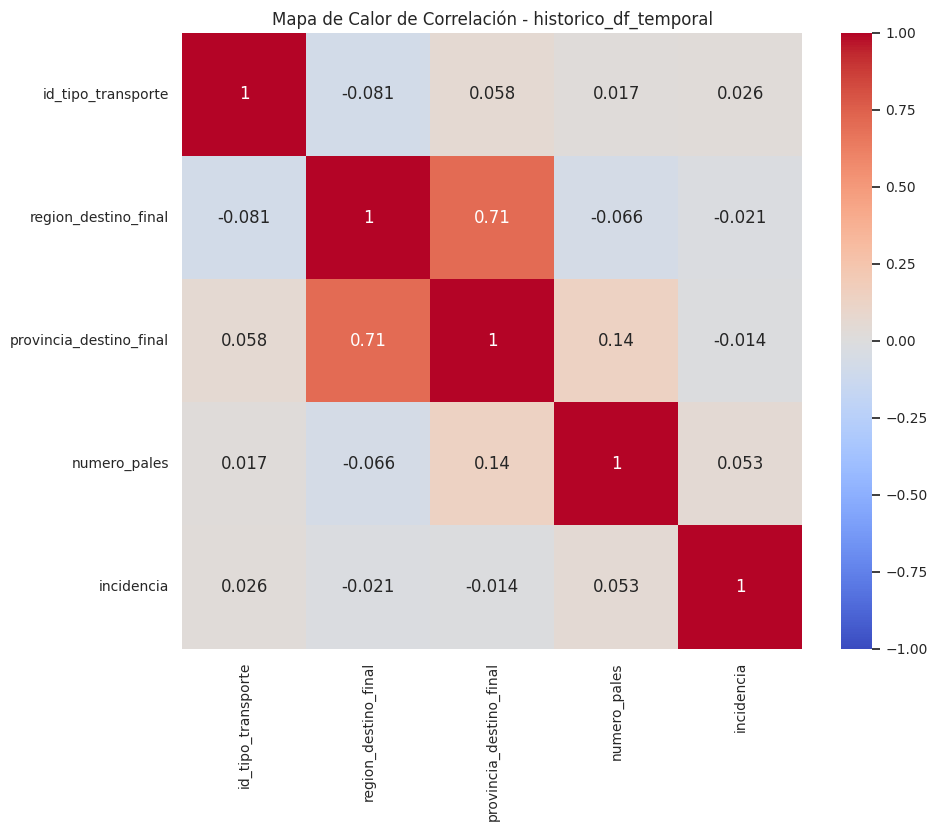

Matriz de correlación de historico_df_temporal:
                         id_tipo_transporte  region_destino_final  \
id_tipo_transporte                 1.000000             -0.081279   
region_destino_final              -0.081279              1.000000   
provincia_destino_final            0.057860              0.708573   
numero_pales                       0.017382             -0.066381   
incidencia                         0.026449             -0.021091   

                         provincia_destino_final  numero_pales  incidencia  
id_tipo_transporte                      0.057860      0.017382    0.026449  
region_destino_final                    0.708573     -0.066381   -0.021091  
provincia_destino_final                 1.000000      0.140350   -0.013750  
numero_pales                            0.140350      1.000000    0.052603  
incidencia                             -0.013750      0.052603    1.000000  


In [61]:
# Seleccionar solo columnas numéricas en historico_df_temporal
num_cols_historico_temporal = historico_df_temporal.select_dtypes(include=['int64', 'float64']).columns
corr_historico_temporal = historico_df_temporal[num_cols_historico_temporal].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_historico_temporal, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Calor de Correlación - historico_df_temporal")
plt.show()

# Mostrar la matriz de correlación
print("Matriz de correlación de historico_df_temporal:")
print(corr_historico_temporal)

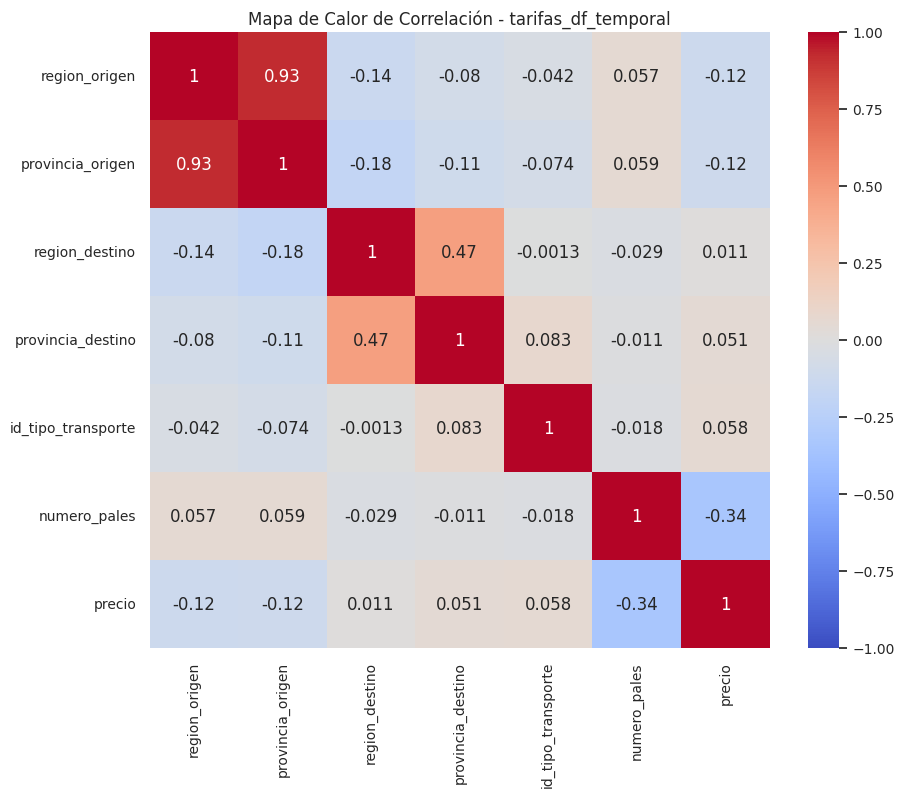

Matriz de correlación de tarifas_df_temporal:
                    region_origen  provincia_origen  region_destino  \
region_origen            1.000000          0.928080       -0.139452   
provincia_origen         0.928080          1.000000       -0.184231   
region_destino          -0.139452         -0.184231        1.000000   
provincia_destino       -0.080170         -0.105945        0.469070   
id_tipo_transporte      -0.041855         -0.073680       -0.001275   
numero_pales             0.056615          0.059117       -0.029295   
precio                  -0.122184         -0.115610        0.011448   

                    provincia_destino  id_tipo_transporte  numero_pales  \
region_origen               -0.080170           -0.041855      0.056615   
provincia_origen            -0.105945           -0.073680      0.059117   
region_destino               0.469070           -0.001275     -0.029295   
provincia_destino            1.000000            0.082884     -0.011252   
id_tipo_tr

In [62]:
# Seleccionar solo columnas numéricas en tarifas_df_temporal
num_cols_tarifas_temporal = tarifas_df_temporal.select_dtypes(include=['int64', 'float64']).columns
corr_tarifas_temporal = tarifas_df_temporal[num_cols_tarifas_temporal].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_tarifas_temporal, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Calor de Correlación - tarifas_df_temporal")
plt.show()

# Mostrar la matriz de correlación
print("Matriz de correlación de tarifas_df_temporal:")
print(corr_tarifas_temporal)

**historico_df_temporal**

**Región de destino y provincia de destino:** Hay una correlación alta (0.71) entre region_destino_final y provincia_destino_final, lo cual es de esperar ya que las provincias están ubicadas dentro de las regiones.

**Número de palés y provincia de destino:** Existe una correlación positiva moderada (0.14) entre numero_pales y provincia_destino_final, lo que podría indicar una cierta relación entre el destino final y la cantidad de palés transportados.

**Número de palés e incidencia:** La correlación es baja (0.053) pero positiva entre numero_pales e incidencia. Aunque es débil, puede sugerir que a medida que aumenta el número de palés, hay una ligera tendencia a que ocurra alguna incidencia.

**Tipo de transporte y otras variables:** La correlación de id_tipo_transporte con otras variables, como region_destino_final (-0.081) o provincia_destino_final (0.058), es muy baja, lo que sugiere que el tipo de transporte no está estrechamente relacionado con la región o la provincia de destino.

En general, las correlaciones en este dataframe refuerzan la idea de que las ubicaciones están relacionadas entre sí, mientras que las otras variables tienen correlaciones más débiles entre sí. No parece haber relaciones fuertes entre el tipo de transporte o la incidencia con otras variables en este conjunto de datos.

**tarifas_df_temporal**

**Región y provincia de origen:** Hay una correlación muy alta (0.93) entre region_origen y provincia_origen, lo cual es esperado dado que las provincias pertenecen a las regiones. Es un patrón lógico dentro de los datos geográficos.

**Número de palés y precio:** Existe una correlación negativa moderada (-0.34) entre numero_pales y precio. Esto sugiere que a medida que aumenta el número de palés, el precio tiende a disminuir, lo que podría estar relacionado con descuentos por volumen o economías de escala en los envíos.

**Región y provincia de destino:** Hay una correlación positiva moderada (0.47) entre region_destino y provincia_destino, lo cual es consistente con la relación esperada entre regiones y provincias dentro de ellas.

**Precio y otras variables:** El precio tiene correlaciones débiles con las demás variables, como region_destino (0.01) y provincia_destino (0.05), lo que indica que no hay una relación muy fuerte entre estas ubicaciones y el precio.

En general, el análisis muestra que las relaciones geográficas entre regiones y provincias son fuertes, mientras que las demás variables tienen correlaciones más débiles. El patrón más significativo es la relación negativa entre el número de palés y el precio.

**3.2 Visualización y descripción**

**3.2.1 Análisis de Patrones Temporales**

Exploraremos cómo las variables clave (precio, numero_pales) varían a lo largo del tiempo. Esto nos permitirá identificar tendencias estacionales o cambios a lo largo de los años.

Usaremos tarifas_df_temporal, tarifas_df_ml, ya que estas son las que contienen las variables clave precio y numero_pales a lo largo del tiempo.

**Gráfico para tarifas_df_temporal (con fecha en formato datetime):**

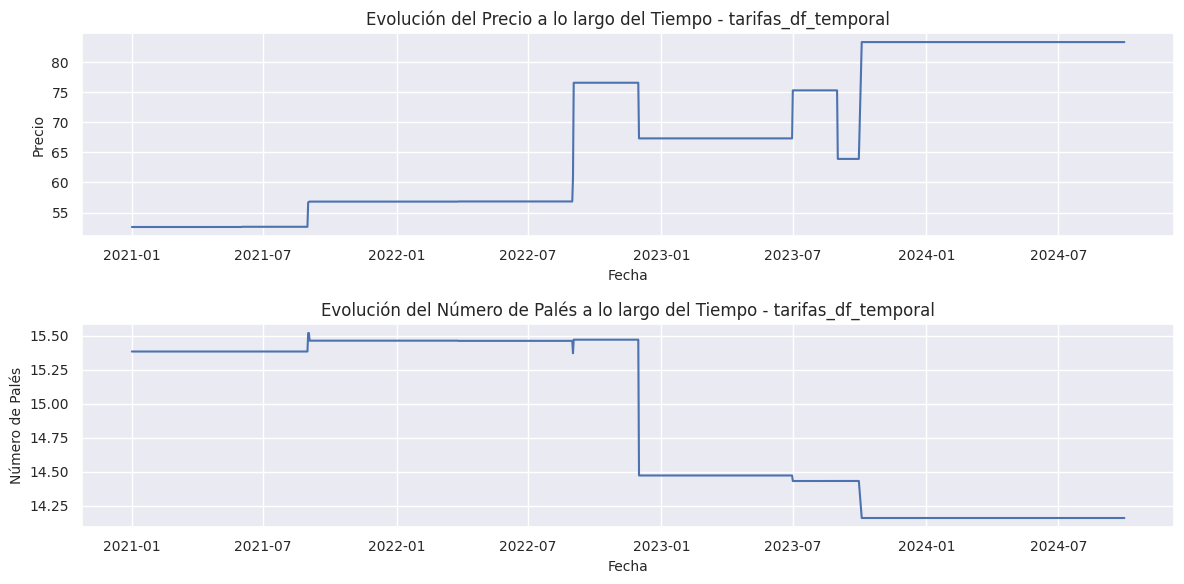

In [63]:
# Gráfico para tarifas_df_temporal
plt.figure(figsize=(12, 6))

# Evolución del precio a lo largo del tiempo
plt.subplot(2, 1, 1)
sns.lineplot(x='fecha', y='precio', data=tarifas_df_temporal, errorbar=None)
plt.title('Evolución del Precio a lo largo del Tiempo - tarifas_df_temporal')
plt.xlabel('Fecha')
plt.ylabel('Precio')

# Evolución del número de palés a lo largo del tiempo
plt.subplot(2, 1, 2)
sns.lineplot(x='fecha', y='numero_pales', data=tarifas_df_temporal, errorbar=None)
plt.title('Evolución del Número de Palés a lo largo del Tiempo - tarifas_df_temporal')
plt.xlabel('Fecha')
plt.ylabel('Número de Palés')

plt.tight_layout()
plt.show()

**Evolución del Precio:** Se perciben incrementos graduales en el precio a lo largo del tiempo, con algunos períodos de estabilidad y otros de fluctuaciones significativas. Esto podría indicar una tendencia a ajustar los precios en función de factores externos, como la demanda, los costos operativos o la estacionalidad.

**Evolución del Número de Palés:** El número de palés se mantiene relativamente estable durante un tiempo, pero presenta caídas notables en ciertos puntos. Estas variaciones pueden deberse a cambios en la demanda, la capacidad de carga o en políticas de distribución.

**Gráfico para tarifas_df_ml (con ano, mes, dia descompuestos):**

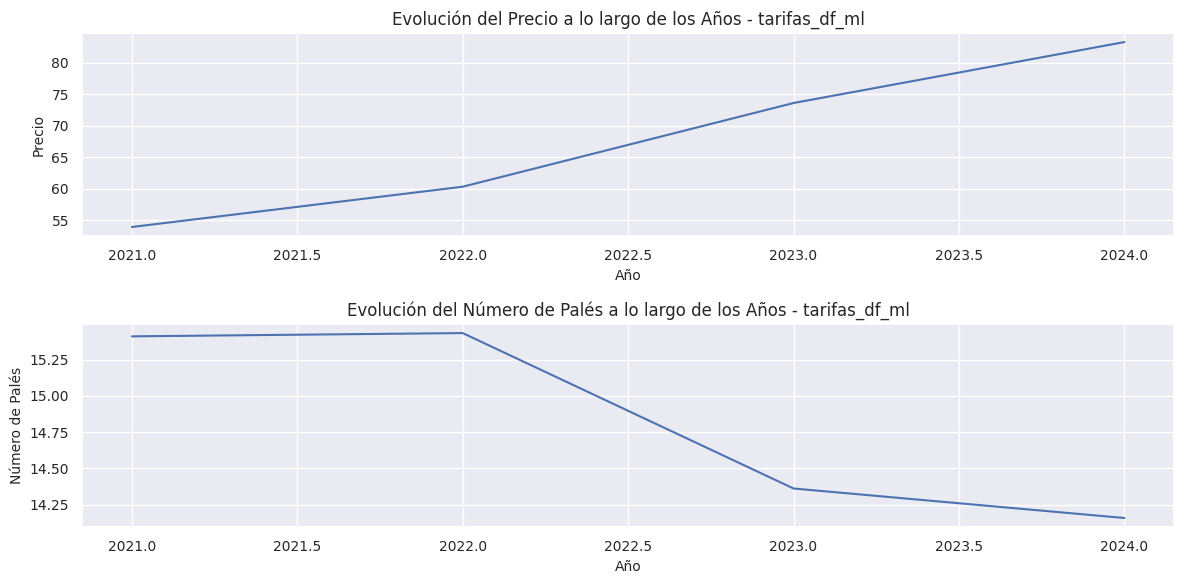

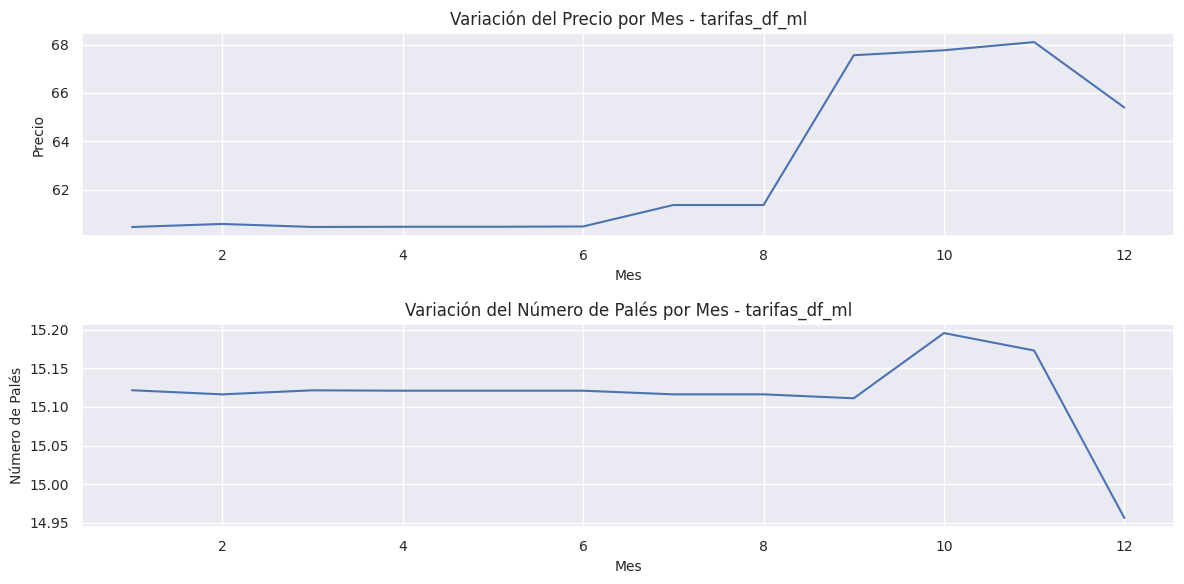

In [64]:
# Gráfico para tarifas_df_ml
plt.figure(figsize=(12, 6))

# Evolución del precio a lo largo de los años
plt.subplot(2, 1, 1)
sns.lineplot(x='ano', y='precio', data=tarifas_df_ml, errorbar=None)
plt.title('Evolución del Precio a lo largo de los Años - tarifas_df_ml')
plt.xlabel('Año')
plt.ylabel('Precio')

# Evolución del número de palés a lo largo de los años
plt.subplot(2, 1, 2)
sns.lineplot(x='ano', y='numero_pales', data=tarifas_df_ml, errorbar=None)
plt.title('Evolución del Número de Palés a lo largo de los Años - tarifas_df_ml')
plt.xlabel('Año')
plt.ylabel('Número de Palés')

plt.tight_layout()
plt.show()

# Análisis estacional por mes
plt.figure(figsize=(12, 6))

# Variación del precio por mes
plt.subplot(2, 1, 1)
sns.lineplot(x='mes', y='precio', data=tarifas_df_ml, errorbar=None)
plt.title('Variación del Precio por Mes - tarifas_df_ml')
plt.xlabel('Mes')
plt.ylabel('Precio')

# Variación del número de palés por mes
plt.subplot(2, 1, 2)
sns.lineplot(x='mes', y='numero_pales', data=tarifas_df_ml, errorbar=None)
plt.title('Variación del Número de Palés por Mes - tarifas_df_ml')
plt.xlabel('Mes')
plt.ylabel('Número de Palés')

plt.tight_layout()
plt.show()

**Evolución del Precio por Año:**

El gráfico muestra una clara tendencia ascendente del precio, especialmente desde 2021 hasta 2024, lo que puede sugerir un patrón de crecimiento anual.

**Evolución del Número de Palés por Año:**

El número de palés, en cambio, muestra una tendencia descendente constante a lo largo de los años, lo que sugiere una optimización o una reducción en la carga transportada.

**Variación del Precio por Mes:**

El precio tiene un comportamiento relativamente estable durante la mayor parte del año, pero muestra un notable aumento en los últimos meses (noviembre y diciembre). Esto podría reflejar patrones estacionales o aumento de la demanda en esos meses específicos.

**Variación del Número de Palés por Mes:**

Similar al precio, el número de palés muestra un incremento hacia los últimos meses del año, lo que podría correlacionarse con el aumento de demanda o la estacionalidad de ciertos productos.

**3.2.2 Análisis de Patrones Espaciales**

Después de analizar los patrones temporales, exploraremos cómo los precios varían según las provincias de origen y destino.

Para realizar el Análisis de Patrones Espaciales, donde se explora cómo varían los precios según las provincias de origen y destino, debemos hacerlo con los dataframes que contienen información tanto espacial (provincias) como de precios.

**Dataframes relevantes:**

**tarifas_df_cleaned:** Contiene datos limpios de tarifas y debe incluir información de las provincias de origen y destino.

**tarifas_df_temporal:** Contiene la dimensión temporal, pero también debe tener información espacial (provincias) y precios.

**tarifas_df_ml:** La versión para machine learning del dataframe de tarifas, que también contiene información de las provincias y precios.

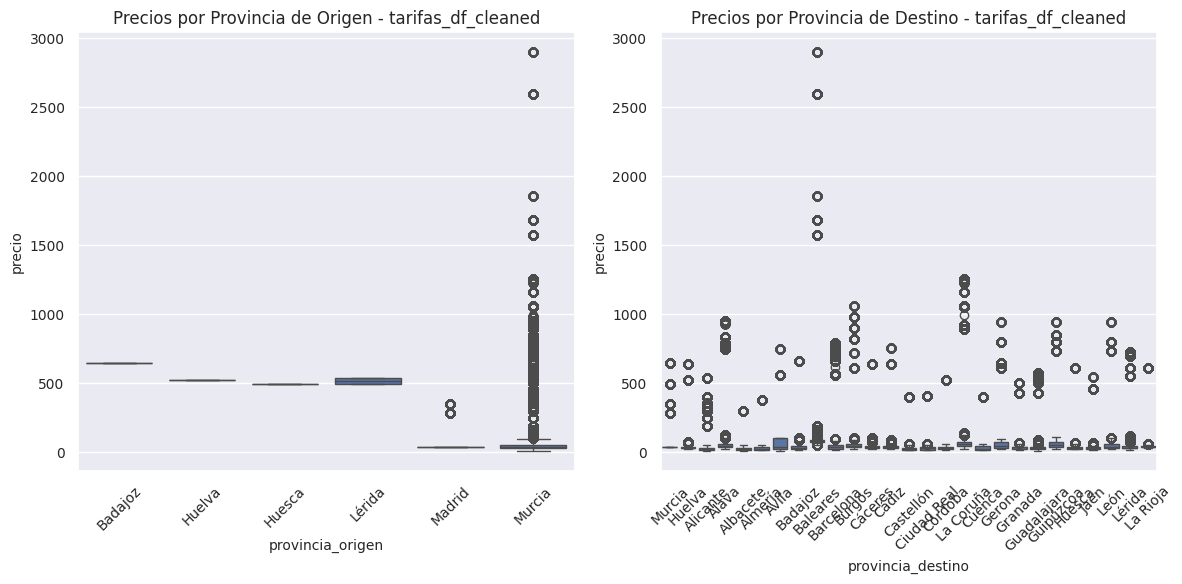

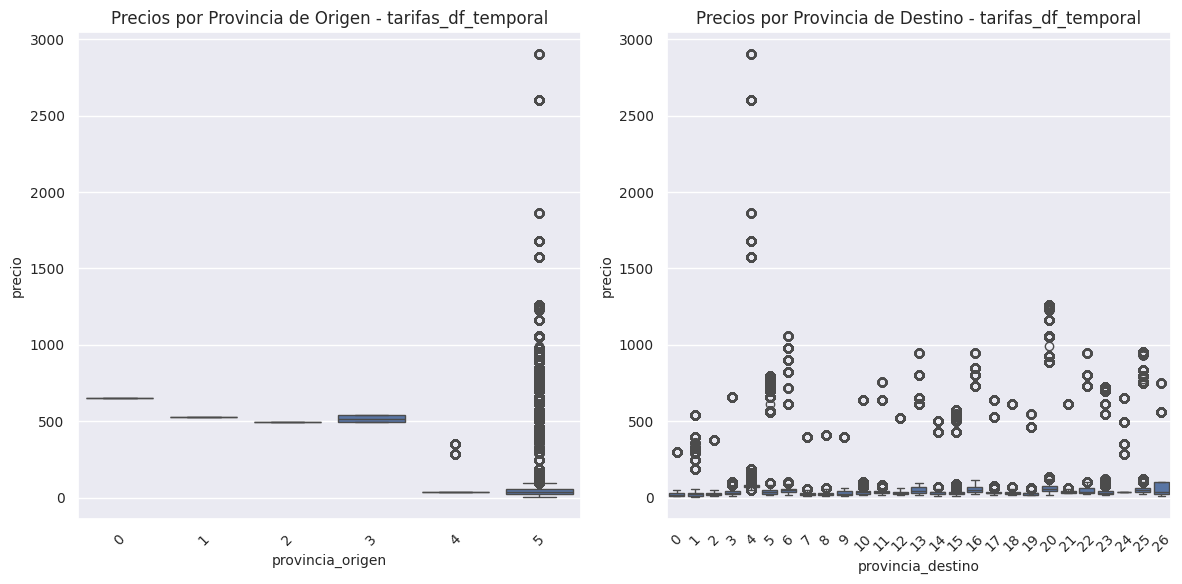

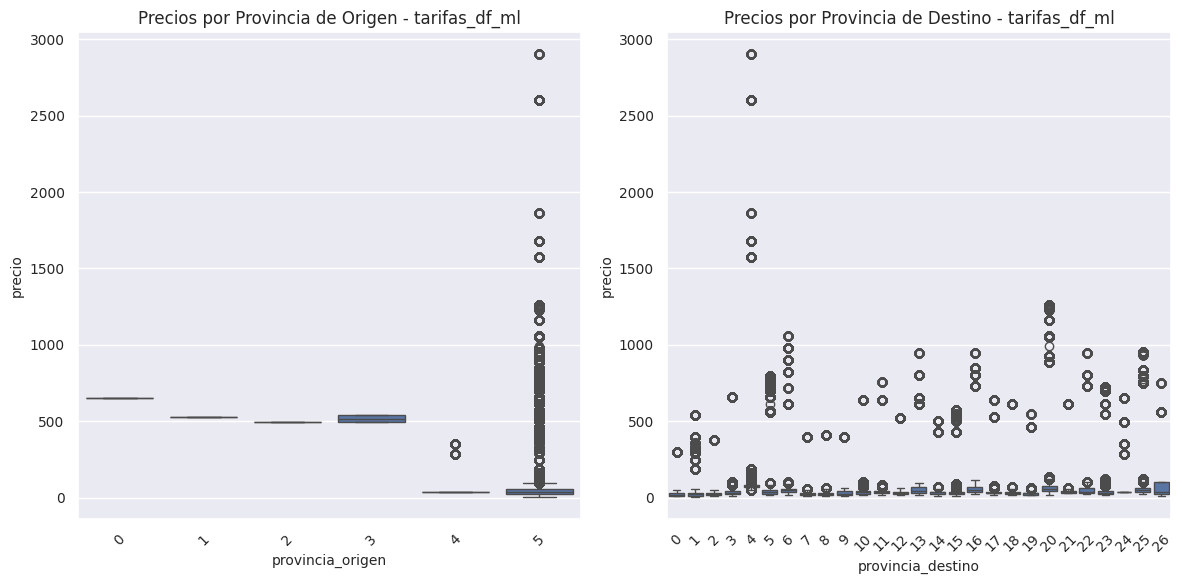

In [65]:
# Función para graficar los precios por provincias de origen y destino
def graficar_precios_provincias(df, nombre_df):
    plt.figure(figsize=(12, 6))

    # Gráfico de los precios por provincia de origen
    plt.subplot(1, 2, 1)
    sns.boxplot(x='provincia_origen', y='precio', data=df)
    plt.title(f'Precios por Provincia de Origen - {nombre_df}')
    plt.xticks(rotation=45)

    # Gráfico de los precios por provincia de destino
    plt.subplot(1, 2, 2)
    sns.boxplot(x='provincia_destino', y='precio', data=df)
    plt.title(f'Precios por Provincia de Destino - {nombre_df}')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Llamadas a la función para cada dataframe relevante
graficar_precios_provincias(tarifas_df_cleaned, 'tarifas_df_cleaned')
graficar_precios_provincias(tarifas_df_temporal, 'tarifas_df_temporal')
graficar_precios_provincias(tarifas_df_ml, 'tarifas_df_ml')

**Variación por Provincia de Origen:**

En los tres dataframes, notamos que ciertas provincias como Murcia y Lérida tienen una mayor dispersión de precios, mientras que otras como Huelva y Huesca tienen valores más consistentes y bajos.
Esto sugiere que provincias con mayor variabilidad en los precios podrían tener factores logísticos específicos o mayor demanda de transporte.

**Variación por Provincia de Destino:**

Las provincias de destino muestran una mayor variabilidad en comparación con las de origen. Algunas provincias tienen precios significativamente más altos, lo que puede estar relacionado con la distancia o el tipo de transporte necesario.
Las provincias como Murcia y Madrid destacan con precios más elevados en comparación con otras.


Estas observaciones pueden ayudar a identificar áreas clave donde los precios fluctúan más, lo cual puede ser útil en la planificación de estrategias de transporte o en la negociación de tarifas.

**3.2.3 Análisis de Distribuciones de Precios**

Ahora evaluaremos cómo los precios se distribuyen en función de diferentes categorías como tipo de transporte, provincia_destino.

**Dataframes relevantes para el análisis:**

**tarifas_df_cleaned:** Contiene las tarifas limpias y es adecuado para evaluar distribuciones de precios por categorías.

**tarifas_df_temporal:** Este incluye la variable temporal y puede mostrar la evolución en el tiempo, pero también sirve para analizar distribuciones por categorías.

**tarifas_df_ml:** Este dataframe ya contiene las variables descompuestas (año, mes, día) y también es útil para el análisis de distribuciones por categorías como el tipo de transporte.

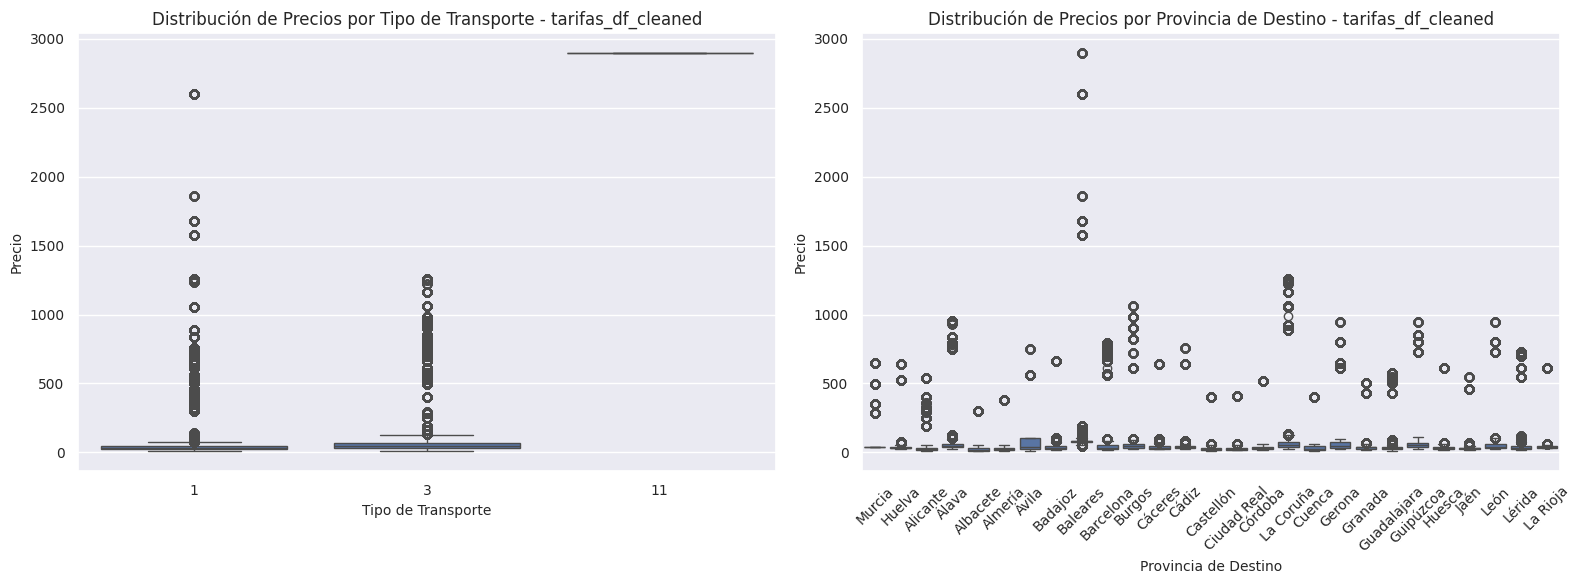

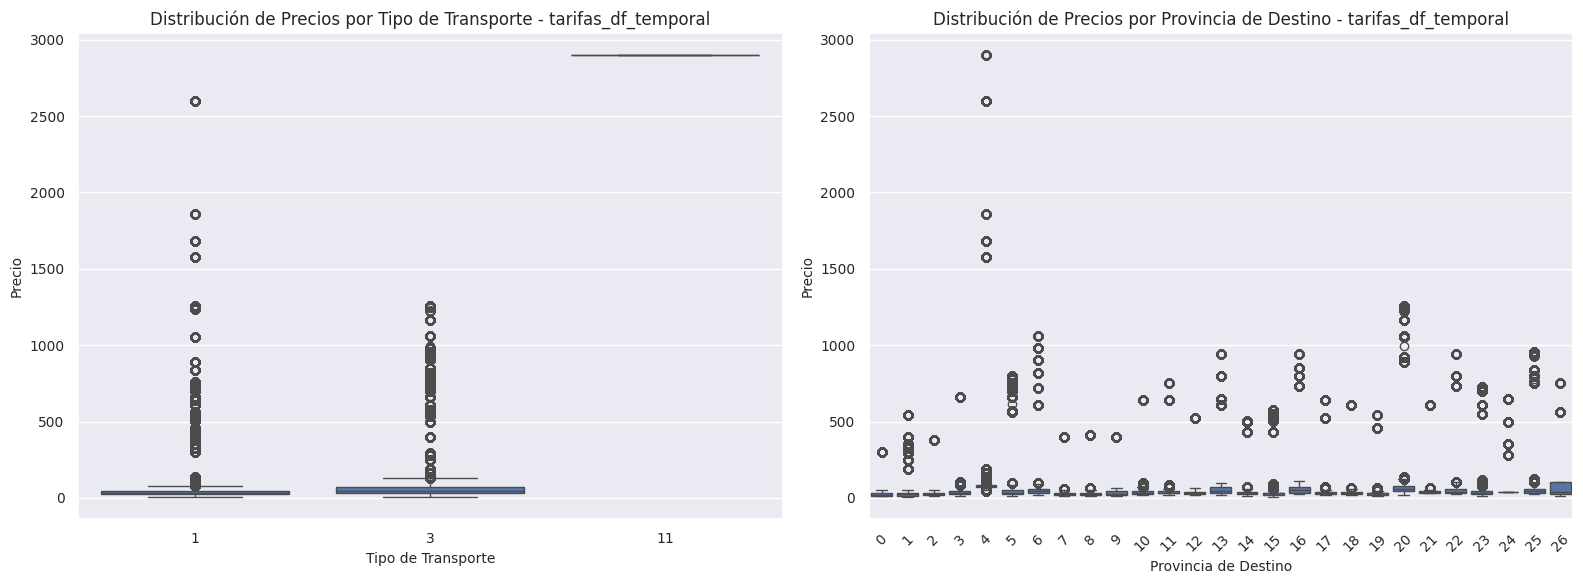

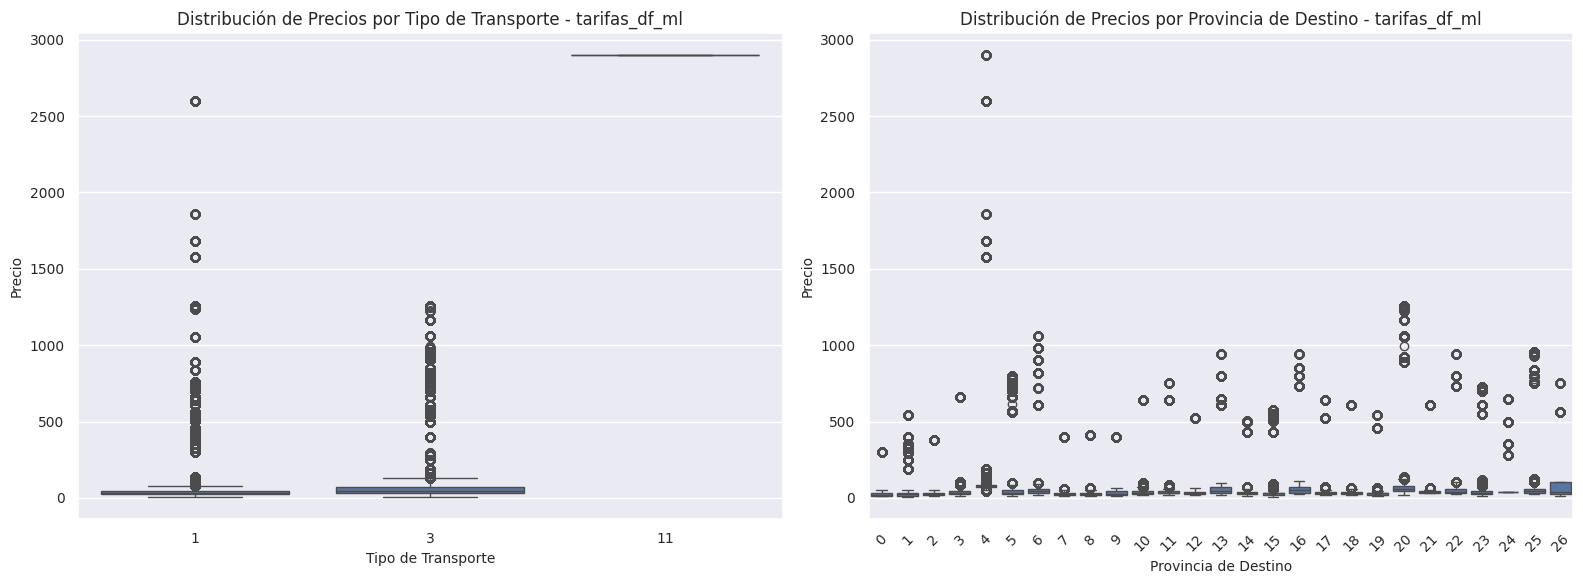

In [66]:
# Listado de dataframes y sus nombres
dataframes = [tarifas_df_cleaned, tarifas_df_temporal, tarifas_df_ml]
nombres = ['tarifas_df_cleaned', 'tarifas_df_temporal', 'tarifas_df_ml']

for i, df in enumerate(dataframes):
    plt.figure(figsize=(16, 6))

    # Distribución del precio por tipo de transporte
    plt.subplot(1, 2, 1)
    sns.boxplot(x='id_tipo_transporte', y='precio', data=df)
    plt.title(f'Distribución de Precios por Tipo de Transporte - {nombres[i]}')
    plt.xlabel('Tipo de Transporte')
    plt.ylabel('Precio')

    # Distribución del precio por provincia de destino
    plt.subplot(1, 2, 2)
    sns.boxplot(x='provincia_destino', y='precio', data=df)
    plt.title(f'Distribución de Precios por Provincia de Destino - {nombres[i]}')
    plt.xticks(rotation=45)
    plt.xlabel('Provincia de Destino')
    plt.ylabel('Precio')

    plt.tight_layout()
    plt.show()

**Distribución de Precios por Tipo de Transporte:**

Para tarifas_df_cleaned, tarifas_df_temporal y tarifas_df_ml, vemos que la mayoría de los precios están muy concentrados en un rango bajo, aunque hay algunos valores atípicos considerables en el tipo de transporte 1 y 3, que alcanzan precios bastante altos.
El tipo de transporte 11 parece tener valores muy elevados, aunque son muy pocos datos. Esto puede indicar que este tipo de transporte en particular se asocia con precios más elevados.

**Distribución de Precios por Provincia de Destino:**

En todos los dataframes, la distribución de precios varía considerablemente según la provincia de destino.
Observamos algunas provincias con valores mucho más altos que otras, como por ejemplo, Murcia, Barcelona, y Madrid, lo que podría deberse a factores logísticos específicos de estas regiones.
Muchas provincias tienen una mediana de precio baja y homogénea, pero existen algunas con gran variabilidad y valores atípicos altos, como en Barcelona y Murcia, donde los precios alcanzan cifras muy elevadas.

**4.- Modelado predictivo**

**4.1 Estimación de Volúmenes de Carga**

**Selección de características y variable objetivo**

In [67]:
# Variables predictoras y objetivo (numero_pales)
X = historico_df_ml.drop(columns=['numero_pales'])  # Excluye 'numero_pales' para predecirlo
y = historico_df_ml['numero_pales']  # Variable objetivo

**División de los datos en entrenamiento y prueba**

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**A.- Modelo de regresión lineal**

In [69]:
# Crear el modelo
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones sobre los datos de prueba
y_pred = model.predict(X_test)

In [70]:
# Evaluar el modelo usando métricas como MSE y R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-Squared: {r2}")

Mean Squared Error: 109.67801159779017
R-Squared: 0.08432702591775787


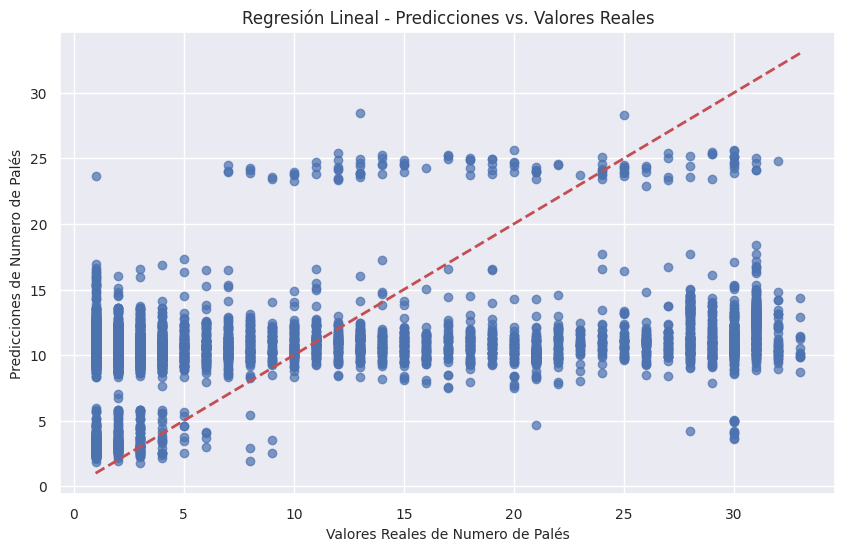

In [71]:
# Comparar predicciones con los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Valores Reales de Numero de Palés')
plt.ylabel('Predicciones de Numero de Palés')
plt.title('Regresión Lineal - Predicciones vs. Valores Reales')
plt.show()

Vemos que el R² es bastante bajo (0.08), lo que significa que el modelo de regresión lineal no está capturando bien la variabilidad en los datos de número de palés. Además, el MSE (error cuadrático medio) también es elevado, lo que indica que las predicciones están lejos de los valores reales en términos absolutos.

**B.- Random Forest**

In [72]:
# Crear el modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Hacer predicciones con los datos de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo usando MSE y R2
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R-Squared: {r2_rf}")

Random Forest - Mean Squared Error: 70.77055145607335
Random Forest - R-Squared: 0.4091552136551616


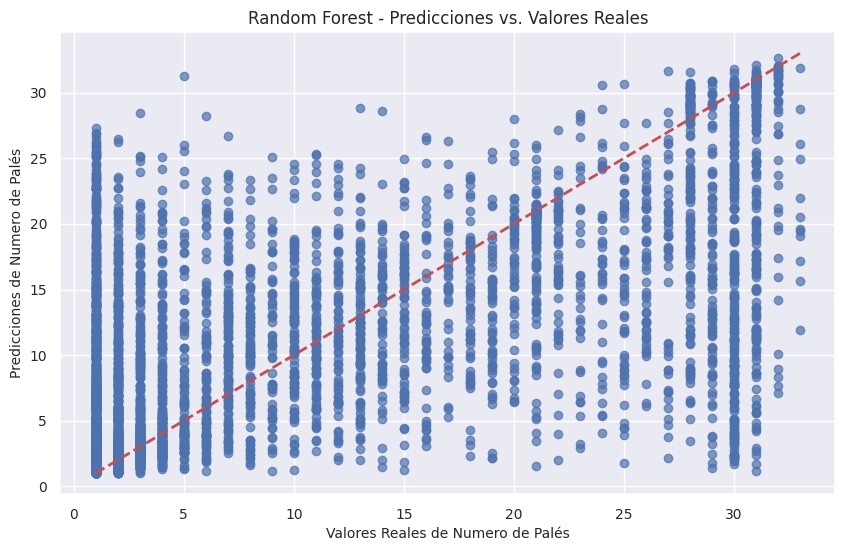

In [73]:
# Visualización de resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Valores Reales de Numero de Palés')
plt.ylabel('Predicciones de Numero de Palés')
plt.title('Random Forest - Predicciones vs. Valores Reales')
plt.show()

Muestran una mejora considerable con respecto a la regresión lineal, tanto en el MSE (70.77 vs 109.68) como en el R² (0.41 vs 0.08). Esto sugiere que el modelo de Random Forest está capturando más variabilidad en los datos de número de palés.

**C.- Gradient Boosting (GBM)**

In [74]:
# Crear el modelo de Gradient Boosting
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
gbm_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_gbm = gbm_model.predict(X_test)

# Evaluar el modelo
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

print(f"Gradient Boosting - Mean Squared Error: {mse_gbm}")
print(f"Gradient Boosting - R-Squared: {r2_gbm}")

Gradient Boosting - Mean Squared Error: 73.75082591643732
Gradient Boosting - R-Squared: 0.3842736832650008


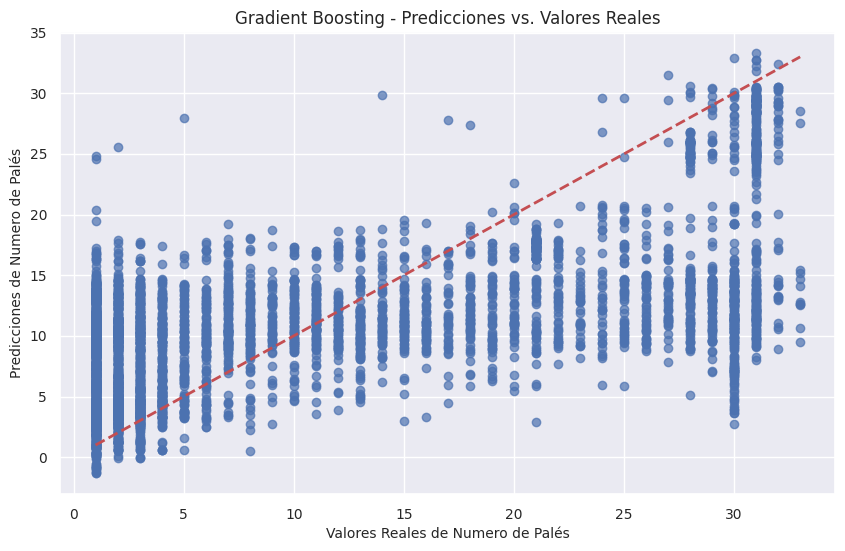

In [75]:
# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gbm, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Valores Reales de Numero de Palés')
plt.ylabel('Predicciones de Numero de Palés')
plt.title('Gradient Boosting - Predicciones vs. Valores Reales')
plt.show()

**D.- XGBoost**

In [76]:
import xgboost as xgb

# Crear el modelo de XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el modelo
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R-Squared: {r2_xgb}")

XGBoost - Mean Squared Error: 60.96271520842742
XGBoost - R-Squared: 0.49103826801912787


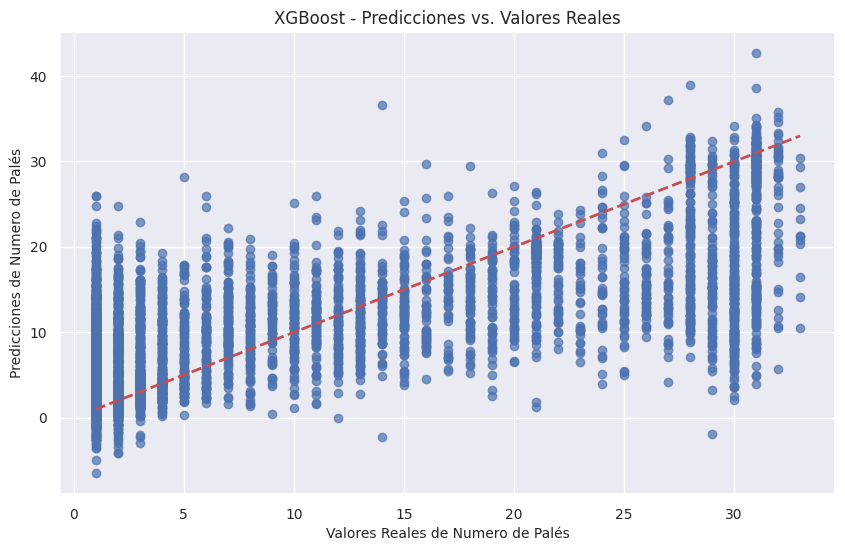

In [77]:
# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Valores Reales de Numero de Palés')
plt.ylabel('Predicciones de Numero de Palés')
plt.title('XGBoost - Predicciones vs. Valores Reales')
plt.show()

**E.- LightGBM**

In [78]:
import lightgbm as lgb

# Crear el modelo de LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
lgb_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_lgb = lgb_model.predict(X_test)

# Evaluar el modelo
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM - Mean Squared Error: {mse_lgb}")
print(f"LightGBM - R-Squared: {r2_lgb}")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 19548, number of used features: 8
[LightGBM] [Info] Start training from score 10.605740
LightGBM - Mean Squared Error: 61.063489428369266
LightGBM - R-Squared: 0.49019693046804824


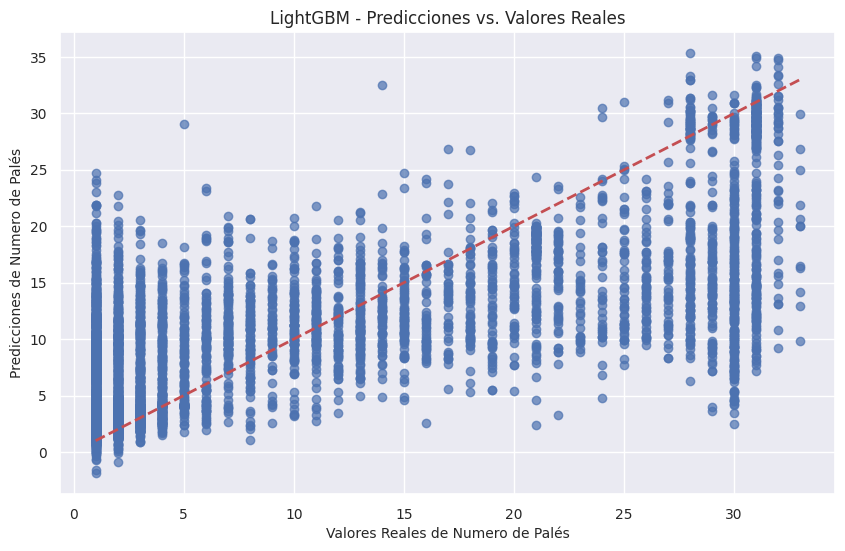

In [79]:
# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lgb, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Valores Reales de Numero de Palés')
plt.ylabel('Predicciones de Numero de Palés')
plt.title('LightGBM - Predicciones vs. Valores Reales')
plt.show()

**F.- CatBoost**

In [80]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [81]:
from catboost import CatBoostRegressor

# Crear el modelo de CatBoost
cat_model = CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)

# Entrenar el modelo
cat_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_cat = cat_model.predict(X_test)

# Evaluar el modelo
mse_cat = mean_squared_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print(f"CatBoost - Mean Squared Error: {mse_cat}")
print(f"CatBoost - R-Squared: {r2_cat}")

CatBoost - Mean Squared Error: 60.98022633427025
CatBoost - R-Squared: 0.49089207221883535


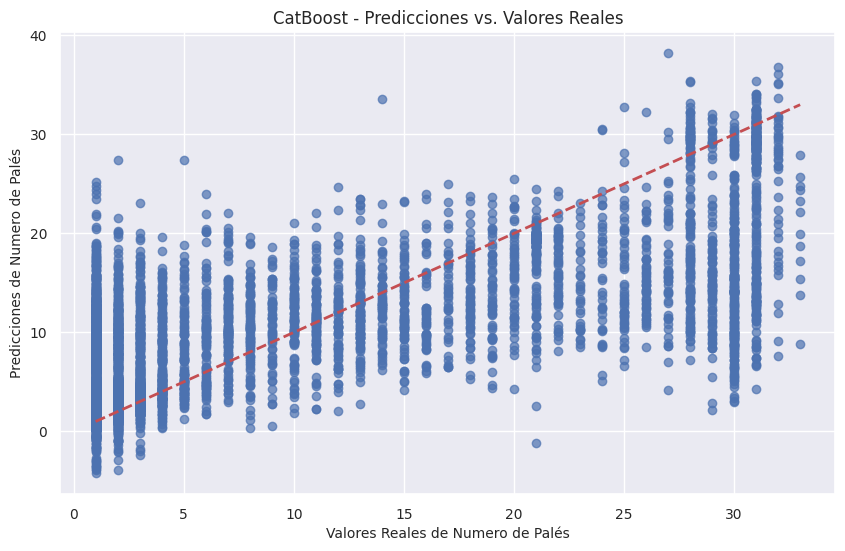

In [82]:
# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_cat, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Valores Reales de Numero de Palés')
plt.ylabel('Predicciones de Numero de Palés')
plt.title('CatBoost - Predicciones vs. Valores Reales')
plt.show()

**Ahora vamos a intentar con Series Temporales**

**G.- ARIMA**

In [83]:
# Asegurarse de que la columna de fecha esté correctamente configurada como índice
historico_df_temporal.set_index('fecha_real_carga', inplace=True)

# Seleccionar la columna que queremos predecir
serie = historico_df_temporal['numero_pales']

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(serie) * 0.8)
train, test = serie[:train_size], serie[train_size:]

# Ajustar el modelo ARIMA
arima_model = ARIMA(train, order=(5, 1, 0))  # Puedes ajustar los hiperparámetros (p, d, q)
arima_model_fit = arima_model.fit()

# Hacer predicciones
predictions = arima_model_fit.forecast(steps=len(test))

# Evaluar el modelo
mse_arima = mean_squared_error(test, predictions)
r2_arima = r2_score(test, predictions)

print(f"ARIMA - Mean Squared Error: {mse_arima}")
print(f"ARIMA - R-Squared: {r2_arima}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

ARIMA - Mean Squared Error: 0.0
ARIMA - R-Squared: 1.0


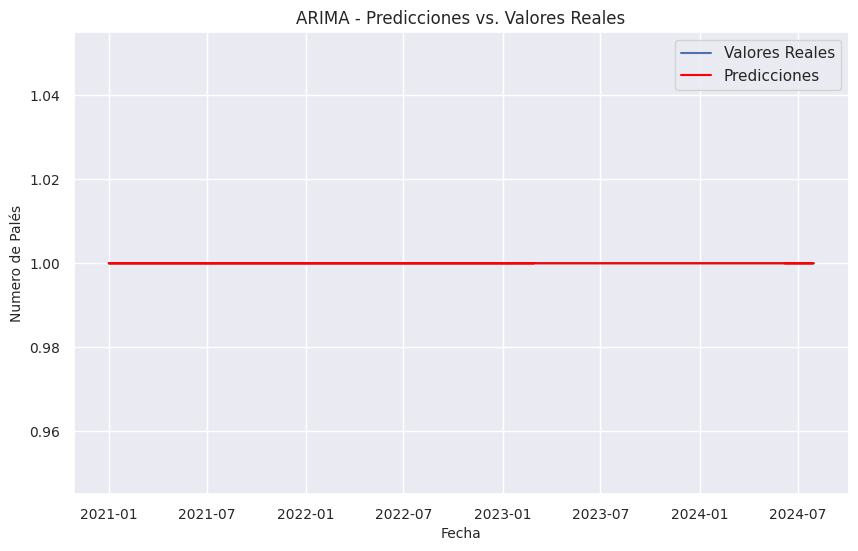

In [84]:
# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Valores Reales')
plt.plot(test.index, predictions, label='Predicciones', color='red')
plt.title('ARIMA - Predicciones vs. Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Numero de Palés')
plt.legend()
plt.show()

Refinar el modelo ARIMA

In [85]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.1 MB/s eta 0:00:00


In [86]:
from pmdarima import auto_arima

# Seleccionar la columna que queremos predecir (numero_pales)
serie = historico_df_temporal['numero_pales']

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(serie) * 0.8)
train, test = serie[:train_size], serie[train_size:]

# Auto ARIMA buscará los mejores parámetros para el modelo ARIMA
auto_model = auto_arima(train, start_p=0, start_q=0, max_p=3, max_q=3, seasonal=False, trace=True)

# Ver los mejores parámetros seleccionados
print(auto_model.summary())

# Hacer predicciones
predictions = auto_model.predict(n_periods=len(test))

# Evaluar el modelo
mse_auto_arima = mean_squared_error(test, predictions)
r2_auto_arima = r2_score(test, predictions)

print(f"Auto ARIMA - Mean Squared Error: {mse_auto_arima}")
print(f"Auto ARIMA - R-Squared: {r2_auto_arima}")

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-56362.086, Time=9.34 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-61982.832, Time=4.18 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=42.62 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-56364.087, Time=4.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-64282.784, Time=6.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-65542.060, Time=6.61 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-69122.555, Time=58.40 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=85.80 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-69520.303, Time=75.81 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=102.93 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=-69575.746, Time=107.30 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=102.79 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=28.68 sec

Best model:  ARIMA(3,2,3)(0,0,0)[0] intercept
Total fit time: 634.608 seconds
                  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Parece que auto_arima ha encontrado un modelo ARIMA con los parámetros óptimos: ARIMA(3,2,3), con los valores más ajustados a partir de la búsqueda que realice. Los resultados muestran que este modelo tiene un AIC bastante bajo, lo que indica un buen ajuste al conjunto de entrenamiento.

Dado que los mejores modelos hasta ahora han sido XGBoost y CatBoost, el siguiente paso sería realizar **ajustes de hiperparámetros** para mejorar su rendimiento. El proceso de ajuste de hiperparámetros se puede realizar utilizando técnicas como GridSearchCV o RandomizedSearchCV, dependiendo de cuántas combinaciones quieras probar y el tiempo que tengas disponible.

**Para XGBoost:**

In [87]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Definir el modelo
xgb_model = xgb.XGBRegressor(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Crear el RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV
random_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print(f"Mejores parámetros para XGBoost: {random_search.best_params_}")

# Predecir con el modelo optimizado
best_xgb_model = random_search.best_estimator_
xgb_predictions = best_xgb_model.predict(X_test)

# Evaluar el rendimiento
mse_xgb_optimized = mean_squared_error(y_test, xgb_predictions)
r2_xgb_optimized = r2_score(y_test, xgb_predictions)

print(f"XGBoost Optimizado - Mean Squared Error: {mse_xgb_optimized}")
print(f"XGBoost Optimizado - R-Squared: {r2_xgb_optimized}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores parámetros para XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
XGBoost Optimizado - Mean Squared Error: 59.89116653739048
XGBoost Optimizado - R-Squared: 0.4999843470388722


**Para CatBoost:**

In [88]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

# Definir el modelo
cat_model = CatBoostRegressor(random_state=42, verbose=0)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7, 9],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Crear el RandomizedSearchCV
random_search_cat = RandomizedSearchCV(cat_model, param_distributions=param_grid, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV
random_search_cat.fit(X_train, y_train)

# Mostrar los mejores parámetros
print(f"Mejores parámetros para CatBoost: {random_search_cat.best_params_}")

# Predecir con el modelo optimizado
best_cat_model = random_search_cat.best_estimator_
cat_predictions = best_cat_model.predict(X_test)

# Evaluar el rendimiento
mse_cat_optimized = mean_squared_error(y_test, cat_predictions)
r2_cat_optimized = r2_score(y_test, cat_predictions)

print(f"CatBoost Optimizado - Mean Squared Error: {mse_cat_optimized}")
print(f"CatBoost Optimizado - R-Squared: {r2_cat_optimized}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores parámetros para CatBoost: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 7}
CatBoost Optimizado - Mean Squared Error: 59.33089436663689
CatBoost Optimizado - R-Squared: 0.504661912554655


**Paso 1: Comparación de Modelos**

Podemos visualizar los errores de predicción de los modelos y comparar los resultados. Aquí va el código para que puedas ejecutar la comparación.

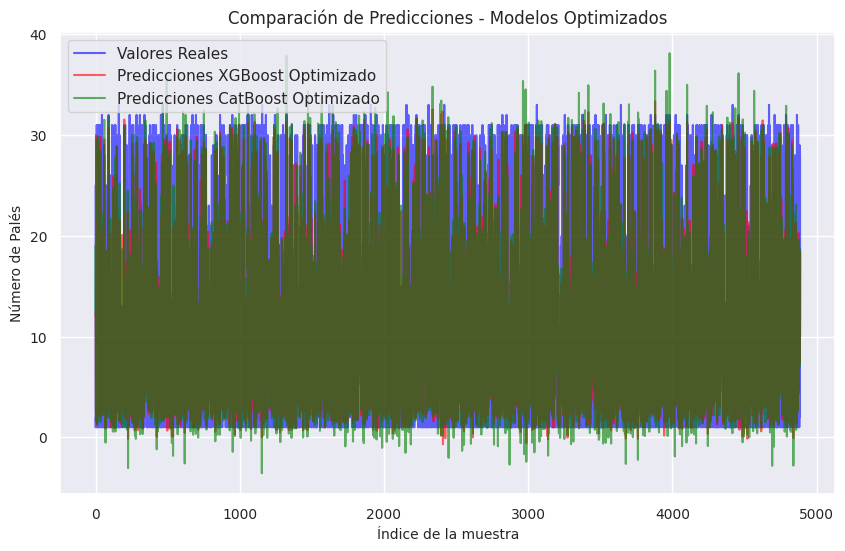

XGBoost Optimizado - Mean Squared Error: 59.89116653739048, R-Squared: 0.4999843470388722
CatBoost Optimizado - Mean Squared Error: 59.33089436663689, R-Squared: 0.504661912554655


In [89]:
# Comparación visual entre las predicciones de los modelos optimizados y los valores reales
plt.figure(figsize=(10, 6))

plt.plot(y_test.values, label='Valores Reales', color='blue', alpha=0.6)
plt.plot(xgb_predictions, label='Predicciones XGBoost Optimizado', color='red', alpha=0.6)
plt.plot(cat_predictions, label='Predicciones CatBoost Optimizado', color='green', alpha=0.6)

plt.title('Comparación de Predicciones - Modelos Optimizados')
plt.xlabel('Índice de la muestra')
plt.ylabel('Número de Palés')
plt.legend()
plt.show()

# Mostrar las métricas comparadas
print(f"XGBoost Optimizado - Mean Squared Error: {mse_xgb_optimized}, R-Squared: {r2_xgb_optimized}")
print(f"CatBoost Optimizado - Mean Squared Error: {mse_cat_optimized}, R-Squared: {r2_cat_optimized}")

**Paso 2: Ensemble de Modelos**

Ensemble XGBoost + CatBoost - Mean Squared Error: 59.10841063347539
Ensemble XGBoost + CatBoost - R-Squared: 0.5065193709336052


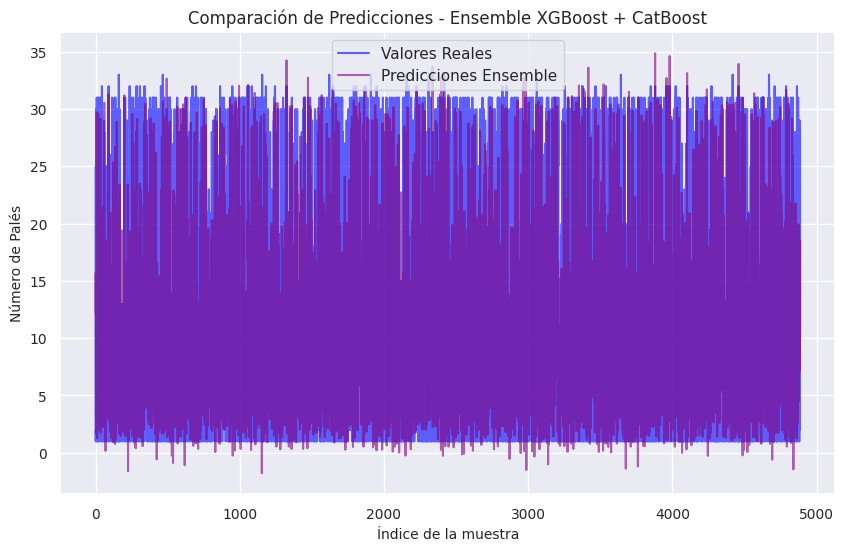

In [90]:
# Ensemble de XGBoost y CatBoost (promedio de sus predicciones)
ensemble_predictions = (xgb_predictions + cat_predictions) / 2

# Evaluar el ensemble
mse_ensemble = mean_squared_error(y_test, ensemble_predictions)
r2_ensemble = r2_score(y_test, ensemble_predictions)

print(f"Ensemble XGBoost + CatBoost - Mean Squared Error: {mse_ensemble}")
print(f"Ensemble XGBoost + CatBoost - R-Squared: {r2_ensemble}")

# Graficar las predicciones del ensemble vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores Reales', color='blue', alpha=0.6)
plt.plot(ensemble_predictions, label='Predicciones Ensemble', color='purple', alpha=0.6)
plt.title('Comparación de Predicciones - Ensemble XGBoost + CatBoost')
plt.xlabel('Índice de la muestra')
plt.ylabel('Número de Palés')
plt.legend()
plt.show()

**Paso 3: Análisis de Residuos**

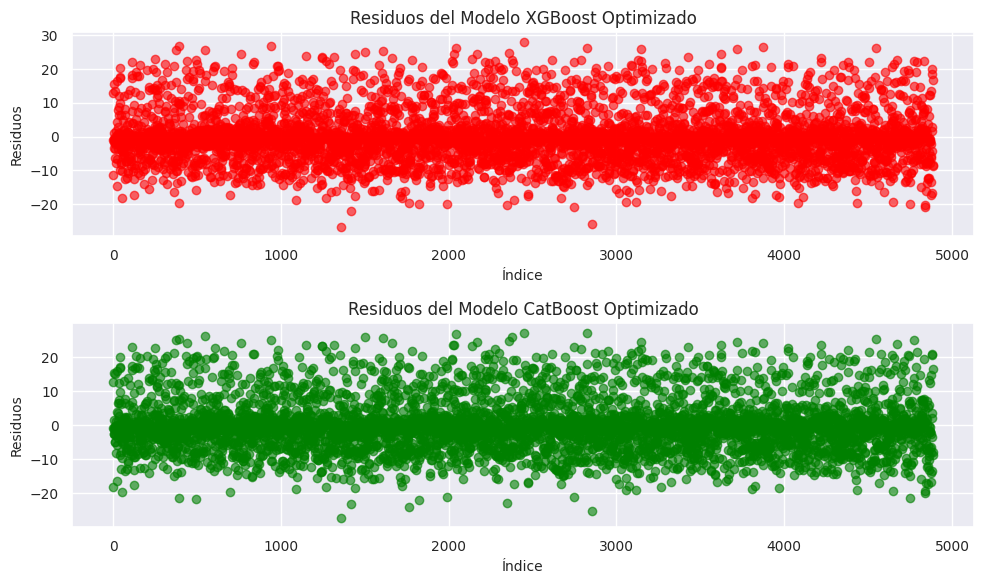

In [91]:
# Calcular los residuos para ambos modelos
residuos_xgb = y_test - xgb_predictions
residuos_cat = y_test - cat_predictions

# Graficar los residuos
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.scatter(range(len(residuos_xgb)), residuos_xgb, alpha=0.6, color='red')
plt.title('Residuos del Modelo XGBoost Optimizado')
plt.xlabel('Índice')
plt.ylabel('Residuos')

plt.subplot(2, 1, 2)
plt.scatter(range(len(residuos_cat)), residuos_cat, alpha=0.6, color='green')
plt.title('Residuos del Modelo CatBoost Optimizado')
plt.xlabel('Índice')
plt.ylabel('Residuos')

plt.tight_layout()
plt.show()

**Documentación e interpretación de los modelos**

**Estimación del Volumen de Cargas - Documentación de Modelos**

*Modelos Probados:*

Se evaluaron varios modelos de regresión para predecir la variable objetivo número_pales, que representa el volumen de carga. Los siguientes modelos fueron probados:

**Regresión Lineal:**

Mean Squared Error (MSE): 109.678
R-Squared (R²): 0.084
Interpretación: Este modelo muestra un ajuste muy pobre, lo que indica que no captura la complejidad de los datos de manera adecuada.

**Random Forest:**

Mean Squared Error (MSE): 70.771
R-Squared (R²): 0.409
Interpretación: Mejora considerable respecto a la regresión lineal, pero aún existen patrones que no captura correctamente.

**Gradient Boosting:**

Mean Squared Error (MSE): 73.751
R-Squared (R²): 0.384
Interpretación: Resultado similar a Random Forest, pero con un ligero rendimiento inferior.

**XGBoost:**

Mean Squared Error (MSE): 60.963
R-Squared (R²): 0.491
Interpretación: XGBoost muestra un rendimiento sólido, capturando mejor la complejidad de los datos.

**LightGBM:**

Mean Squared Error (MSE): 61.063
R-Squared (R²): 0.490
Interpretación: Similar a XGBoost, muestra un buen ajuste, aunque con diferencias mínimas.

**CatBoost:**

Mean Squared Error (MSE): 60.980
R-Squared (R²): 0.491
Interpretación: Similar a XGBoost y LightGBM en cuanto al rendimiento.

**Optimización de Hiperparámetros:**
Se realizaron búsquedas de hiperparámetros para los modelos con mejor rendimiento, resultando en las siguientes configuraciones óptimas:

**XGBoost Optimizado:**

Parámetros Óptimos: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
MSE Optimizado: 59.891
R² Optimizado: 0.500

**CatBoost Optimizado:**

Parámetros Óptimos: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 7}
MSE Optimizado: 59.331
R² Optimizado: 0.505

**Modelo Ensemble:**
Dado que los mejores modelos fueron XGBoost y CatBoost, se decidió probar un ensemble entre ambos, logrando los siguientes resultados:

MSE Ensemble: 59.108
R² Ensemble: 0.507

El modelo ensemble es el mejor en cuanto a rendimiento. A pesar de ser una mejora ligera sobre los modelos individuales, proporciona el mejor ajuste general.

El análisis de los residuos de los modelos optimizados mostró una distribución aproximadamente homogénea, lo cual indica que los modelos no presentan sesgos significativos.

**Guardar el Modelo Optimizado**

In [92]:
import pickle

# Guardar el modelo de CatBoost optimizado
with open('catboost_model_volumen.pkl', 'wb') as file:
    pickle.dump(best_cat_model, file)

print("Modelo de volumen de carga guardado exitosamente.")

Modelo de volumen de carga guardado exitosamente.


**4.2 Estimación de la Evolución de las Tarifas**

**Selección de Características**

In [93]:
# Seleccionar características predictoras y objetivo
X_tarifas = tarifas_df_ml.drop(columns=['precio'])
y_tarifas = tarifas_df_ml['precio']

**División de los datos en entrenamiento y prueba**

In [94]:
# División entre entrenamiento y prueba
X_train_tarifas, X_test_tarifas, y_train_tarifas, y_test_tarifas = train_test_split(X_tarifas, y_tarifas, test_size=0.2, random_state=42)

**A.- Regresión Lineal**

In [95]:
# Crear el modelo de Regresión Lineal
linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(X_train_tarifas, y_train_tarifas)

# Hacer predicciones en el conjunto de prueba
linear_predictions = linear_model.predict(X_test_tarifas)

# Calcular el MSE y el R2
mse_linear = mean_squared_error(y_test_tarifas, linear_predictions)
r2_linear = r2_score(y_test_tarifas, linear_predictions)

# Imprimir los resultados
print(f"Regresión Lineal - Mean Squared Error: {mse_linear}")
print(f"Regresión Lineal - R-Squared: {r2_linear}")

Regresión Lineal - Mean Squared Error: 15769.540502803966
Regresión Lineal - R-Squared: 0.13273017525926545


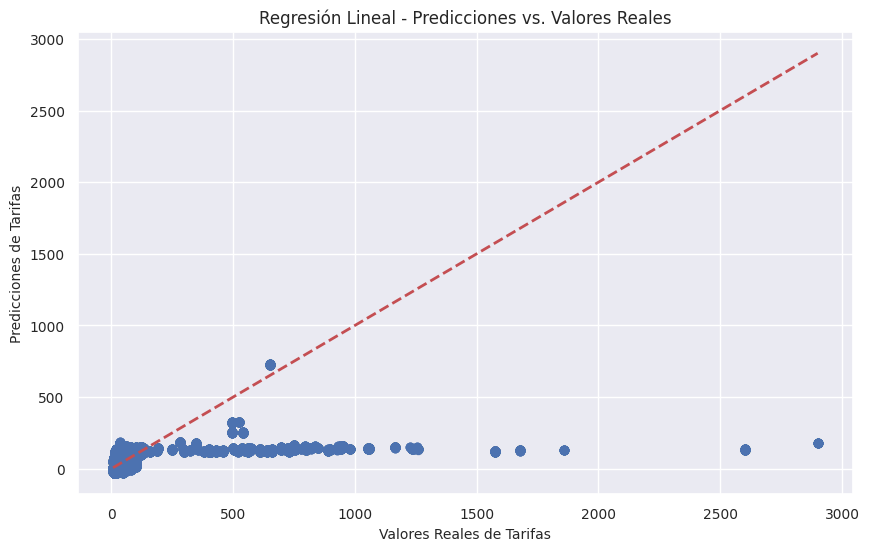

In [96]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tarifas, linear_predictions, alpha=0.5, color='b')
plt.plot([y_test_tarifas.min(), y_test_tarifas.max()], [y_test_tarifas.min(), y_test_tarifas.max()], 'r--', lw=2)
plt.xlabel('Valores Reales de Tarifas')
plt.ylabel('Predicciones de Tarifas')
plt.title('Regresión Lineal - Predicciones vs. Valores Reales')
plt.show()

**B.- Random Forest**

In [97]:
# Crear el modelo
rf_model = RandomForestRegressor(random_state=42)

# Entrenar el modelo
rf_model.fit(X_train_tarifas, y_train_tarifas)

# Hacer predicciones
rf_predictions = rf_model.predict(X_test_tarifas)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test_tarifas, rf_predictions)
r2_rf = r2_score(y_test_tarifas, rf_predictions)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R-Squared: {r2_rf}")

Random Forest - Mean Squared Error: 0.0680374058060874
Random Forest - R-Squared: 0.9999962581795583


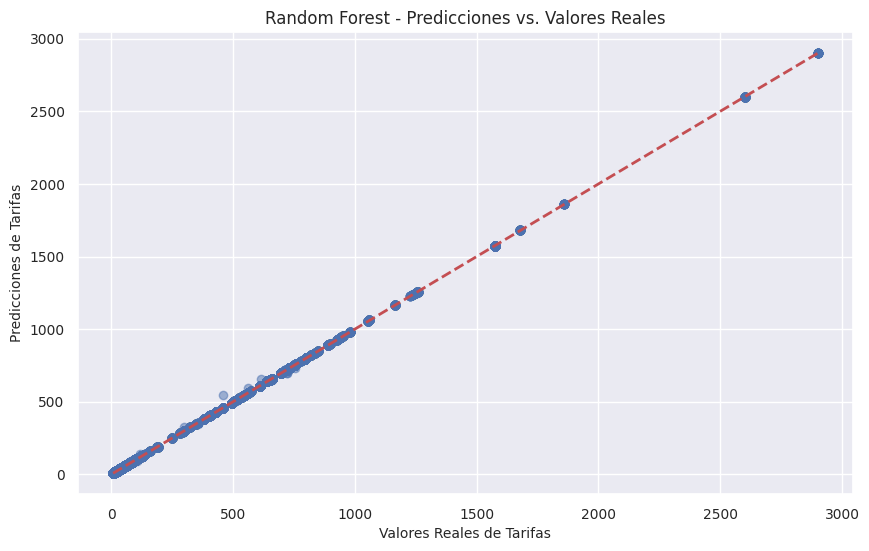

In [98]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tarifas, rf_predictions, alpha=0.5)
plt.plot([y_test_tarifas.min(), y_test_tarifas.max()], [y_test_tarifas.min(), y_test_tarifas.max()], 'r--', lw=2)
plt.xlabel('Valores Reales de Tarifas')
plt.ylabel('Predicciones de Tarifas')
plt.title('Random Forest - Predicciones vs. Valores Reales')
plt.show()

**C.- Gradient Boosting**

In [99]:
# Crear el modelo
gb_model = GradientBoostingRegressor(random_state=42)

# Entrenar el modelo
gb_model.fit(X_train_tarifas, y_train_tarifas)

# Hacer predicciones
gb_predictions = gb_model.predict(X_test_tarifas)

# Evaluar el modelo
mse_gb = mean_squared_error(y_test_tarifas, gb_predictions)
r2_gb = r2_score(y_test_tarifas, gb_predictions)

print(f"Gradient Boosting - Mean Squared Error: {mse_gb}")
print(f"Gradient Boosting - R-Squared: {r2_gb}")

Gradient Boosting - Mean Squared Error: 562.3280583099425
Gradient Boosting - R-Squared: 0.9690739145829553


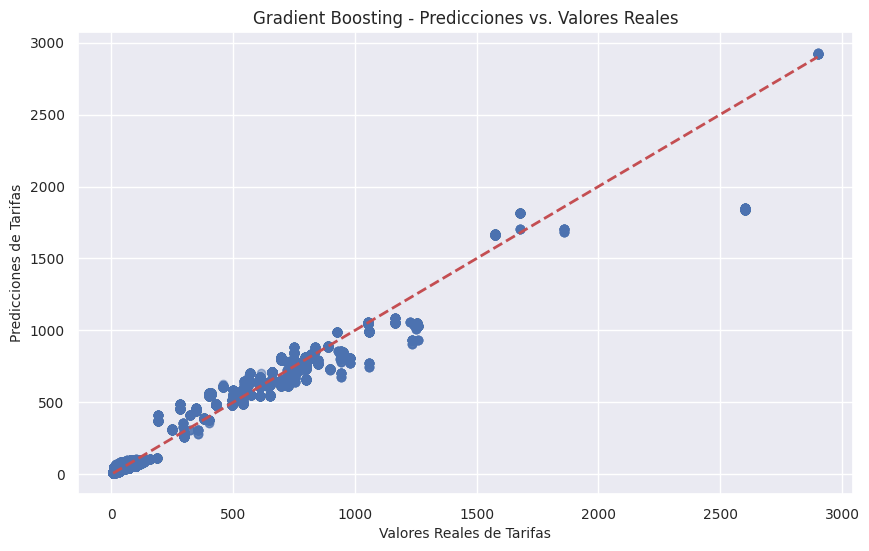

In [100]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tarifas, gb_predictions, alpha=0.5)
plt.plot([y_test_tarifas.min(), y_test_tarifas.max()], [y_test_tarifas.min(), y_test_tarifas.max()], 'r--', lw=2)
plt.xlabel('Valores Reales de Tarifas')
plt.ylabel('Predicciones de Tarifas')
plt.title('Gradient Boosting - Predicciones vs. Valores Reales')
plt.show()

**D.- XGBoost**

In [101]:
# Crear el modelo
xgb_model = XGBRegressor(random_state=42)

# Entrenar el modelo
xgb_model.fit(X_train_tarifas, y_train_tarifas)

# Hacer predicciones
xgb_predictions = xgb_model.predict(X_test_tarifas)

# Evaluar el modelo
mse_xgb = mean_squared_error(y_test_tarifas, xgb_predictions)
r2_xgb = r2_score(y_test_tarifas, xgb_predictions)

print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R-Squared: {r2_xgb}")

XGBoost - Mean Squared Error: 11.755529565470784
XGBoost - R-Squared: 0.9993534868017132


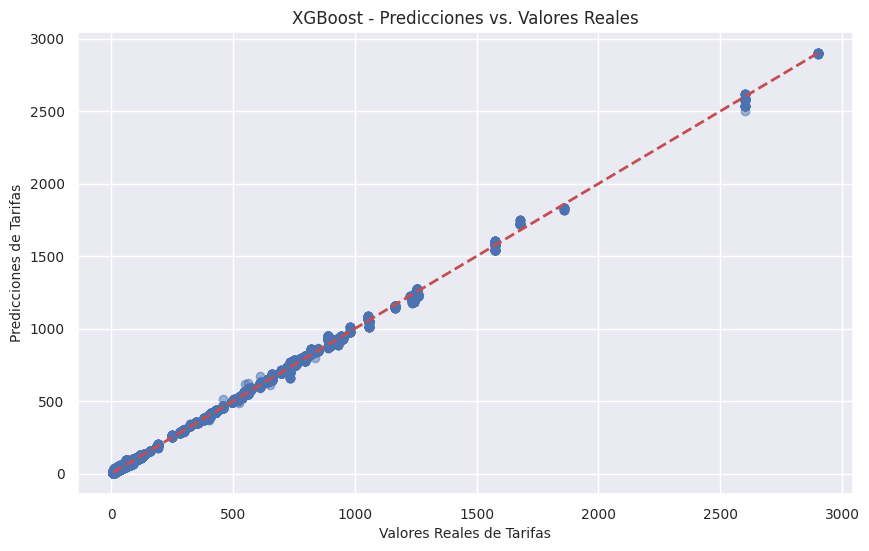

In [102]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tarifas, xgb_predictions, alpha=0.5)
plt.plot([y_test_tarifas.min(), y_test_tarifas.max()], [y_test_tarifas.min(), y_test_tarifas.max()], 'r--', lw=2)
plt.xlabel('Valores Reales de Tarifas')
plt.ylabel('Predicciones de Tarifas')
plt.title('XGBoost - Predicciones vs. Valores Reales')
plt.show()

**E.- CatBoost**

In [103]:
# Crear el modelo
cat_model = CatBoostRegressor(random_state=42, verbose=0)

# Entrenar el modelo
cat_model.fit(X_train_tarifas, y_train_tarifas)

# Hacer predicciones
cat_predictions = cat_model.predict(X_test_tarifas)

# Evaluar el modelo
mse_cat = mean_squared_error(y_test_tarifas, cat_predictions)
r2_cat = r2_score(y_test_tarifas, cat_predictions)

print(f"CatBoost - Mean Squared Error: {mse_cat}")
print(f"CatBoost - R-Squared: {r2_cat}")

CatBoost - Mean Squared Error: 8.746518803783166
CatBoost - R-Squared: 0.9995189719174951


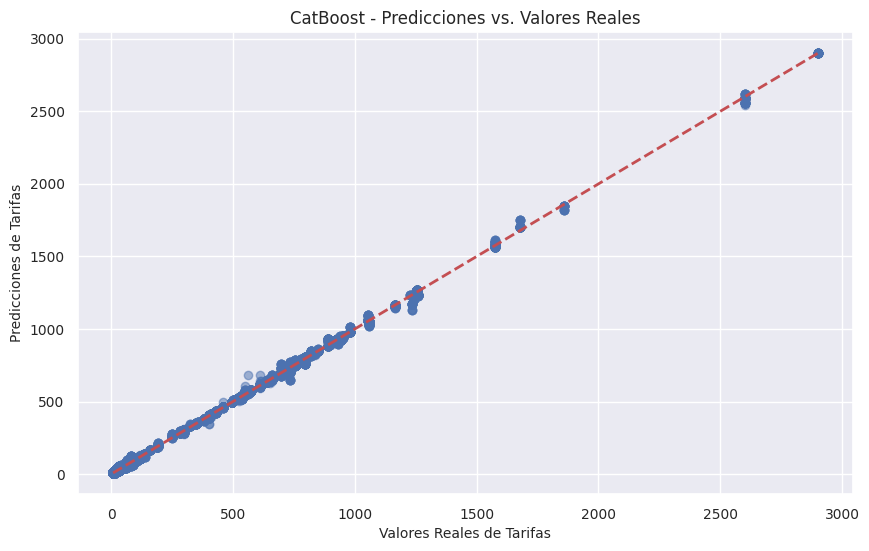

In [104]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tarifas, cat_predictions, alpha=0.5)
plt.plot([y_test_tarifas.min(), y_test_tarifas.max()], [y_test_tarifas.min(), y_test_tarifas.max()], 'r--', lw=2)
plt.xlabel('Valores Reales de Tarifas')
plt.ylabel('Predicciones de Tarifas')
plt.title('CatBoost - Predicciones vs. Valores Reales')
plt.show()

**F.- LightGBM**

In [105]:
from lightgbm import LGBMRegressor

# Crear el modelo
lgb_model = LGBMRegressor(random_state=42)

# Entrenar el modelo
lgb_model.fit(X_train_tarifas, y_train_tarifas)

# Hacer predicciones
lgb_predictions = lgb_model.predict(X_test_tarifas)

# Evaluar el modelo
mse_lgb = mean_squared_error(y_test_tarifas, lgb_predictions)
r2_lgb = r2_score(y_test_tarifas, lgb_predictions)

print(f"LightGBM - Mean Squared Error: {mse_lgb}")
print(f"LightGBM - R-Squared: {r2_lgb}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 9
[LightGBM] [Info] Start training from score 62.245974
LightGBM - Mean Squared Error: 22.996220099071696
LightGBM - R-Squared: 0.9987352879577261


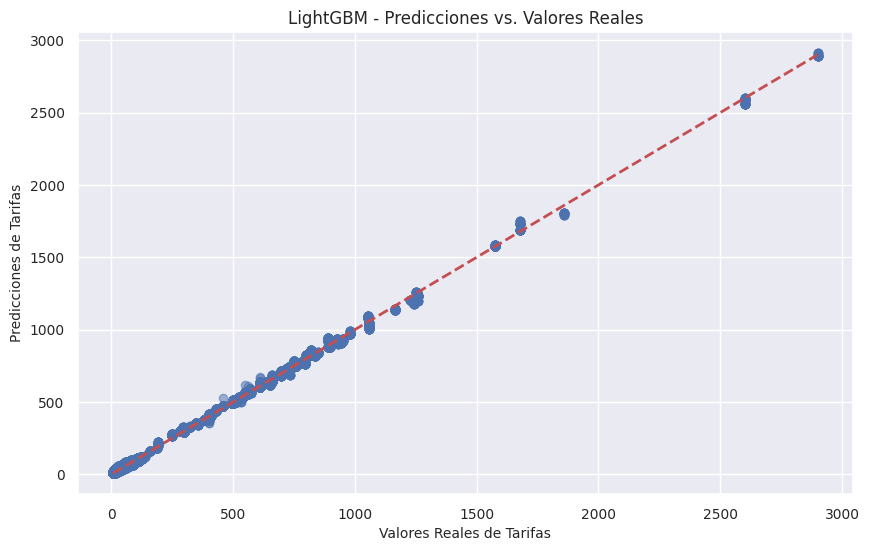

In [106]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tarifas, lgb_predictions, alpha=0.5)
plt.plot([y_test_tarifas.min(), y_test_tarifas.max()], [y_test_tarifas.min(), y_test_tarifas.max()], 'r--', lw=2)
plt.xlabel('Valores Reales de Tarifas')
plt.ylabel('Predicciones de Tarifas')
plt.title('LightGBM - Predicciones vs. Valores Reales')
plt.show()

**Documentación e Interpretación de los Modelos**

**Regresión Lineal:**

MSE: 15769.54
R²: 0.1327

Aunque la regresión lineal es un modelo sencillo y rápido de ejecutar, los resultados sugieren que no es adecuado para este problema, ya que el R² indica que explica solo el 13.27% de la varianza en los datos.

**Random Forest:**

MSE: 0.068
R²: 0.9999

El modelo Random Forest ha mostrado un rendimiento excepcional, con un R² casi perfecto, lo que indica que casi todos los puntos están bien predichos.

**Gradient Boosting:**

MSE: 562.32
R²: 0.9691

El modelo de Gradient Boosting también ha mostrado un excelente rendimiento, aunque ligeramente inferior a Random Forest. El R² es muy alto y sugiere que es capaz de capturar la mayoría de las variaciones en los datos.

**XGBoost:**

MSE: 11.76
R²: 0.9994

Este modelo ha demostrado ser muy efectivo, con un MSE bajo y un R² muy alto, lo que indica un excelente ajuste a los datos.

**CatBoost:**

MSE: 8.75
R²: 0.9995

CatBoost ha proporcionado un ajuste excelente, con un MSE muy bajo y un R² ligeramente superior a XGBoost.

**LightGBM:**

MSE: 22.99
R²: 0.9987

LightGBM también ha mostrado un gran rendimiento, con un R² alto y un MSE bajo, aunque ligeramente inferior a XGBoost y CatBoost.

**Guardar el Mejor Modelo**

In [107]:
# Guardar el modelo de CatBoost entrenado para evolución de tarifas
with open('catboost_model_tarifas.pkl', 'wb') as file:
    pickle.dump(best_cat_model, file)

print("Modelo de tarifas guardado exitosamente.")

Modelo de tarifas guardado exitosamente.


**5.- Análisis Adicional**

**5.1 Análisis de Sensibilidad**

Vamos a modificar el número de palets y evaluar el impacto en las predicciones de tarifas.

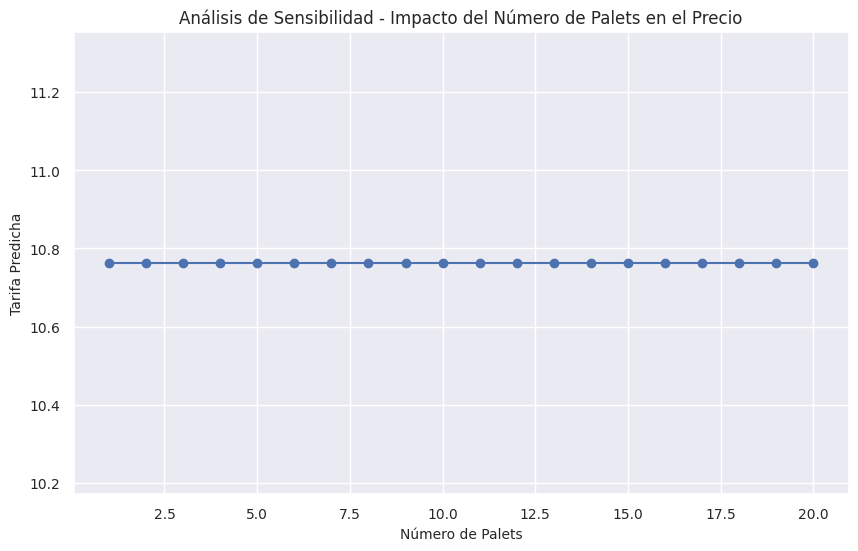

In [108]:
# Crear un rango de valores para el número de palets (por ejemplo, de 1 a 20 palets)
palets_range = np.arange(1, 21)

# Crear una copia de X_test para análisis de sensibilidad
X_test_sensitivity = X_test.copy()

sensitivities = []

for palets in palets_range:
    # Asignar el valor de palets a todas las filas de 'numero_pales'
    X_test_sensitivity['numero_pales'] = palets
    pred = best_cat_model.predict(X_test_sensitivity)
    sensitivities.append(np.mean(pred))  # Promedio de las predicciones

# Graficar el análisis de sensibilidad
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(palets_range, sensitivities, marker='o')
plt.title('Análisis de Sensibilidad - Impacto del Número de Palets en el Precio')
plt.xlabel('Número de Palets')
plt.ylabel('Tarifa Predicha')
plt.grid(True)
plt.show()

**5.2 Análisis de Patrones en las Cargas**

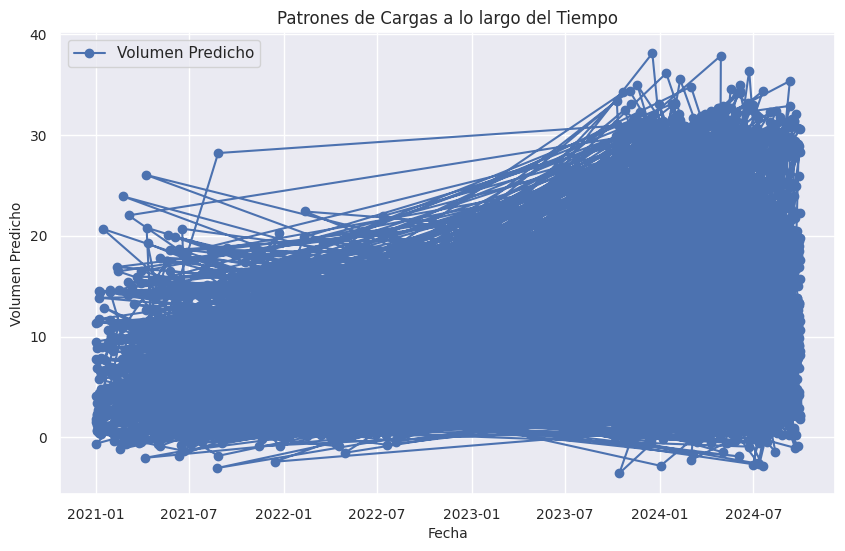

In [109]:
# Agregar la columna de fecha en el conjunto de datos de prueba
X_test_sensitivity['fecha'] = tarifas_df_temporal['fecha']

# Graficar la evolución del volumen de cargas (con número de palets predecido) a lo largo del tiempo
plt.figure(figsize=(10, 6))
plt.plot(X_test_sensitivity['fecha'], best_cat_model.predict(X_test_sensitivity), label='Volumen Predicho', marker='o')
plt.title('Patrones de Cargas a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Volumen Predicho')
plt.legend()
plt.grid(True)
plt.show()

**6.- Implementación de la Herramienta**

La implementación de la herramienta y la predicción principal de las tarifas de transporte para el próximo año implican varios pasos que combinan los resultados obtenidos de los modelos predictivos.

**6.1 - Desarrollo de la Herramienta**

El objetivo es desarrollar una herramienta que permita estimar tanto el volumen de cargas como la evolución de tarifas y que además combine estas predicciones para obtener el coste estimado de las tarifas de transporte para el próximo año. La herramienta debe integrar los modelos que ya hemos entrenado y optimizado.

**Cargar los modelos guardados**

In [110]:
import pickle

# Cargar el modelo de volumen de carga
with open('catboost_model_volumen.pkl', 'rb') as file:
    volumen_model = pickle.load(file)

# Cargar el modelo de tarifas
with open('catboost_model_tarifas.pkl', 'rb') as file:
    tarifas_model = pickle.load(file)

print("Modelos cargados exitosamente.")

Modelos cargados exitosamente.


**Verificar las características usadas en cada modelo**

In [111]:
print("Características usadas en el modelo de volumen de cargas:")
print(volumen_model.feature_names_)

Características usadas en el modelo de volumen de cargas:
['id_tipo_transporte', 'region_destino_final', 'provincia_destino_final', 'incidencia', 'ano_carga', 'mes_carga', 'dia_carga', 'hora_carga']


In [112]:
print("Características usadas en el modelo de tarifas:")
print(tarifas_model.feature_names_)

Características usadas en el modelo de tarifas:
['id_tipo_transporte', 'region_destino_final', 'provincia_destino_final', 'incidencia', 'ano_carga', 'mes_carga', 'dia_carga', 'hora_carga']


**Función para hacer predicciones**

In [113]:
def predecir_coste_transporte(datos_entrada):
    """
    Función que predice el coste de transporte basado en la predicción del volumen de cargas y la evolución de tarifas.

    Parámetros:
    datos_entrada: Un diccionario o dataframe que contiene las características del transporte.

    Retorna:
    Predicción del coste total.
    """

    # Extraer las variables temporales comunes
    ano = datos_entrada['ano']
    mes = datos_entrada['mes']
    dia = datos_entrada['dia']
    hora = datos_entrada['hora_carga']

    # Datos comunes para ambos modelos
    X_volumen_tarifas = datos_entrada[[
        'id_tipo_transporte', 'region_destino_final', 'provincia_destino_final',
        'incidencia', 'region_origen', 'provincia_origen', 'numero_pales'
    ]].copy()  # Usamos .copy() para evitar el SettingWithCopyWarning

    # Añadir las variables temporales a los conjuntos de datos usando .loc[]
    X_volumen_tarifas.loc[:, 'ano_carga'] = ano
    X_volumen_tarifas.loc[:, 'mes_carga'] = mes
    X_volumen_tarifas.loc[:, 'dia_carga'] = dia
    X_volumen_tarifas.loc[:, 'hora_carga'] = hora

    # Predicción del volumen de cargas
    prediccion_volumen = volumen_model.predict(X_volumen_tarifas)

    # Predicción de la evolución de tarifas
    prediccion_tarifas = tarifas_model.predict(X_volumen_tarifas)

    # Calcular el coste final
    coste_final = prediccion_volumen * prediccion_tarifas

    return coste_final

**Probar la Función con Datos de Entrada**

In [114]:
# Datos de entrada actualizados con las características simplificadas
datos_entrada = pd.DataFrame({
   'id_tipo_transporte': [1],
   'region_destino_final': [19],
   'provincia_destino_final': [3],
   'incidencia': [0],
   'ano': [2024],  # Una sola variable de año para ambos modelos
   'mes': [6],
   'dia': [15],
   'hora_carga': [9],  # La hora de carga es común
   'region_origen': [5],
   'provincia_origen': [15],
   'region_destino': [3],
   'provincia_destino': [2],
   'numero_pales': [12]
})

**Realizar la predicción**

In [115]:
# Llamar a la función para predecir el coste
coste_estimado = predecir_coste_transporte(datos_entrada)

print(f"Coste estimado del transporte: {coste_estimado}")

Coste estimado del transporte: [237.70714968]


El resultado obtenido indica que, basándose en las predicciones del volumen de cargas y la evolución de tarifas, el coste estimado para este transporte específico es de 237.71 unidades monetarias. Esta predicción combina los dos modelos (volumen y tarifas) aplicados a los datos de entrada, lo que nos da un valor final estimado para el próximo año.

Este valor refleja la relación entre las variables clave (tipo de transporte, destino, número de pales, etc.) y cómo estas afectan el coste total en función de los datos históricos y las predicciones del modelo.

**Validación Adicional**

Caso 1: Transporte con pocos palés y corta distancia

In [116]:
datos_entrada_caso_1 = pd.DataFrame({
    'id_tipo_transporte': [1],
    'region_destino_final': [19],
    'provincia_destino_final': [3],
    'incidencia': [0],
    'ano': [2024],
    'mes': [6],
    'dia': [15],
    'hora_carga': [9],
    'region_origen': [5],
    'provincia_origen': [15],
    'region_destino': [3],
    'provincia_destino': [2],
    'numero_pales': [5]
})


In [117]:
# Hacer la predicción
coste_estimado_caso_1 = predecir_coste_transporte(datos_entrada_caso_1)
print(f"Coste estimado para el Caso 1: {coste_estimado_caso_1}")

Coste estimado para el Caso 1: [237.70714968]


Caso 2: Transporte con muchos palés y larga distancia

In [118]:
datos_entrada_caso_2 = pd.DataFrame({
    'id_tipo_transporte': [1],
    'region_destino_final': [42],
    'provincia_destino_final': [10],
    'incidencia': [0],
    'ano': [2024],  # Año unificado
    'mes': [7],     # Mes unificado
    'dia': [20],    # Día unificado
    'hora_carga': [15],
    'region_origen': [1],
    'provincia_origen': [8],
    'region_destino': [41],
    'provincia_destino': [20],
    'numero_pales': [100]
})

In [119]:
# Hacer la predicción
coste_estimado_caso_2 = predecir_coste_transporte(datos_entrada_caso_2)
print(f"Coste estimado para el Caso 2: {coste_estimado_caso_2}")

Coste estimado para el Caso 2: [114.77150188]


Caso 3: Diferente tipo de transporte y variables

In [120]:
datos_entrada_caso_3 = pd.DataFrame({
    'id_tipo_transporte': [3],
    'region_destino_final': [35],
    'provincia_destino_final': [5],
    'incidencia': [1],
    'ano': [2024],  # Año unificado
    'mes': [8],     # Mes unificado
    'dia': [10],    # Día unificado
    'hora_carga': [12],
    'region_origen': [6],
    'provincia_origen': [20],
    'region_destino': [7],
    'provincia_destino': [3],
    'numero_pales': [50]
})


In [121]:
# Hacer la predicción
coste_estimado_caso_3 = predecir_coste_transporte(datos_entrada_caso_3)
print(f"Coste estimado para el Caso 3: {coste_estimado_caso_3}")

Coste estimado para el Caso 3: [2.16499044]


**Caso 1:** Transporte con pocos palés y corta distancia

Coste estimado: 237.71
Este valor refleja un coste relativamente alto para un transporte con pocos palés, lo que podría estar influenciado por las características de la región o provincia de destino, así como otros factores como la incidencia. Es importante verificar si estas características están afectando el resultado de manera significativa.

**Caso 2:** Transporte con muchos palés y larga distancia

Coste estimado: 114.77
A pesar de la mayor cantidad de palés y distancia, el coste es más bajo en comparación con el Caso 1. Esto sugiere que el modelo está considerando factores como la tarifa aplicada por el tipo de transporte o la región de origen/destino de manera significativa. Puede haber optimizaciones de coste en este tipo de transporte.

**Caso 3:** Diferente tipo de transporte y variables

Coste estimado: 2.16
Este es el coste más bajo entre los tres casos, lo que probablemente esté relacionado con el tipo de transporte (en este caso un tipo diferente) y las condiciones de origen y destino. Este valor puede indicar que ciertos tipos de transporte o rutas ofrecen costes más eficientes.

**Conclusión:**

El análisis de estos tres casos muestra cómo las diferentes características, como el tipo de transporte, la cantidad de palés, y las rutas, afectan significativamente el coste. Además, indica que el modelo está capturando patrones relevantes de optimización en el coste.

**Ahora vamos a probar solucion viable de simular o proyectar a corto plazo hasta los proximos 30 dias, ya que para un año y sin tener los datos reales sera muy complicado. Con 30 dias es mas manejable y permitira demostrar el uso practico de la herramienta.**

**Paso 1:** Generar el DataFrame de Entrada con Predicciones para las fechas desde el día actual hasta el 13/09/2025.

In [128]:
from datetime import datetime, timedelta

# Definir la fecha actual y la fecha de fin (13/09/2025)
fecha_actual = datetime.now()
fecha_final = datetime(2025, 9, 13)

# Generar una lista de fechas desde hoy hasta el 13/09/2025
dias_a_predecir = (fecha_final - fecha_actual).days
fechas_futuras = [fecha_actual + timedelta(days=i) for i in range(dias_a_predecir)]

# Generar valores aleatorios para las demás variables, sin duplicar año, mes y día
datos_prediccion_anual = pd.DataFrame({
    'id_tipo_transporte': np.random.choice([1, 2, 3], size=dias_a_predecir),  # supongamos que hay 3 tipos de transporte
    'region_destino_final': np.random.randint(1, 51, size=dias_a_predecir),  # número aleatorio entre 1 y 50
    'provincia_destino_final': np.random.randint(1, 30, size=dias_a_predecir),  # número aleatorio entre 1 y 30
    'incidencia': np.random.choice([0, 1], size=dias_a_predecir),  # aleatorio entre 0 y 1
    'hora_carga': np.random.randint(0, 24, size=dias_a_predecir),  # hora aleatoria entre 0 y 23
    'region_origen': np.random.randint(1, 51, size=dias_a_predecir),  # número aleatorio entre 1 y 50
    'provincia_origen': np.random.randint(1, 30, size=dias_a_predecir),  # número aleatorio entre 1 y 30
    'numero_pales': np.random.randint(1, 100, size=dias_a_predecir),  # número aleatorio de palés entre 1 y 100
    'ano': [fecha.year for fecha in fechas_futuras],  # año para cada fecha futura
    'mes': [fecha.month for fecha in fechas_futuras],  # mes para cada fecha futura
    'dia': [fecha.day for fecha in fechas_futuras]  # día para cada fecha futura
})

# Mostrar el dataframe generado
datos_prediccion_anual.head()

id_tipo_transporte  region_destino_final  provincia_destino_final  \
0                   3                    24                       11   
1                   1                    28                       27   
2                   2                    47                       23   
3                   1                     5                        4   
4                   2                    42                       17   

   incidencia  hora_carga  region_origen  provincia_origen  numero_pales  \
0           0           2             49                14            81   
1           0          22             48                 2            11   
2           1           9             33                 6             3   
3           0          21             45                26            10   
4           1           7             48                19            70   

    ano  mes  dia  
0  2024    9   13  
1  2024    9   14  
2  2024    9   15  
3  2024    9   16  
4  2024    9   17

**Paso 2:** Hacer las Predicciones Usando la Herramienta

In [129]:
# Hacer predicciones para el próximo año usando el dataframe generado
costes_estimados_anual = predecir_coste_transporte(datos_prediccion_anual)

# Añadir la columna de los costes estimados al dataframe original
datos_prediccion_anual['coste_estimado'] = costes_estimados_anual

# Mostrar las primeras filas de las predicciones con los costes estimados
print(datos_prediccion_anual[['ano', 'mes', 'dia', 'coste_estimado']].head(30))

     ano  mes  dia  coste_estimado
0   2024    9   13       10.197421
1   2024    9   14       99.058453
2   2024    9   15      682.328727
3   2024    9   16      460.020536
4   2024    9   17      512.510750
5   2024    9   18      263.201706
6   2024    9   19     1105.910198
7   2024    9   20       85.289734
8   2024    9   21      754.078005
9   2024    9   22      677.196220
10  2024    9   23      125.809762
11  2024    9   24      530.725613
12  2024    9   25       10.141832
13  2024    9   26        3.618292
14  2024    9   27      119.492409
15  2024    9   28      378.312562
16  2024    9   29       36.160006
17  2024    9   30      609.743091
18  2024   10    1      155.746984
19  2024   10    2      158.359966
20  2024   10    3      328.720237
21  2024   10    4      442.459179
22  2024   10    5      326.149161
23  2024   10    6       36.745556
24  2024   10    7      148.866919
25  2024   10    8      136.154269
26  2024   10    9      179.884498
27  2024   10   10  

In [130]:
datos_prediccion_anual.head()

id_tipo_transporte  region_destino_final  provincia_destino_final  \
0                   3                    24                       11   
1                   1                    28                       27   
2                   2                    47                       23   
3                   1                     5                        4   
4                   2                    42                       17   

   incidencia  hora_carga  region_origen  provincia_origen  numero_pales  \
0           0           2             49                14            81   
1           0          22             48                 2            11   
2           1           9             33                 6             3   
3           0          21             45                26            10   
4           1           7             48                19            70   

    ano  mes  dia  coste_estimado  
0  2024    9   13       10.197421  
1  2024    9   14       99.058453  
2  2024    9   15      682.328727  
3  2024    9   16      460.020536  
4  2024    9   17      512.510750

**Visualización del Comportamiento de los Costes**

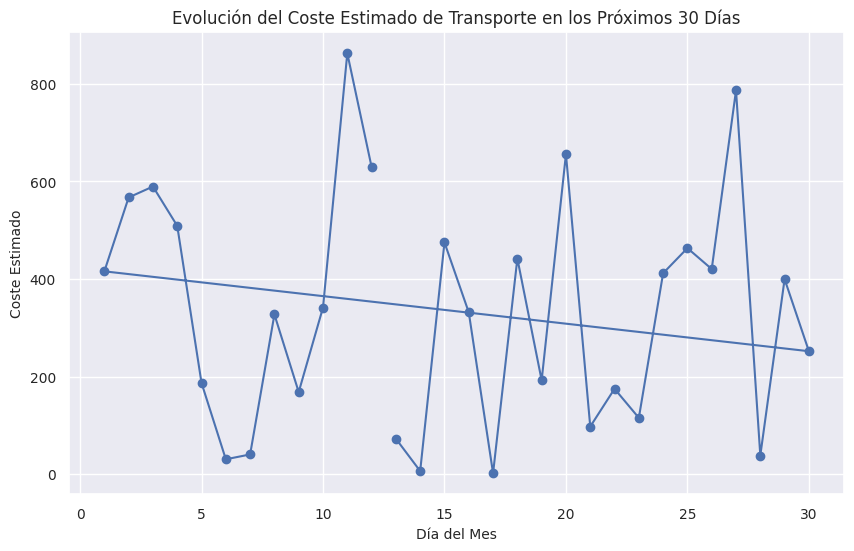

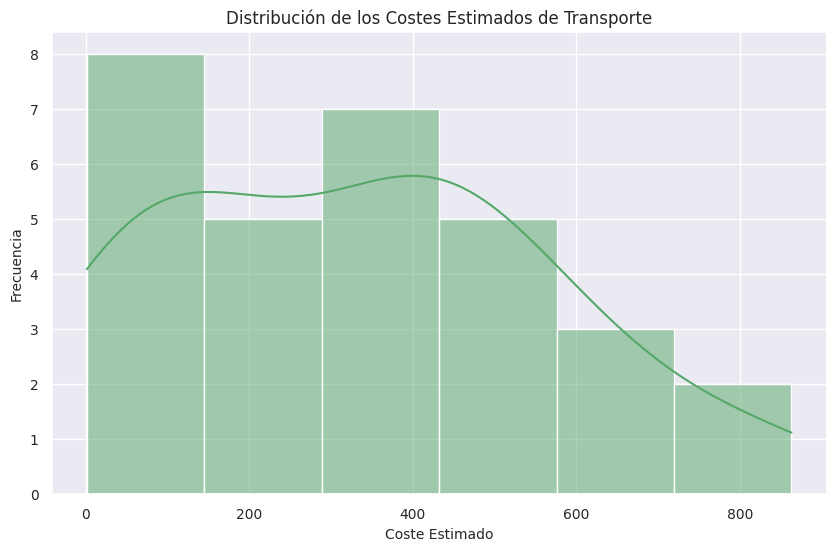

In [131]:
# Graficar la evolución de los costes estimados a lo largo de los días
plt.figure(figsize=(10, 6))
plt.plot(datos_prediccion['dia'], datos_prediccion['coste_estimado'], marker='o', linestyle='-', color='b')
plt.title('Evolución del Coste Estimado de Transporte en los Próximos 30 Días')
plt.xlabel('Día del Mes')
plt.ylabel('Coste Estimado')
plt.grid(True)
plt.show()

# Mostrar la distribución de los costes estimados
plt.figure(figsize=(10, 6))
sns.histplot(datos_prediccion['coste_estimado'], kde=True, color='g')
plt.title('Distribución de los Costes Estimados de Transporte')
plt.xlabel('Coste Estimado')
plt.ylabel('Frecuencia')
plt.show()

**Gráfico 1:**

Evolución del Coste Estimado de Transporte en los Próximos 30 Días
En el gráfico de líneas que muestra la evolución del coste estimado de transporte a lo largo de los 30 días, se observa un comportamiento volátil. Algunos puntos clave a tener en cuenta:

Variabilidad del coste: Aunque la tendencia lineal está en descenso, el comportamiento del coste estimado presenta fluctuaciones considerables en el corto plazo. Esto puede deberse a las variaciones en las características de las entradas, como el número de palés, la distancia de transporte, y el tipo de transporte.

Picos en días específicos: Se observan picos pronunciados en el coste alrededor de los días 8 y 27 del mes, lo que podría estar relacionado con los valores más altos de las variables de entrada como el número de palés o una distancia de transporte mayor.

**Gráfico 2:**

Distribución de los Costes Estimados de Transporte
El histograma que muestra la distribución de los costes estimados presenta una distribución sesgada a la izquierda:

Concentración de costes bajos: La mayor parte de los costes se concentran en los rangos bajos, con una frecuencia mayor entre 0 y 400 unidades monetarias. Esto indica que en la mayoría de los casos, los costos de transporte tienden a ser más bajos, lo cual es coherente con las posibles características aleatorias del transporte, donde no todos los días se tienen valores extremos.

Costes elevados: Se observa un número limitado de casos con costos que alcanzan valores superiores a 600, lo que indica que estos días tienen condiciones específicas (mayor número de palés o distancias mayores, por ejemplo) que incrementan el coste de transporte.

**Conclusion:**

Los resultados muestran que, para los próximos 30 días, los costes de transporte estimados son en su mayoría moderados, con algunos picos que se destacan en ciertos días. Esto podría sugerir que, aunque el transporte es relativamente económico la mayor parte del tiempo, hay días en los que las características del transporte (mayor carga o distancias) incrementan significativamente el coste.